# Setup

In [ ]:
%pip install mnist gensim
%pip install tensorflow

In [1]:
import os
import math
import time
import psutil
import random
import pandas as pd
import numpy as np
import networkx as nx

import mnist
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.utils as utils
from torch_geometric.utils import to_networkx

import tensorflow as tf
from tensorflow.keras.datasets import mnist

from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from scipy.sparse.linalg import eigs
from gensim.models import Word2Vec

from sklearn.neural_network import MLPRegressor
import warnings


In [2]:
def set_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)

set_seed(99)

# Data Preprocessing

In [3]:
dataset_path = '/Users/gitaayusalsabila/Documents/0thesis/code/sandbox/dataset/'
# dataset_path = '/notebooks/dataset/'

### SLIM Dataset

In [4]:
def data_cleansing(dataset):
    # Replace negative values with 0
    dataset[dataset < 0] = 0
    
    # Replace NaN values with 0
    dataset = np.nan_to_num(dataset, nan=0)
    
    return dataset

def check_and_drop_invalid_graphs(graph_dataset):
    """
    Check that all graphs in the dataset have more than 0 edges and drop graphs with 0 edges in any timepoint or dimension.
    
    Parameters:
    graph_dataset (np.ndarray): The input graph dataset with shape [g, t, n, n, d] or [g, t, n, n]
    
    Returns:
    np.ndarray: The cleaned dataset with invalid graphs removed
    """
    
    # Check the shape of the dataset to determine if it has multiple dimensions
    if len(graph_dataset.shape) == 5:
        num_graphs, num_timepoints, num_nodes, _, num_dimensions = graph_dataset.shape
    else:
        num_graphs, num_timepoints, num_nodes, _ = graph_dataset.shape
        num_dimensions = 1
    
    valid_graphs = []

    for i in range(num_graphs):
        is_valid = True
        for t in range(num_timepoints):
            for d in range(num_dimensions):
                if num_dimensions > 1:
                    adj_matrix = graph_dataset[i, t, :, :, d]
                else:
                    adj_matrix = graph_dataset[i, t, :, :]
                
                num_edges = np.sum(adj_matrix > 0)
                if num_edges == 0:
                    is_valid = False
                    break
            if not is_valid:
                break
        
        if is_valid:
            valid_graphs.append(i)
    
    if num_dimensions > 1:
        cleaned_dataset = graph_dataset[valid_graphs, :, :, :, :]
    else:
        cleaned_dataset = graph_dataset[valid_graphs, :, :, :]
    
    return cleaned_dataset

# Load Graph Data
slim160 = np.load(dataset_path + 'slim160_adj.npy')
slim268 = np.load(dataset_path + 'slim268_adj.npy')

slim160_cleaned = data_cleansing(slim160)
slim160_cleaned = check_and_drop_invalid_graphs(slim160_cleaned)
print('slim160 shape:',slim160_cleaned.shape)

slim268_cleaned = data_cleansing(slim268)
slim268_cleaned = check_and_drop_invalid_graphs(slim268_cleaned)
print('slim268 shape:',slim268_cleaned.shape)


slim160 shape: (109, 3, 160, 160)
slim268 shape: (109, 3, 268, 268)


In [6]:
def extract_subgraphs(adjacency_matrix):
    """
    Extract subgraphs for each node in the graph.
    """
    n_nodes = adjacency_matrix.shape[0]
    subgraphs = []
    
    for node in range(n_nodes):
        subgraph_nodes = [node] + list(np.nonzero(adjacency_matrix[node])[0])
        subgraph = adjacency_matrix[np.ix_(subgraph_nodes, subgraph_nodes)]
        subgraphs.append(subgraph)
    
    return subgraphs

def extract_all_subgraphs(dataset):
    """
    Extract subgraphs for each node in each graph in the dataset.
    """
    all_subgraphs = []
    
    for subject in range(dataset.shape[0]):
        for timepoint in range(dataset.shape[1]):
            adjacency_matrix = dataset[subject, timepoint]
            subgraphs = extract_subgraphs(adjacency_matrix)
            all_subgraphs.append((subject, timepoint, subgraphs))
    
    return all_subgraphs

slim160_subgraphs = extract_all_subgraphs(slim160_cleaned)

### Maturation Dataset

In [40]:
maturation_data = np.load(dataset_path + 'maturation_adj.npy')
print('mature shape:',maturation_data.shape)

mature shape: (77, 9, 300, 300)


In [41]:
def transform_and_filter_data(connectome_array):
    s, t, n, _ = connectome_array.shape
    
    # Step 1: Create time labels
    time_labels_list = []
    for i in range(s):
        for j in range(t):
            time_labels_list.append(j+1)
    
    time_labels_ori = np.array(time_labels_list)
    time_labels = time_labels_ori.reshape(s*t, 1)
    time_labels_expanded = np.tile(A_reshaped, (1, 1, n, n))

    flattened_connectomic_array = connectome_array.reshape(-1, n, n)

    transformed_data = np.zeros((693, 1, 300, 300))
    transformed_data[:, 0, :, :] = flattened_connectomic_array
    transformed_data[:, :, 0, 0] = time_labels
    print("Shape of flattened connectomic array:", transformed_data.shape)
    
    # Step 2: Filter out graphs with NaN values
    mask = ~np.isnan(transformed_data).any(axis=(1, 2, 3))
    filtered_data = transformed_data[mask]
    
    return filtered_data,time_labels_ori

In [42]:
transformed_and_filtered_data, time_labels = transform_and_filter_data(maturation_data)
print("Shape of transformed and filtered data:", transformed_and_filtered_data.shape)

# checked transformed data
second_dim_values = transformed_and_filtered_data[:, 0, 0, 0]
unique_values = np.unique(second_dim_values)
print(f"Unique values in the second dimension: {unique_values}")

Shape of flattened connectomic array: (693, 1, 300, 300)
Shape of transformed and filtered data: (262, 1, 300, 300)
Unique values in the second dimension: [1. 2. 3. 4. 5. 6. 7. 8. 9.]


# Cognitive Property Calculation

In [7]:
# Function to initialize the ESN with given adjacency matrix and spectral radius
def initialize_esn(adjacency_matrix, input_size, reservoir_size, output_size, spectral_radius=0.9, input_scaling=1):
    np.random.seed(99)
    Win = (np.random.rand(reservoir_size, input_size) - 0.5) * input_scaling
    Wres = adjacency_matrix
    
    # Adjust spectral radius
    eigvals = eigs(Wres, k=1, which='LM', return_eigenvectors=False)
    # if eigvals > 0:
    #     Wres = Wres * (spectral_radius / np.abs(eigvals[0]))
    
    max_eigval = np.abs(eigvals).max()
    if max_eigval > 0:
        Wres = Wres * (spectral_radius / max_eigval)
    else:
        warnings.warn("Largest eigenvalue is zero, skipping spectral radius adjustment.")

    bias = np.ones(reservoir_size) 
    
    return Win, Wres, bias

# Function to train the readout layer using ridge regression
def train_readout(states, target_data, alpha=50):
    ridge_reg = Ridge(alpha=alpha)
    ridge_reg.fit(states, target_data)
    Wout = ridge_reg.coef_
    return Wout

# Function to calculate MAE for ESN
def calculate_mae(Win, Wres, bias, input_data, target_data, alpha=50):
    n_reservoir = Wres.shape[0]
    n_samples = input_data.shape[0]
    states = np.zeros((n_samples, n_reservoir))
    
    for t in range(1, n_samples):
        states[t] = np.tanh(np.dot(Wres, states[t-1]) + np.dot(Win, input_data[t]))
    
    # Train the readout layer
    Wout = train_readout(states, target_data, alpha)
    
    # Predict outputs
    outputs = np.dot(states, Wout.T)
    mae = mean_absolute_error(target_data, outputs)
    return mae

# Function to calculate R-squared for ESN
def calculate_r2(Win, Wres, bias, input_data, target_data, alpha=50):
    n_reservoir = Wres.shape[0]
    n_samples = input_data.shape[0]
    states = np.zeros((n_samples, n_reservoir))
    
    for t in range(1, n_samples):
        states[t] = np.tanh(np.dot(Wres, states[t-1]) + np.dot(Win, input_data[t]))
    
    # Check for NaNs in states
    if np.any(np.isnan(states)):
        return float('nan')

    # Train the readout layer
    Wout = train_readout(states, target_data, alpha)
    
    # Predict outputs
    outputs = np.dot(states, Wout.T)
    r2 = r2_score(target_data, outputs)
    return r2

In [8]:
# Function to generate Mackey-Glass sequence
def generate_mackey_glass_sequence(tau=17, n_samples=1000, delta_t=1, beta=0.2, gamma=0.1, n=10):
    x = np.zeros(n_samples)
    x[0] = 1.2  # Initial condition

    for t in range(1, n_samples):
        if t - tau >= 0:
            x[t] = x[t-1] + (beta * x[t-tau] / (1 + x[t-tau]**n) - gamma * x[t-1]) * delta_t
        else:
            x[t] = x[t-1]  # Use previous value if index is out of bounds

    return x

# Generate the number sequence data (Mackey-Glass sequence)
def generate_number_sequence_data():
    mackey_glass_sequence = generate_mackey_glass_sequence()
    mackey_target = np.roll(mackey_glass_sequence, -1)  # Target is the next value in the sequence
    return mackey_glass_sequence.reshape(-1, 1), mackey_target.reshape(-1, 1)

# Load and preprocess MNIST data for regression task
def load_mnist_data():
    (train_images, train_labels), _ = mnist.load_data()
    return train_images, train_labels

def generate_mnist_regression_data():
    mnist_train_images, _ = load_mnist_data()
    mnist_train_images = mnist_train_images.reshape(-1, 28, 28)[:100]  # Use the first 100 images for simplicity

    # Predict the next column of pixels
    mnist_input = mnist_train_images[:, :, :-1]  # All columns except the last
    mnist_target = mnist_train_images[:, :, 1:]  # All columns except the first
    
    # Reshape for ESN
    mnist_input = mnist_input.reshape(-1, 28*27)
    mnist_target = mnist_target.reshape(-1, 28*27)
    
    return mnist_input, mnist_target

# Generate simple word2vec model and data
def generate_word2vec_data():
    sentences = [["cat", "sat", "on", "the", "mat"],
                 ["dog", "barked", "at", "the", "moon"],
                 ["man", "drank", "coffee"],
                 ["the", "cat", "chased", "the", "mouse"],
                 ["the", "dog", "chased", "the", "cat"],
                 ["the", "man", "read", "the", "newspaper"],
                 ["the", "moon", "was", "bright"],
                 ["the", "coffee", "was", "hot"],
                 ["the", "dog", "barked", "loudly"],
                 ["the", "man", "sat", "in", "the", "chair"]]
    
    # Tune Word2Vec parameters
    model = Word2Vec(sentences, vector_size=50, window=10, min_count=1, workers=4, epochs=10)
    
    word_input = []
    word_target = []
    
    # Create input and target sequences for each sentence
    for sentence in sentences:
        input_seq = np.array([model.wv[word] for word in sentence[:-1]])
        target_seq = np.array([model.wv[word] for word in sentence[1:]])
        word_input.extend(input_seq)
        word_target.extend(target_seq)
    
    word_input = np.array(word_input)
    word_target = np.array(word_target)
    
    # Normalize word vectors
    word_input = normalize(word_input, axis=1)
    word_target = normalize(word_target, axis=1)
    
    return word_input, word_target

# Generate tasks data
def generate_tasks_data():
    # Number sequence (Mackey-Glass sequence)
    number_sequence, number_target = generate_number_sequence_data()
    
    # MNIST sequence
    mnist_input, mnist_target = generate_mnist_regression_data()
    
    # Word2Vec sequence
    word_input, word_target = generate_word2vec_data()
    
    return (number_sequence, number_target), (mnist_input, mnist_target), (word_input, word_target)

# Generate tasks data
(number_sequence, number_target), (mnist_input, mnist_target), (word_input, word_target) = generate_tasks_data()


## SLIM Dataset

### SLIM Dataset (Connectivity Matrices)

#### R-Squared

In [9]:
def calculate_cognitive_capacity_r2(dataset, num_nodes):
    # Initialize and test ESNs for each graph in the dataset
    r2_results = []
    reservoir_size = num_nodes

    for subject in range(dataset.shape[0]):    
        subject_r2 = []
        for timepoint in range(dataset.shape[1]):
            adjacency_matrix = dataset[subject, timepoint]
            
            # Calculate R-squared for number sequence
            Win, Wres, bias = initialize_esn(adjacency_matrix, input_size=1, reservoir_size=reservoir_size, output_size=1)
            number_r2 = calculate_r2(Win, Wres, bias, number_sequence, number_target)
            
            # Calculate R-squared for MNIST sequence
            Win, Wres, bias = initialize_esn(adjacency_matrix, input_size=28*27, reservoir_size=reservoir_size, output_size=28*27)
            mnist_r2 = calculate_r2(Win, Wres, bias, mnist_input, mnist_target, alpha=80)
            
            # Calculate R-squared for Word2Vec sequence
            Win, Wres, bias = initialize_esn(adjacency_matrix, input_size=50, reservoir_size=reservoir_size, output_size=50, spectral_radius=0.7)
            word_r2 = calculate_r2(Win, Wres, bias, word_input, word_target, alpha=10)
            
            subject_r2.append((number_r2, mnist_r2, word_r2))
        r2_results.append(subject_r2)
        print(f'calculating cognitive capacity of subject {subject+1}, results: {subject_r2[0]}')
    # Convert results to a DataFrame for easier manipulation
    r2_df = pd.DataFrame(r2_results, columns=['Timepoint_1', 'Timepoint_2', 'Timepoint_3'])
    r2_df[['Number_R2_1', 'Image_R2_1', 'Word_R2_1']] = pd.DataFrame(r2_df['Timepoint_1'].tolist())
    r2_df[['Number_R2_2', 'Image_R2_2', 'Word_R2_2']] = pd.DataFrame(r2_df['Timepoint_2'].tolist())
    r2_df[['Number_R2_3', 'Image_R2_3', 'Word_R2_3']] = pd.DataFrame(r2_df['Timepoint_3'].tolist())
    r2_df.drop(columns=['Timepoint_1', 'Timepoint_2', 'Timepoint_3'], inplace=True)

    # Calculate mean, max, min for each timepoint
    mean_r2 = r2_df.mean()
    std_r2 = r2_df.std()
    max_r2 = r2_df.max()
    min_r2 = r2_df.min()

    return r2_df, mean_r2, std_r2, max_r2, min_r2

# Example usage with the 'slim160_cleaned' dataset
slim160_r2_df, slim160_mean_r2, slim160_std_r2, slim160_max_r2, slim160_min_r2 = calculate_cognitive_capacity_r2(slim160_cleaned, 160)
slim160_r2_df

calculating cognitive capacity of subject 1, results: (0.8728222865616357, 0.6211746914683942, 0.2233452997596131)
calculating cognitive capacity of subject 2, results: (0.8371522388999257, 0.6211524210247626, 0.2272473030341643)
calculating cognitive capacity of subject 3, results: (0.8735543053502812, 0.621169131322628, 0.22583248997007907)
calculating cognitive capacity of subject 4, results: (0.833506032058793, 0.6211573872582996, 0.23330011389813335)
calculating cognitive capacity of subject 5, results: (0.8263527103158498, 0.6211573668793575, 0.21991460318786174)
calculating cognitive capacity of subject 6, results: (0.8733047722876861, 0.621167610368332, 0.23397522490059167)
calculating cognitive capacity of subject 7, results: (0.8361525818200704, 0.6211808958301688, 0.22984600003350042)
calculating cognitive capacity of subject 8, results: (0.8023290265126397, 0.6211716242542575, 0.23382018497121002)
calculating cognitive capacity of subject 9, results: (0.8427276840138139, 0.

Number_R2_1  Image_R2_1  Word_R2_1  Number_R2_2  Image_R2_2  Word_R2_2  \
0       0.872822    0.621175   0.223345     0.874273    0.621170   0.227396   
1       0.837152    0.621152   0.227247     0.828085    0.621179   0.228445   
2       0.873554    0.621169   0.225832     0.825440    0.621195   0.228351   
3       0.833506    0.621157   0.233300     0.807122    0.621191   0.228993   
4       0.826353    0.621157   0.219915     0.797776    0.621107   0.229885   
..           ...         ...        ...          ...         ...        ...   
104     0.836543    0.621159   0.221993     0.835018    0.621175   0.227939   
105     0.842390    0.621165   0.228863     0.843767    0.621178   0.225665   
106     0.818293    0.621183   0.224925     0.844681    0.621169   0.229592   
107     0.854939    0.621184   0.230710     0.857429    0.621173   0.224037   
108     0.827013    0.621175   0.226003     0.875713    0.621110   0.231176   

     Number_R2_3  Image_R2_3  Word_R2_3  
0       0.839719    0.621210   0.232849  
1       0.842032    0.621162   0.232598  
2       0.879993    0.621169   0.224501  
3       0.826514    0.621143   0.230051  
4       0.858130    0.621113   0.230141  
..           ...         ...        ...  
104     0.861826    0.621174   0.225864  
105     0.800083    0.621162   0.224032  
106     0.785680    0.621171   0.224264  
107     0.859526    0.621161   0.229596  
108     0.875082    0.621173   0.225522  

[109 rows x 9 columns]

In [10]:
slim160_mean_r2.sort_index()

Image_R2_1     0.621170
Image_R2_2     0.621169
Image_R2_3     0.621165
Number_R2_1    0.847384
Number_R2_2    0.850108
Number_R2_3    0.844394
Word_R2_1      0.228439
Word_R2_2      0.228903
Word_R2_3      0.228767
dtype: float64

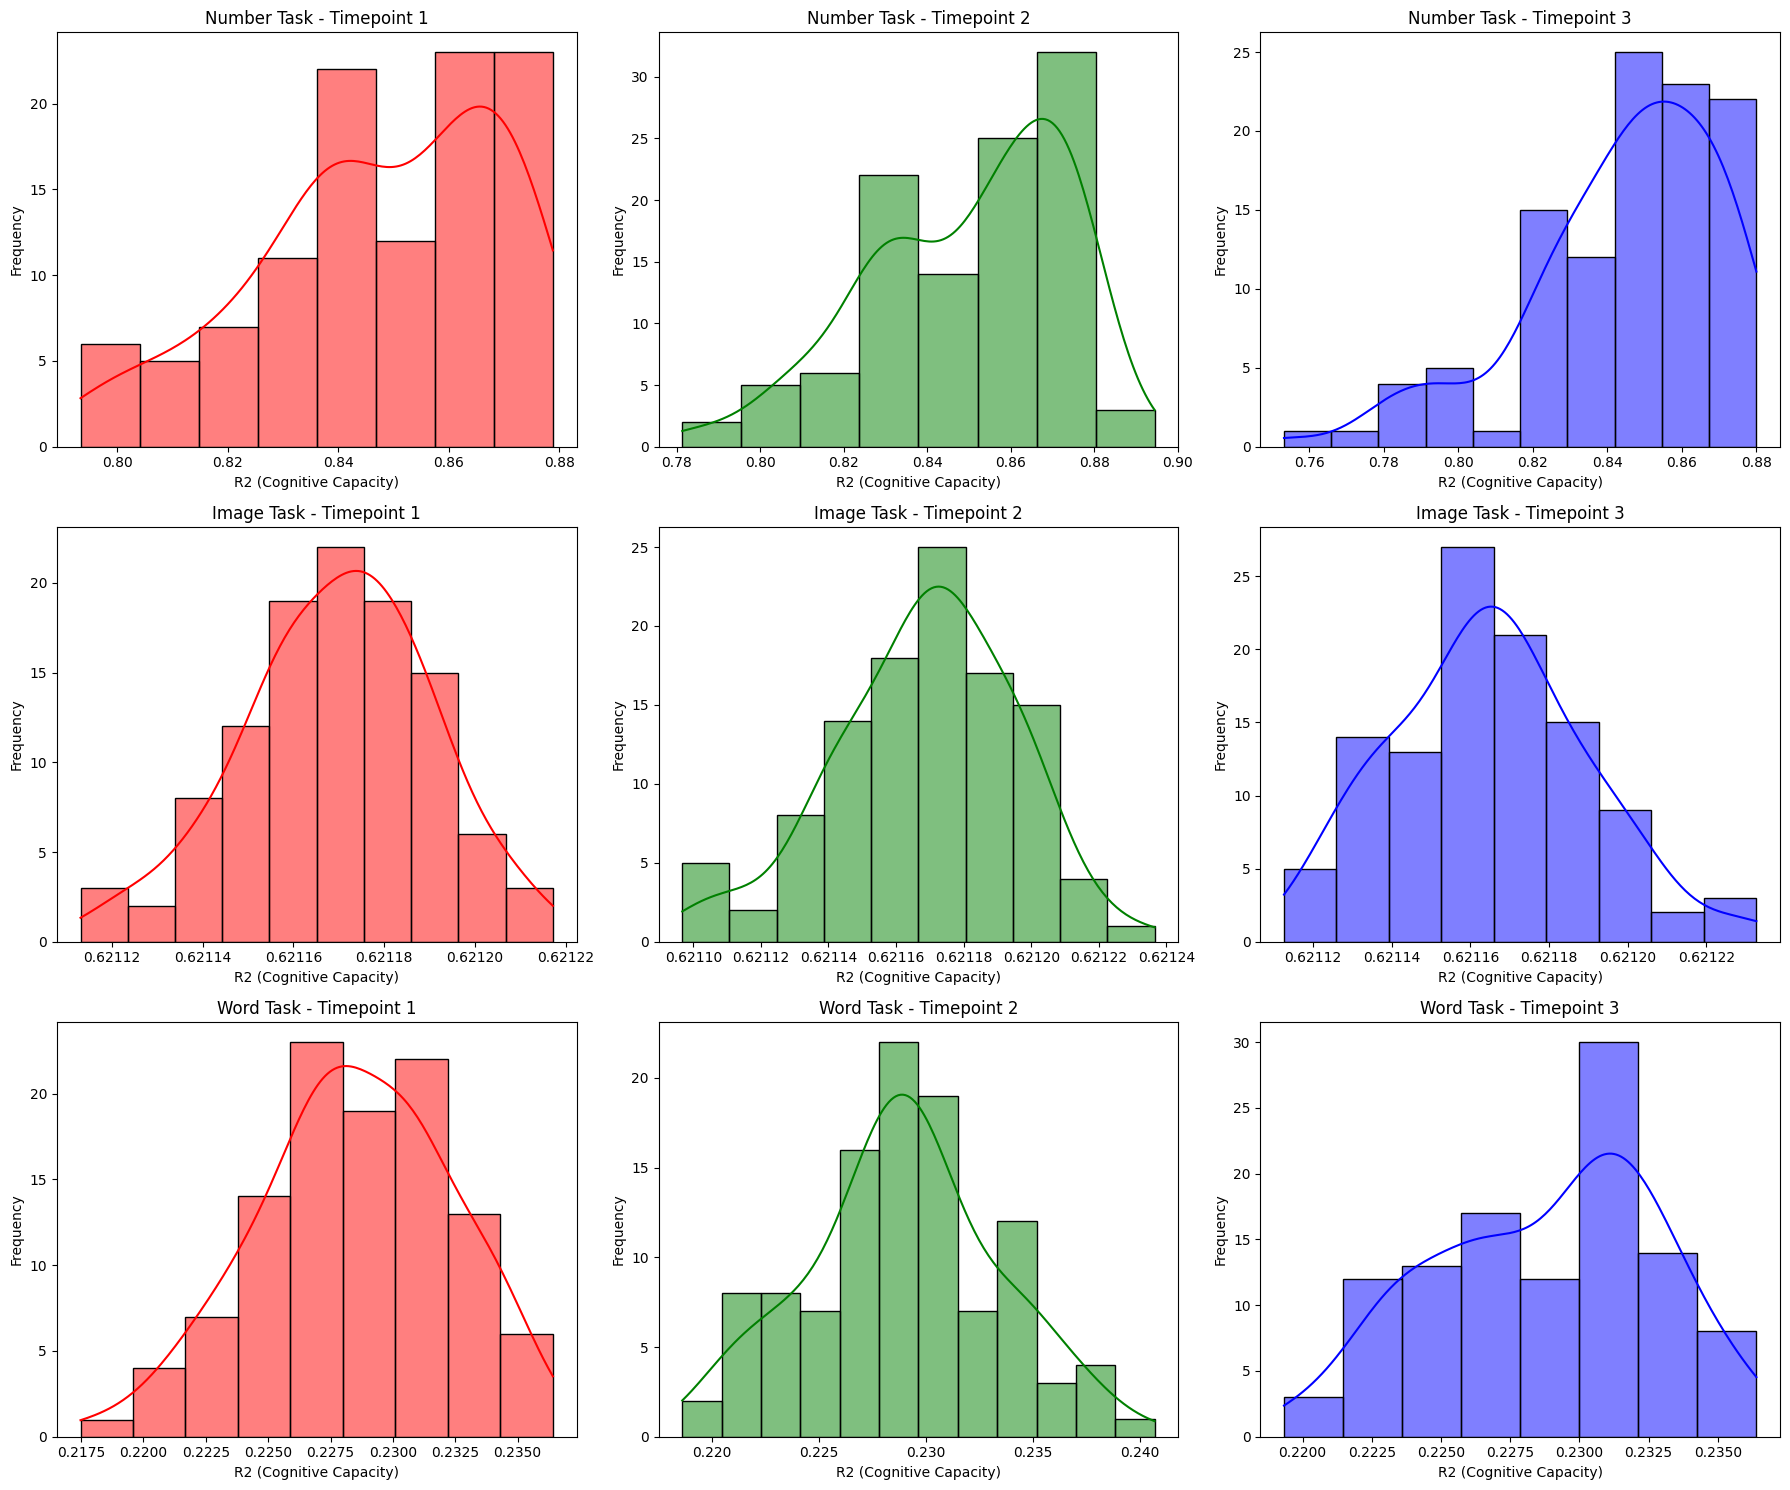

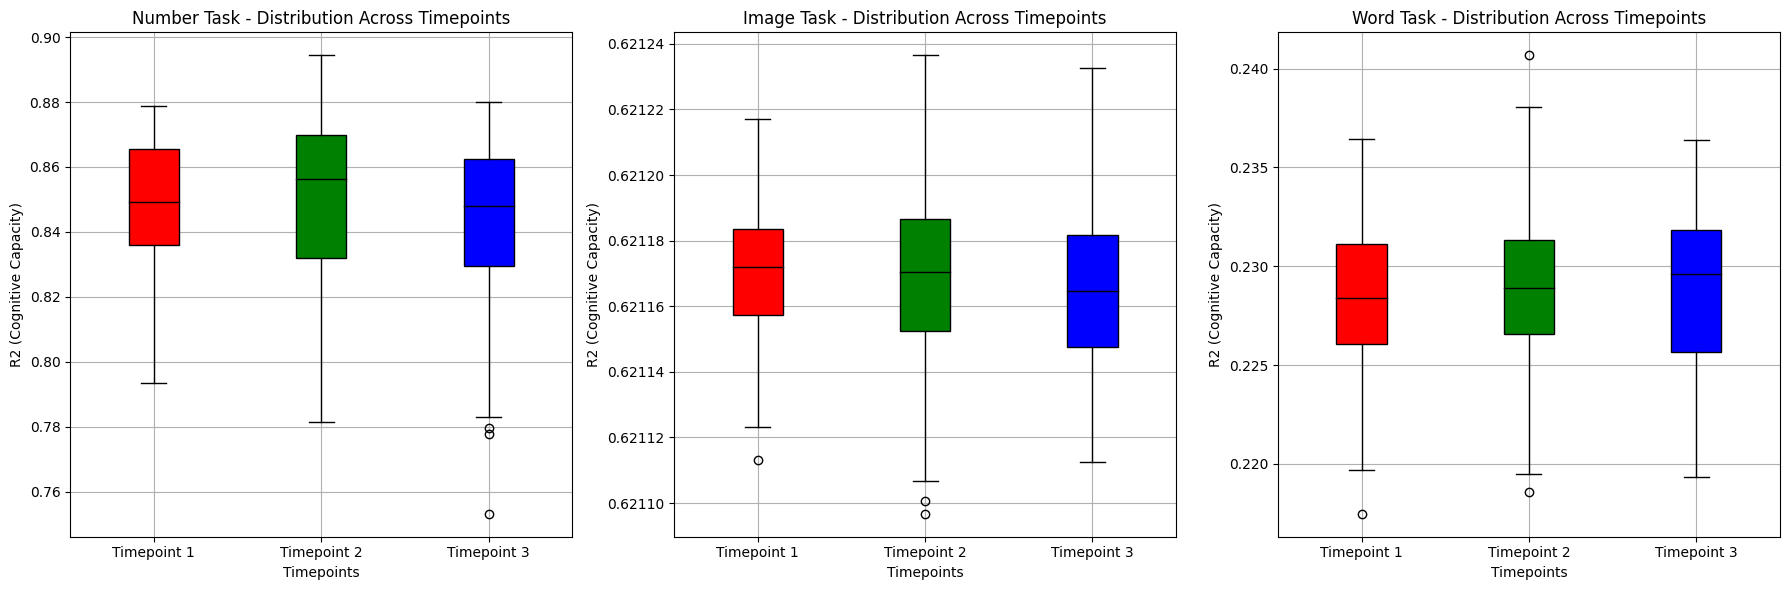

In [11]:
def cognitive_distribution_viz_r2(r2_df):
    # Define colors for each timepoint
    colors = ['red', 'green', 'blue']

    # Plot the cognitive capacity (MAE) distribution from each task and each timepoint
    fig, axs = plt.subplots(3, 3, figsize=(18, 15))
    tasks = ['Number', 'Image', 'Word']
    timepoints = ['Timepoint 1', 'Timepoint 2', 'Timepoint 3']

    for i, task in enumerate(tasks):
        for j, timepoint in enumerate(timepoints):
            data = r2_df[f'{task}_R2_{j+1}']
            sns.histplot(data, kde=True, ax=axs[i, j], color=colors[j])
            axs[i, j].set_title(f'{task} Task - {timepoint}')
            axs[i, j].set_xlabel('R2 (Cognitive Capacity)')
            axs[i, j].set_ylabel('Frequency')
            axs[i, j].grid(False)
            

    plt.tight_layout()
    plt.show()

    # Plot the distribution of cognitive property (memory capacity) using box plots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    for i, task in enumerate(tasks):
        data_to_plot = [r2_df[f'{task}_R2_{j+1}'] for j in range(3)]
        box = axs[i].boxplot(data_to_plot, patch_artist=True, medianprops=dict(color='black'))
        
        # Set the face color for each box
        for patch, color in zip(box['boxes'], colors):
            patch.set_facecolor(color)
        
        axs[i].set_title(f'{task} Task - Distribution Across Timepoints')
        axs[i].set_xticks([1, 2, 3])
        axs[i].set_xticklabels(timepoints)
        axs[i].set_xlabel('Timepoints')
        axs[i].set_ylabel('R2 (Cognitive Capacity)')
        axs[i].grid(True)

    plt.tight_layout()
    plt.show()


cognitive_distribution_viz_r2(slim160_r2_df)

#### MAE

In [14]:
def calculate_cognitive_capacity(dataset, num_nodes):
    # Initialize and test ESNs for each graph in the dataset
    mae_results = []
    reservoir_size = num_nodes

    for subject in range(dataset.shape[0]):
        subject_mae = []
        for timepoint in range(dataset.shape[1]):
            
            adjacency_matrix = dataset[subject, timepoint]
            
            # Calculate MAE for number sequence
            Win, Wres, bias = initialize_esn(adjacency_matrix, input_size=1, reservoir_size=reservoir_size, output_size=1)
            number_mae = calculate_mae(Win, Wres, bias, number_sequence, number_target)
            
            # Calculate MAE for MNIST sequence
            Win, Wres, bias = initialize_esn(adjacency_matrix, input_size=28*27, reservoir_size=reservoir_size, output_size=28*27)
            mnist_mae = calculate_mae(Win, Wres, bias, mnist_input, mnist_target, alpha=80)
            
            # Calculate MAE for Word2Vec sequence
            Win, Wres, bias = initialize_esn(adjacency_matrix, input_size=50, reservoir_size=reservoir_size, output_size=50)
            word_mae = calculate_mae(Win, Wres, bias, word_input, word_target, alpha=10)
            
            subject_mae.append((number_mae, mnist_mae, word_mae))
        print(f'calculating cognitive capacity of subject {subject+1}, results: {subject_mae[0]}')
        mae_results.append(subject_mae)

    # Convert results to a DataFrame for easier manipulation
    mae_df = pd.DataFrame(mae_results, columns=['Timepoint_1', 'Timepoint_2', 'Timepoint_3'])
    mae_df[['Number_MAE_1', 'Image_MAE_1', 'Word_MAE_1']] = pd.DataFrame(mae_df['Timepoint_1'].tolist())
    mae_df[['Number_MAE_2', 'Image_MAE_2', 'Word_MAE_2']] = pd.DataFrame(mae_df['Timepoint_2'].tolist())
    mae_df[['Number_MAE_3', 'Image_MAE_3', 'Word_MAE_3']] = pd.DataFrame(mae_df['Timepoint_3'].tolist())
    mae_df.drop(columns=['Timepoint_1', 'Timepoint_2', 'Timepoint_3'], inplace=True)

    # Calculate mean, max, min for each timepoint
    mean_mae = mae_df.mean()
    std_mae = mae_df.std()
    max_mae = mae_df.max()
    min_mae = mae_df.min()

    return mae_df, mean_mae, std_mae, max_mae, min_mae
    
def cognitive_distribution_viz(mae_df):
    # Define colors for each timepoint
    colors = ['red', 'green', 'blue']

    # Plot the cognitive capacity (MAE) distribution from each task and each timepoint
    fig, axs = plt.subplots(3, 3, figsize=(18, 15))
    tasks = ['Number', 'Image', 'Word']
    timepoints = ['Timepoint 1', 'Timepoint 2', 'Timepoint 3']

    for i, task in enumerate(tasks):
        for j, timepoint in enumerate(timepoints):
            data = mae_df[f'{task}_MAE_{j+1}']
            sns.histplot(data, kde=True, ax=axs[i, j], color=colors[j])
            axs[i, j].set_title(f'{task} Task - {timepoint}')
            axs[i, j].set_xlabel('MAE (Cognitive Capacity)')
            axs[i, j].set_ylabel('Frequency')
            axs[i, j].grid(False)
            

    plt.tight_layout()
    plt.show()

    # Plot the distribution of cognitive property (memory capacity) using box plots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    for i, task in enumerate(tasks):
        data_to_plot = [mae_df[f'{task}_MAE_{j+1}'] for j in range(3)]
        box = axs[i].boxplot(data_to_plot, patch_artist=True, medianprops=dict(color='black'))
        
        # Set the face color for each box
        for patch, color in zip(box['boxes'], colors):
            patch.set_facecolor(color)
        
        axs[i].set_title(f'{task} Task - Distribution Across Timepoints')
        axs[i].set_xticks([1, 2, 3])
        axs[i].set_xticklabels(timepoints)
        axs[i].set_xlabel('Timepoints')
        axs[i].set_ylabel('MAE (Cognitive Capacity)')
        axs[i].grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
slim160_mae_df, slim160_mean_mae,  slim160_std_mae, slim160_max_mae, slim160_min_mae = calculate_cognitive_capacity(slim160_cleaned, 160)
slim160_mae_df

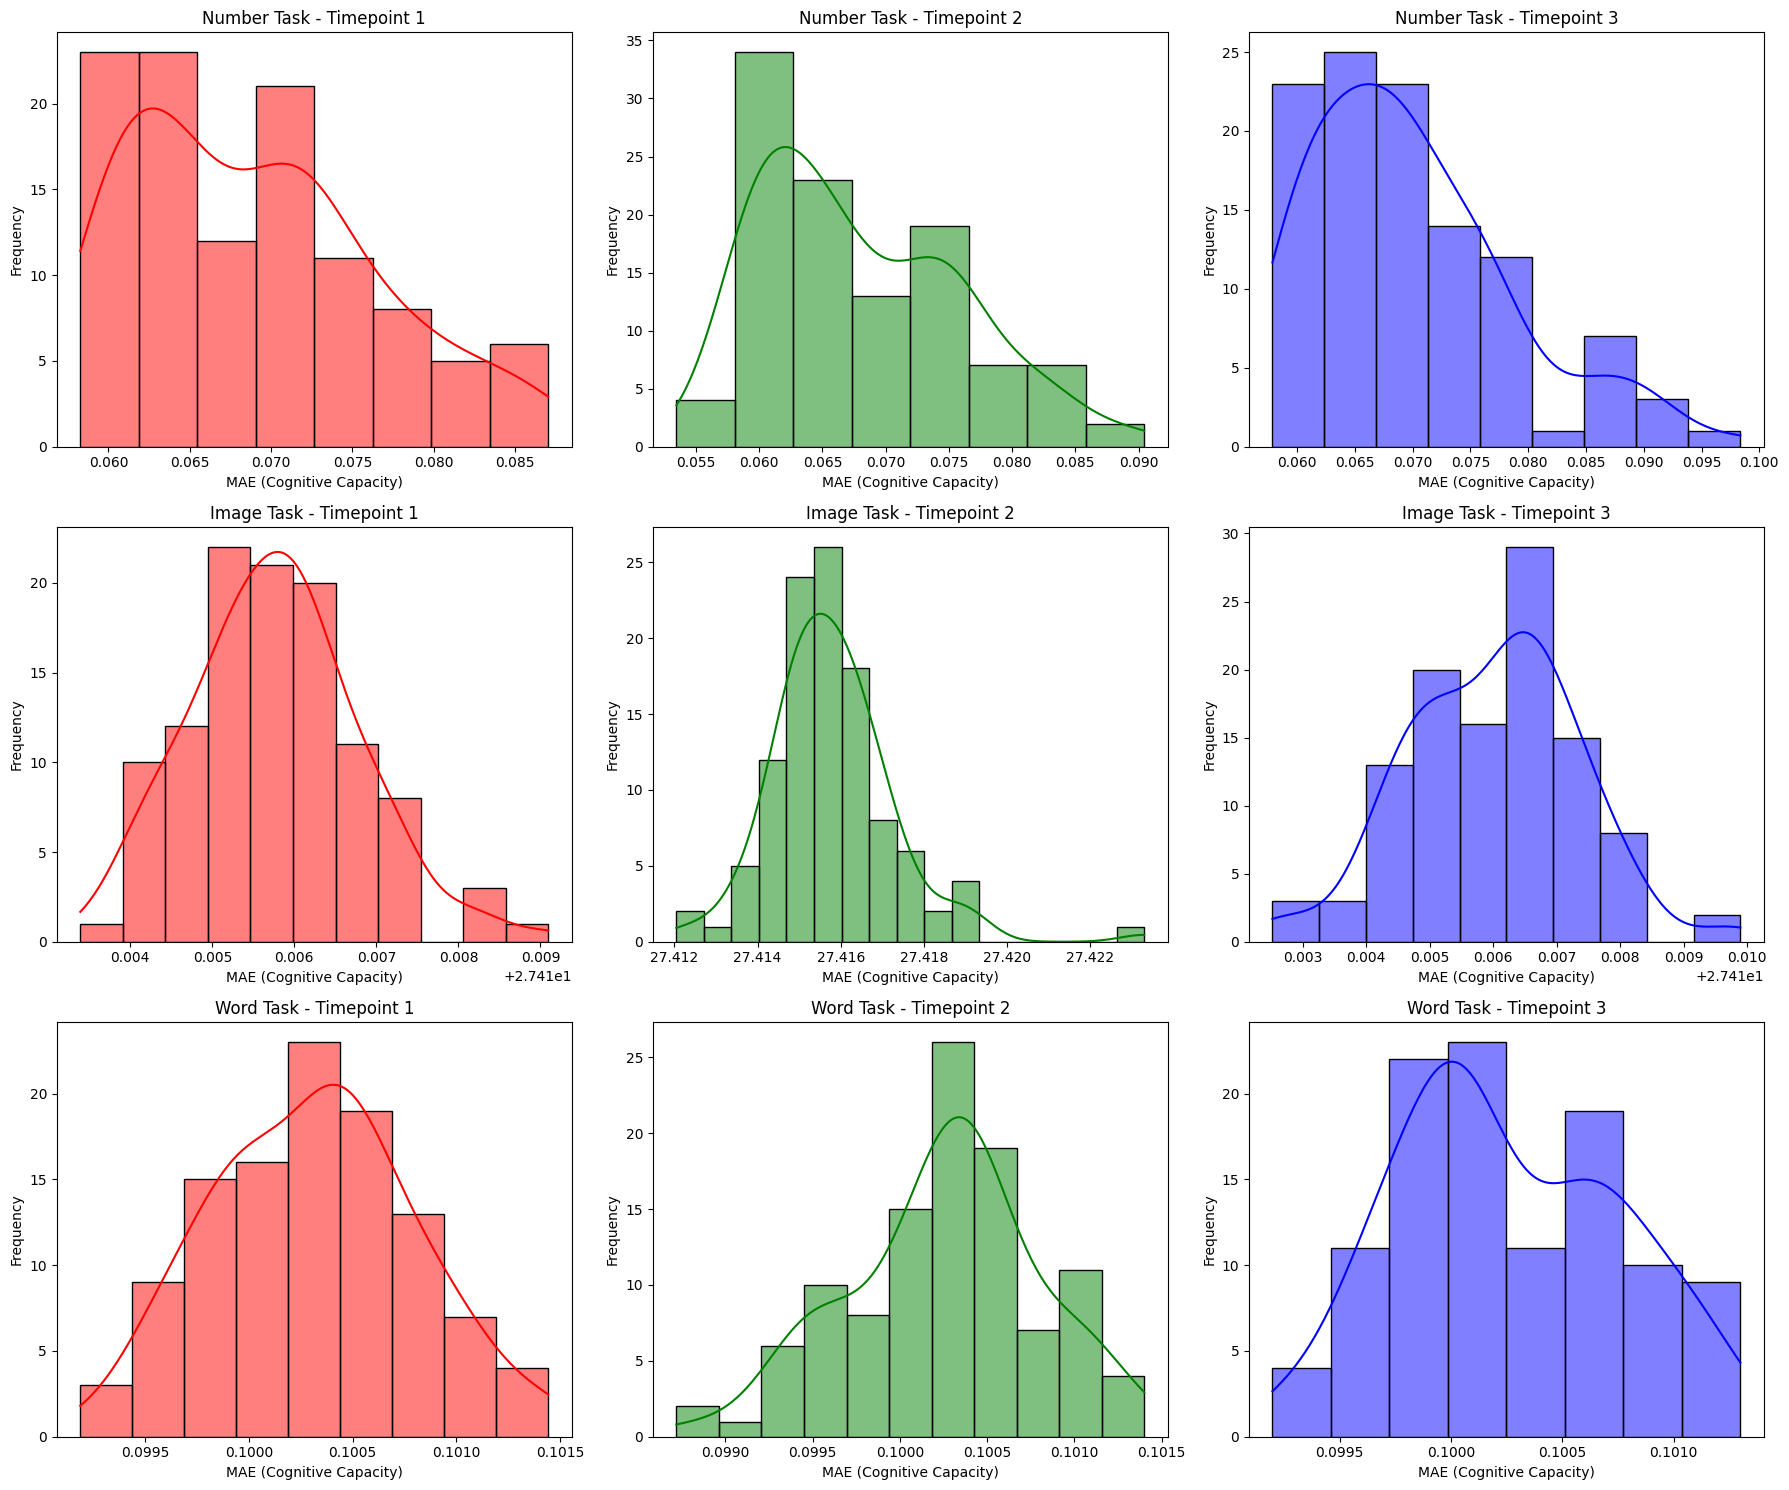

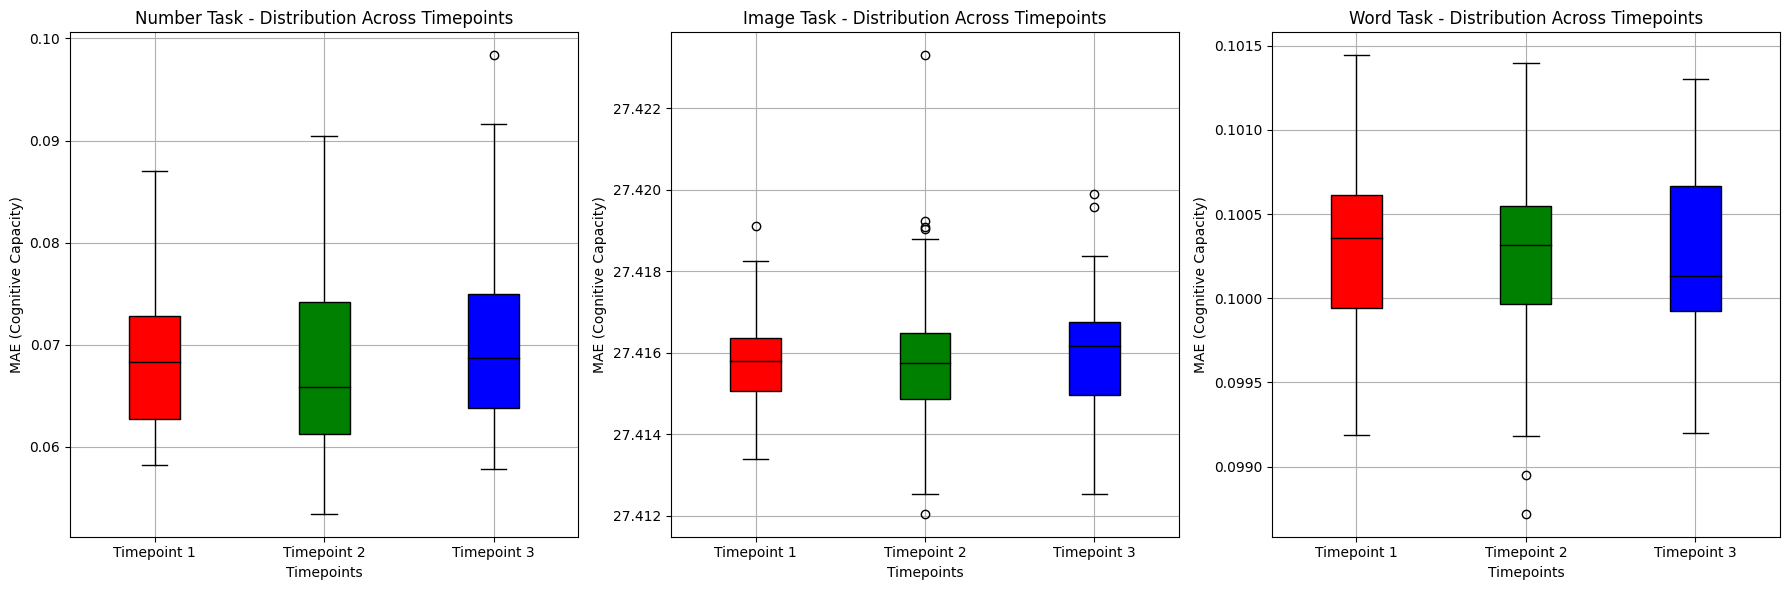

In [15]:
cognitive_distribution_viz(slim160_mae_df)

### SLIM Dataset (Subgraphs)

#### R-Square

In [24]:
import time
import pandas as pd
from joblib import Parallel, delayed


def process_subgraph_r2(subgraph_index, subgraph, generate_tasks_data, initialize_esn, calculate_r2):
    subgraph_size = subgraph.shape[0]
    (number_sequence, number_target), (mnist_input, mnist_target), (word_input, word_target) = generate_tasks_data()
    
    # Calculate R-squared for number sequence
    Win, Wres, bias = initialize_esn(subgraph, input_size=1, reservoir_size=subgraph_size, output_size=1)
    number_r2 = calculate_r2(Win, Wres, bias, number_sequence, number_target)
    
    # Calculate R-squared for MNIST sequence
    Win, Wres, bias = initialize_esn(subgraph, input_size=28*27, reservoir_size=subgraph_size, output_size=28*27)
    mnist_r2 = calculate_r2(Win, Wres, bias, mnist_input, mnist_target, alpha=80)
    
    # Calculate R-squared for Word2Vec sequence
    Win, Wres, bias = initialize_esn(subgraph, input_size=50, reservoir_size=subgraph_size, output_size=50, spectral_radius=0.9)
    word_r2 = calculate_r2(Win, Wres, bias, word_input, word_target, alpha=10)
    
    return subgraph_index, number_r2, mnist_r2, word_r2

def calculate_subgraphs_r2(all_subgraphs):
    r2_results = []
    subject_times = []

    for subject, timepoint, subgraphs in all_subgraphs:
        start_time = time.time()
        subgraph_data = [(i, subgraph, generate_tasks_data, initialize_esn, calculate_r2) for i, subgraph in enumerate(subgraphs)]
        
        results = Parallel(n_jobs=-1)(delayed(process_subgraph_r2)(i, subgraph, generate_tasks_data, initialize_esn, calculate_r2) for i, subgraph in enumerate(subgraphs))
        for subgraph_index, number_r2, mnist_r2, word_r2 in results:
            r2_results.append((subject, timepoint, subgraph_index, number_r2, mnist_r2, word_r2))
        subject_time = time.time() - start_time
        subject_times.append(subject_time)
        print(f"Subgraphs R2 of subject {subject+1} at timepoint {timepoint+1} results: {results[0]}")
        print(f"Time taken for subject {subject+1}: {subject_time:.2f} seconds")
    
    average_time = sum(subject_times) / len(subject_times)
    print(f"Average time taken across subjects: {average_time:.2f} seconds")

    return r2_results

subgraphs_r2_results = calculate_subgraphs_r2(slim160_subgraphs)
subgraphs_r2_df = pd.DataFrame(subgraphs_r2_results, columns=['Subject', 'Timepoint', 'Subgraph_Index', 'Number_R2', 'Image_R2', 'Word_R2'])
subgraphs_r2_df.to_csv('r2_df_subgraphs.csv')
subgraphs_r2_df

Subgraphs R2 of subject 1 at timepoint 1 results: (0, 0.7940548851605723, 0.5895555207765355, 0.20620447909543835)
Time taken for subject 1: 22.08 seconds
Subgraphs R2 of subject 1 at timepoint 2 results: (0, 0.8208115390613365, 0.604285307957287, 0.2180771457501403)
Time taken for subject 1: 14.28 seconds
Subgraphs R2 of subject 1 at timepoint 3 results: (0, 0.7309261533891969, 0.5605473854313864, 0.20066448754726351)
Time taken for subject 1: 14.95 seconds
Subgraphs R2 of subject 2 at timepoint 1 results: (0, 0.7941542735613385, 0.591251171786261, 0.2226854884683218)
Time taken for subject 2: 18.85 seconds
Subgraphs R2 of subject 2 at timepoint 2 results: (0, 0.7901706317385931, 0.5983345921586992, 0.22335415718316567)
Time taken for subject 2: 12.95 seconds
Subgraphs R2 of subject 2 at timepoint 3 results: (0, 0.6995036702505764, 0.5526431871283254, 0.1948979137376662)
Time taken for subject 2: 15.89 seconds
Subgraphs R2 of subject 3 at timepoint 1 results: (0, 0.765904277228384, 0.

/Users/gitaayusalsabila/anaconda3/envs/doc_task_env/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1272: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "
/var/folders/yj/7ftnh32d2v95yv_tqmcvkt0h0000gn/T/ipykernel_36529/2925840439.py:16: UserWarning: Largest eigenvalue is zero, skipping spectral radius adjustment.
/Users/gitaayusalsabila/anaconda3/envs/doc_task_env/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1272: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "
/var/folders/yj/7ftnh32d2v95yv_tqmcvkt0h0000gn/T/ipykernel_36529/2925840439.py:16: UserWarning: Largest eigenvalue is zero, skipping spectral radius adjustment.
/Users/gitaayusalsabila/anaconda3/envs/doc_task_env/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/arpack

Subgraphs R2 of subject 11 at timepoint 3 results: (0, 0.8191818816483962, 0.601688513324211, 0.22254288624907242)
Time taken for subject 11: 11.33 seconds
Subgraphs R2 of subject 12 at timepoint 1 results: (0, 0.8632046030147505, 0.6179097083988355, 0.21051989727614895)
Time taken for subject 12: 12.32 seconds
Subgraphs R2 of subject 12 at timepoint 2 results: (0, 0.8147684191005403, 0.6080002370574373, 0.20481354548992792)
Time taken for subject 12: 11.53 seconds
Subgraphs R2 of subject 12 at timepoint 3 results: (0, 0.8163449164403025, 0.6208041015078505, 0.21187802843270545)
Time taken for subject 12: 11.87 seconds
Subgraphs R2 of subject 13 at timepoint 1 results: (0, 0.794792454667233, 0.5983055814690245, 0.22107228854476443)
Time taken for subject 13: 11.18 seconds
Subgraphs R2 of subject 13 at timepoint 2 results: (0, 0.7421340264912364, 0.5486326840133279, 0.19025322120615296)
Time taken for subject 13: 11.27 seconds
Subgraphs R2 of subject 13 at timepoint 3 results: (0, 0.738

/Users/gitaayusalsabila/anaconda3/envs/doc_task_env/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1272: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "
/var/folders/yj/7ftnh32d2v95yv_tqmcvkt0h0000gn/T/ipykernel_36529/2925840439.py:16: UserWarning: Largest eigenvalue is zero, skipping spectral radius adjustment.
/Users/gitaayusalsabila/anaconda3/envs/doc_task_env/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1272: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "
/var/folders/yj/7ftnh32d2v95yv_tqmcvkt0h0000gn/T/ipykernel_36529/2925840439.py:16: UserWarning: Largest eigenvalue is zero, skipping spectral radius adjustment.
/Users/gitaayusalsabila/anaconda3/envs/doc_task_env/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/arpack

Subgraphs R2 of subject 33 at timepoint 2 results: (0, -0.5970393206093092, 0.33767540913509053, 0.09857527383053184)
Time taken for subject 33: 9.18 seconds
Subgraphs R2 of subject 33 at timepoint 3 results: (0, 0.7846691315652866, 0.5983173067873626, 0.22373483791605112)
Time taken for subject 33: 12.00 seconds
Subgraphs R2 of subject 34 at timepoint 1 results: (0, 0.777752338765316, 0.5950572300292415, 0.21298464935880485)
Time taken for subject 34: 11.59 seconds
Subgraphs R2 of subject 34 at timepoint 2 results: (0, 0.725918094482901, 0.5392614887277005, 0.18084196788093723)
Time taken for subject 34: 11.83 seconds
Subgraphs R2 of subject 34 at timepoint 3 results: (0, 0.8175670911372148, 0.6031505797767855, 0.21591964716759637)
Time taken for subject 34: 11.62 seconds
Subgraphs R2 of subject 35 at timepoint 1 results: (0, 0.7788766631140676, 0.596810717084171, 0.22854442121597685)
Time taken for subject 35: 11.47 seconds
Subgraphs R2 of subject 35 at timepoint 2 results: (0, 0.805

/Users/gitaayusalsabila/anaconda3/envs/doc_task_env/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1272: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "
/Users/gitaayusalsabila/anaconda3/envs/doc_task_env/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1272: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "
/var/folders/yj/7ftnh32d2v95yv_tqmcvkt0h0000gn/T/ipykernel_36529/2925840439.py:16: UserWarning: Largest eigenvalue is zero, skipping spectral radius adjustment.
/var/folders/yj/7ftnh32d2v95yv_tqmcvkt0h0000gn/T/ipykernel_36529/2925840439.py:16: UserWarning: Largest eigenvalue is zero, skipping spectral radius adjustment.
/Users/gitaayusalsabila/anaconda3/envs/doc_task_env/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/arpack

Subgraphs R2 of subject 74 at timepoint 2 results: (0, -15.668479030676139, 0.07616667054321787, -0.06721606589836543)
Time taken for subject 74: 8.91 seconds
Subgraphs R2 of subject 74 at timepoint 3 results: (0, 0.7377531577880966, 0.5736872547923243, 0.20450342523950094)
Time taken for subject 74: 11.50 seconds
Subgraphs R2 of subject 75 at timepoint 1 results: (0, 0.7731824072300436, 0.5916769557362278, 0.2153118592208524)
Time taken for subject 75: 10.99 seconds
Subgraphs R2 of subject 75 at timepoint 2 results: (0, 0.8117764624024477, 0.6016118515446124, 0.21684206679858523)
Time taken for subject 75: 10.99 seconds
Subgraphs R2 of subject 75 at timepoint 3 results: (0, 0.7397117364230783, 0.5676295076257482, 0.2153250549889868)
Time taken for subject 75: 10.88 seconds
Subgraphs R2 of subject 76 at timepoint 1 results: (0, 0.8373270639387501, 0.6208230551156435, 0.2152025934867903)
Time taken for subject 76: 11.71 seconds
Subgraphs R2 of subject 76 at timepoint 2 results: (0, 0.73

/Users/gitaayusalsabila/anaconda3/envs/doc_task_env/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1272: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "
/var/folders/yj/7ftnh32d2v95yv_tqmcvkt0h0000gn/T/ipykernel_36529/2925840439.py:16: UserWarning: Largest eigenvalue is zero, skipping spectral radius adjustment.
/Users/gitaayusalsabila/anaconda3/envs/doc_task_env/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1272: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "
/var/folders/yj/7ftnh32d2v95yv_tqmcvkt0h0000gn/T/ipykernel_36529/2925840439.py:16: UserWarning: Largest eigenvalue is zero, skipping spectral radius adjustment.
/Users/gitaayusalsabila/anaconda3/envs/doc_task_env/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/arpack

Subgraphs R2 of subject 79 at timepoint 2 results: (0, 0.7889862239766031, 0.5916674180632324, 0.2162465369060147)
Time taken for subject 79: 11.32 seconds
Subgraphs R2 of subject 79 at timepoint 3 results: (0, 0.8191593807280477, 0.6057910788289068, 0.22774713472470606)
Time taken for subject 79: 11.69 seconds
Subgraphs R2 of subject 80 at timepoint 1 results: (0, 0.8262393381143955, 0.618415104032356, 0.21758214297111003)
Time taken for subject 80: 11.26 seconds
Subgraphs R2 of subject 80 at timepoint 2 results: (0, 0.8283431492507233, 0.6150502926414555, 0.22651682843736132)
Time taken for subject 80: 11.56 seconds
Subgraphs R2 of subject 80 at timepoint 3 results: (0, 0.7990021286417714, 0.5973865856689318, 0.1981539761544904)
Time taken for subject 80: 11.13 seconds
Subgraphs R2 of subject 81 at timepoint 1 results: (0, 0.8629670813092633, 0.6173669298732115, 0.21854274722886213)
Time taken for subject 81: 11.65 seconds
Subgraphs R2 of subject 81 at timepoint 2 results: (0, 0.7737

/Users/gitaayusalsabila/anaconda3/envs/doc_task_env/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1272: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "
/var/folders/yj/7ftnh32d2v95yv_tqmcvkt0h0000gn/T/ipykernel_36529/2925840439.py:16: UserWarning: Largest eigenvalue is zero, skipping spectral radius adjustment.
/Users/gitaayusalsabila/anaconda3/envs/doc_task_env/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1272: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "
/var/folders/yj/7ftnh32d2v95yv_tqmcvkt0h0000gn/T/ipykernel_36529/2925840439.py:16: UserWarning: Largest eigenvalue is zero, skipping spectral radius adjustment.
/Users/gitaayusalsabila/anaconda3/envs/doc_task_env/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/arpack

Subgraphs R2 of subject 90 at timepoint 2 results: (0, -1.5219640556618272, 0.24958874990926683, 0.06226783446960714)
Time taken for subject 90: 8.91 seconds
Subgraphs R2 of subject 90 at timepoint 3 results: (0, 0.7981106746981601, 0.5895365435220274, 0.21568790473334296)
Time taken for subject 90: 11.66 seconds
Subgraphs R2 of subject 91 at timepoint 1 results: (0, 0.8226204217181451, 0.614466937078858, 0.22124934613640593)
Time taken for subject 91: 11.39 seconds
Subgraphs R2 of subject 91 at timepoint 2 results: (0, 0.810428738699866, 0.6039265672195575, 0.21297435485607374)
Time taken for subject 91: 11.14 seconds
Subgraphs R2 of subject 91 at timepoint 3 results: (0, 0.7191285701273863, 0.5334446441193051, 0.16966410477013846)
Time taken for subject 91: 11.18 seconds
Subgraphs R2 of subject 92 at timepoint 1 results: (0, 0.7407062090391965, 0.5676267886039017, 0.2084697421680447)
Time taken for subject 92: 11.14 seconds
Subgraphs R2 of subject 92 at timepoint 2 results: (0, 0.790

/Users/gitaayusalsabila/anaconda3/envs/doc_task_env/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1272: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "
/Users/gitaayusalsabila/anaconda3/envs/doc_task_env/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1272: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "
/var/folders/yj/7ftnh32d2v95yv_tqmcvkt0h0000gn/T/ipykernel_36529/2925840439.py:16: UserWarning: Largest eigenvalue is zero, skipping spectral radius adjustment.
/var/folders/yj/7ftnh32d2v95yv_tqmcvkt0h0000gn/T/ipykernel_36529/2925840439.py:16: UserWarning: Largest eigenvalue is zero, skipping spectral radius adjustment.
/Users/gitaayusalsabila/anaconda3/envs/doc_task_env/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/arpack

Subgraphs R2 of subject 98 at timepoint 2 results: (0, 0.8341751698843232, 0.6078856208156657, 0.21691277626758357)
Time taken for subject 98: 11.84 seconds
Subgraphs R2 of subject 98 at timepoint 3 results: (0, 0.8024729727609896, 0.6057536777458504, 0.22113132224406618)
Time taken for subject 98: 12.57 seconds
Subgraphs R2 of subject 99 at timepoint 1 results: (0, 0.8169325643762895, 0.6016899706890606, 0.21275736448855667)
Time taken for subject 99: 11.82 seconds
Subgraphs R2 of subject 99 at timepoint 2 results: (0, 0.7518705772299399, 0.5475549573730094, 0.19558016438360482)
Time taken for subject 99: 13.11 seconds
Subgraphs R2 of subject 99 at timepoint 3 results: (0, 0.7909836909910528, 0.5911662997985463, 0.2190914113144575)
Time taken for subject 99: 11.81 seconds
Subgraphs R2 of subject 100 at timepoint 1 results: (0, 0.79283694809267, 0.5975734233954783, 0.2216371603889989)
Time taken for subject 100: 11.45 seconds
Subgraphs R2 of subject 100 at timepoint 2 results: (0, 0.77

/Users/gitaayusalsabila/anaconda3/envs/doc_task_env/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1272: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "
/var/folders/yj/7ftnh32d2v95yv_tqmcvkt0h0000gn/T/ipykernel_36529/2925840439.py:16: UserWarning: Largest eigenvalue is zero, skipping spectral radius adjustment.
/Users/gitaayusalsabila/anaconda3/envs/doc_task_env/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1272: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "
/var/folders/yj/7ftnh32d2v95yv_tqmcvkt0h0000gn/T/ipykernel_36529/2925840439.py:16: UserWarning: Largest eigenvalue is zero, skipping spectral radius adjustment.
/Users/gitaayusalsabila/anaconda3/envs/doc_task_env/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/arpack

Subgraphs R2 of subject 104 at timepoint 2 results: (0, -15.668479030676139, 0.07616667054321787, -0.06721606589836543)
Time taken for subject 104: 9.62 seconds


/Users/gitaayusalsabila/anaconda3/envs/doc_task_env/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1272: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "
/var/folders/yj/7ftnh32d2v95yv_tqmcvkt0h0000gn/T/ipykernel_36529/2925840439.py:16: UserWarning: Largest eigenvalue is zero, skipping spectral radius adjustment.
/Users/gitaayusalsabila/anaconda3/envs/doc_task_env/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1272: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "
/var/folders/yj/7ftnh32d2v95yv_tqmcvkt0h0000gn/T/ipykernel_36529/2925840439.py:16: UserWarning: Largest eigenvalue is zero, skipping spectral radius adjustment.
/Users/gitaayusalsabila/anaconda3/envs/doc_task_env/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/arpack

Subgraphs R2 of subject 104 at timepoint 3 results: (0, -15.668479030676139, 0.07616667054321787, -0.06721606589836543)
Time taken for subject 104: 14.85 seconds
Subgraphs R2 of subject 105 at timepoint 1 results: (0, 0.836381816402146, 0.6185376843623861, 0.21482165263185987)
Time taken for subject 105: 12.32 seconds
Subgraphs R2 of subject 105 at timepoint 2 results: (0, 0.7194989510934482, 0.5485717786317744, 0.1876246101682479)
Time taken for subject 105: 12.55 seconds
Subgraphs R2 of subject 105 at timepoint 3 results: (0, 0.8391902569680108, 0.6198844871297843, 0.20787804867243057)
Time taken for subject 105: 12.84 seconds
Subgraphs R2 of subject 106 at timepoint 1 results: (0, 0.8136150537071026, 0.6039833533975763, 0.18269270891859846)
Time taken for subject 106: 13.13 seconds
Subgraphs R2 of subject 106 at timepoint 2 results: (0, 0.7884068058144533, 0.5974392290191334, 0.22332162308449302)
Time taken for subject 106: 13.11 seconds
Subgraphs R2 of subject 106 at timepoint 3 re

Subject  Timepoint  Subgraph_Index  Number_R2  Image_R2   Word_R2
0            0          0               0   0.794055  0.589556  0.206204
1            0          0               1   0.733406  0.552626  0.188499
2            0          0               2   0.743196  0.548599  0.182210
3            0          0               3   0.834562  0.612895  0.214403
4            0          0               4   0.797064  0.591269  0.213478
...        ...        ...             ...        ...       ...       ...
52315      108          2             155   0.828791  0.601330  0.206029
52316      108          2             156   0.774445  0.605743  0.208456
52317      108          2             157   0.800165  0.601408  0.200464
52318      108          2             158   0.797469  0.605755  0.209478
52319      108          2             159   0.817560  0.604655  0.215531

[52320 rows x 6 columns]

In [25]:
# Calculate the mean and standard deviation of MAE values for each subgraph index in each timepoint across all subjects
r2_stats = subgraphs_r2_df.groupby(['Timepoint', 'Subgraph_Index']).agg(
    Number_R2_mean=('Number_R2', 'mean'),
    Number_R2_std=('Number_R2', 'std'),
    Image_R2_mean=('Image_R2', 'mean'),
    Image_R2_std=('Image_R2', 'std'),
    Word_R2_mean=('Word_R2', 'mean'),
    Word_R2_std=('Word_R2', 'std')
).reset_index()

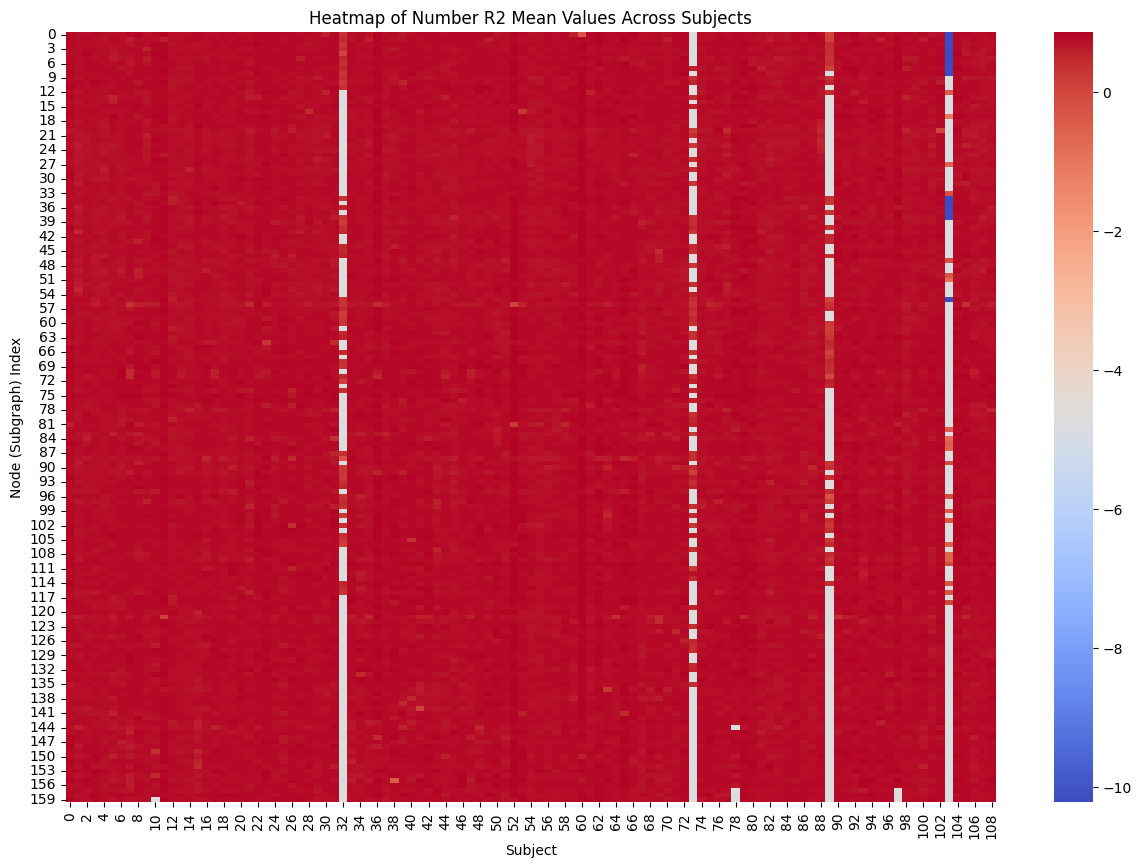

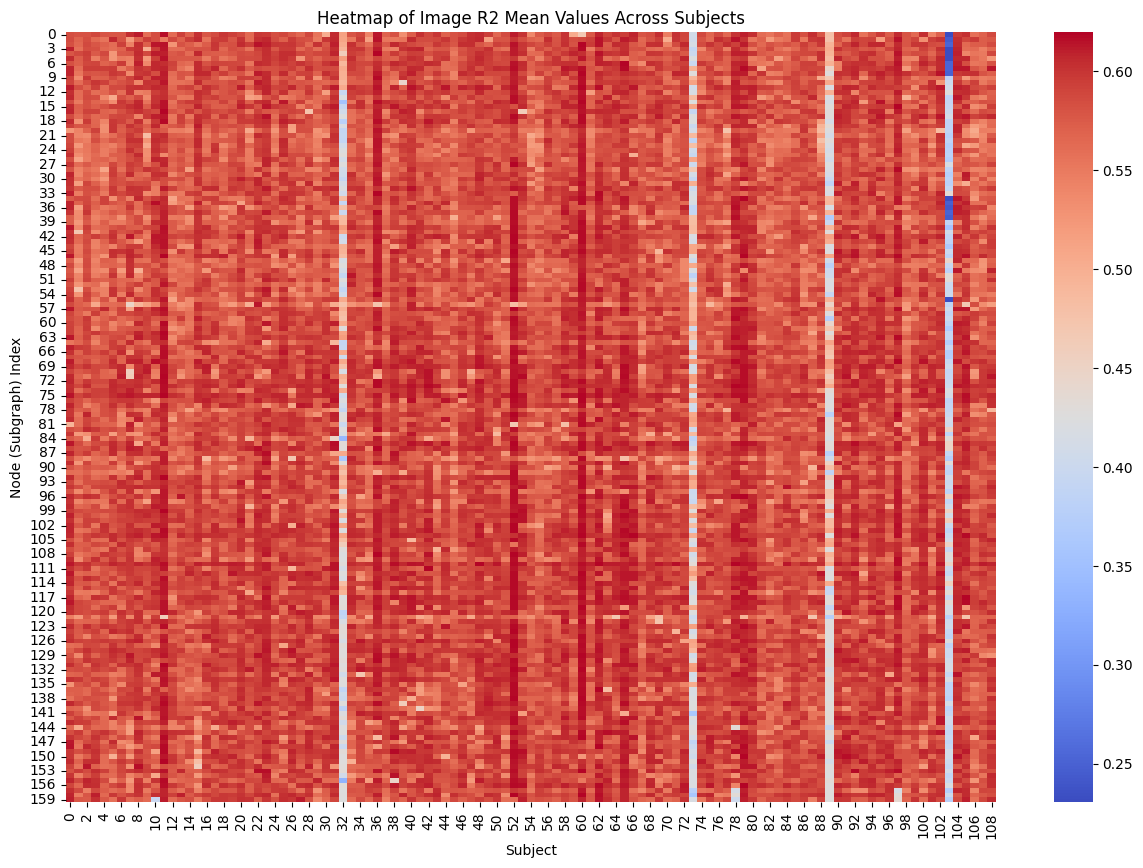

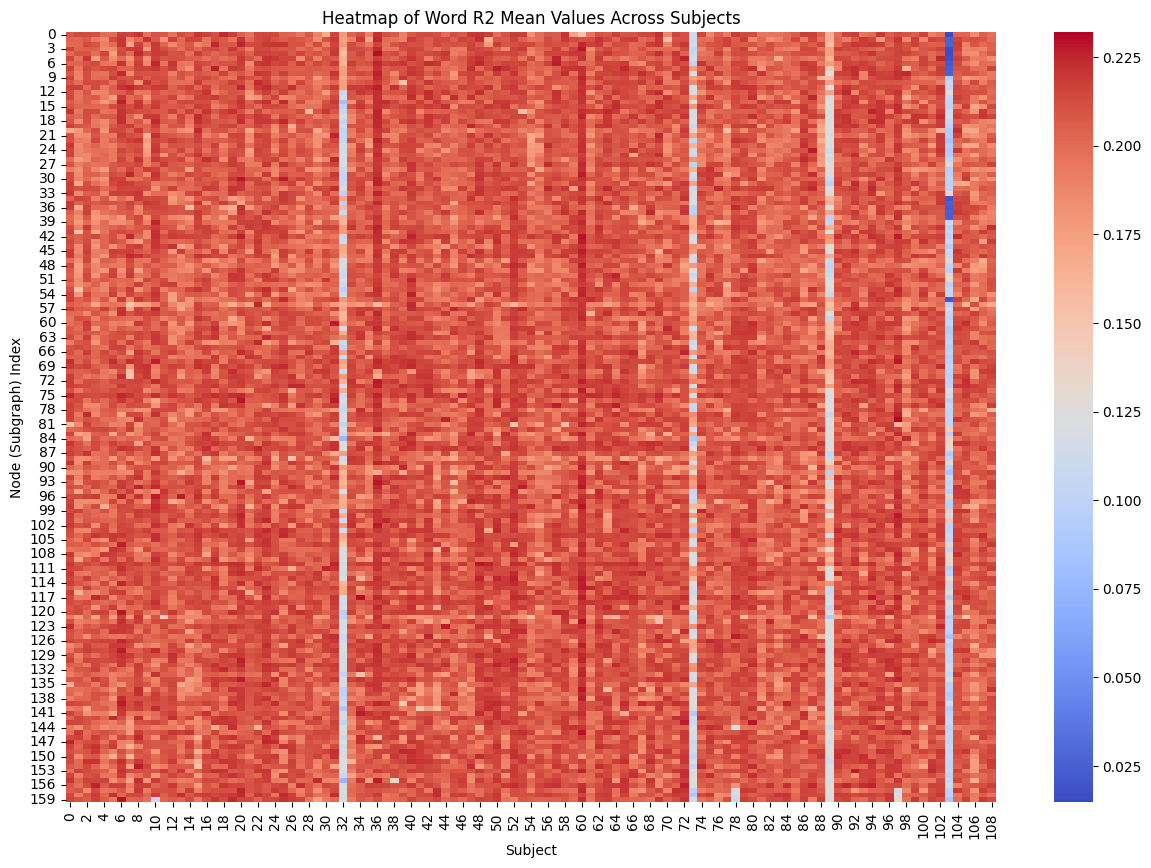

In [26]:
# Create heatmaps to represent the mean R2 values for each subgraph index across different tasks and timepoints
mean_r2_pivot = subgraphs_r2_df.pivot_table(index='Subgraph_Index', columns='Subject', values='Number_R2', aggfunc='mean')
plt.figure(figsize=(15, 10))
sns.heatmap(mean_r2_pivot, annot=False, cmap='coolwarm')
plt.title('Heatmap of Number R2 Mean Values Across Subjects')
plt.xlabel('Subject')
plt.ylabel('Node (Subgraph) Index')
plt.show()

mean_r2_pivot = subgraphs_r2_df.pivot_table(index='Subgraph_Index', columns='Subject', values='Image_R2', aggfunc='mean')
plt.figure(figsize=(15, 10))
sns.heatmap(mean_r2_pivot, annot=False, cmap='coolwarm')
plt.title('Heatmap of Image R2 Mean Values Across Subjects')
plt.xlabel('Subject')
plt.ylabel('Node (Subgraph) Index')
plt.show()

mean_r2_pivot = subgraphs_r2_df.pivot_table(index='Subgraph_Index', columns='Subject', values='Word_R2', aggfunc='mean')
plt.figure(figsize=(15, 10))
sns.heatmap(mean_r2_pivot, annot=False, cmap='coolwarm')
plt.title('Heatmap of Word R2 Mean Values Across Subjects')
plt.xlabel('Subject')
plt.ylabel('Node (Subgraph) Index')
plt.show()

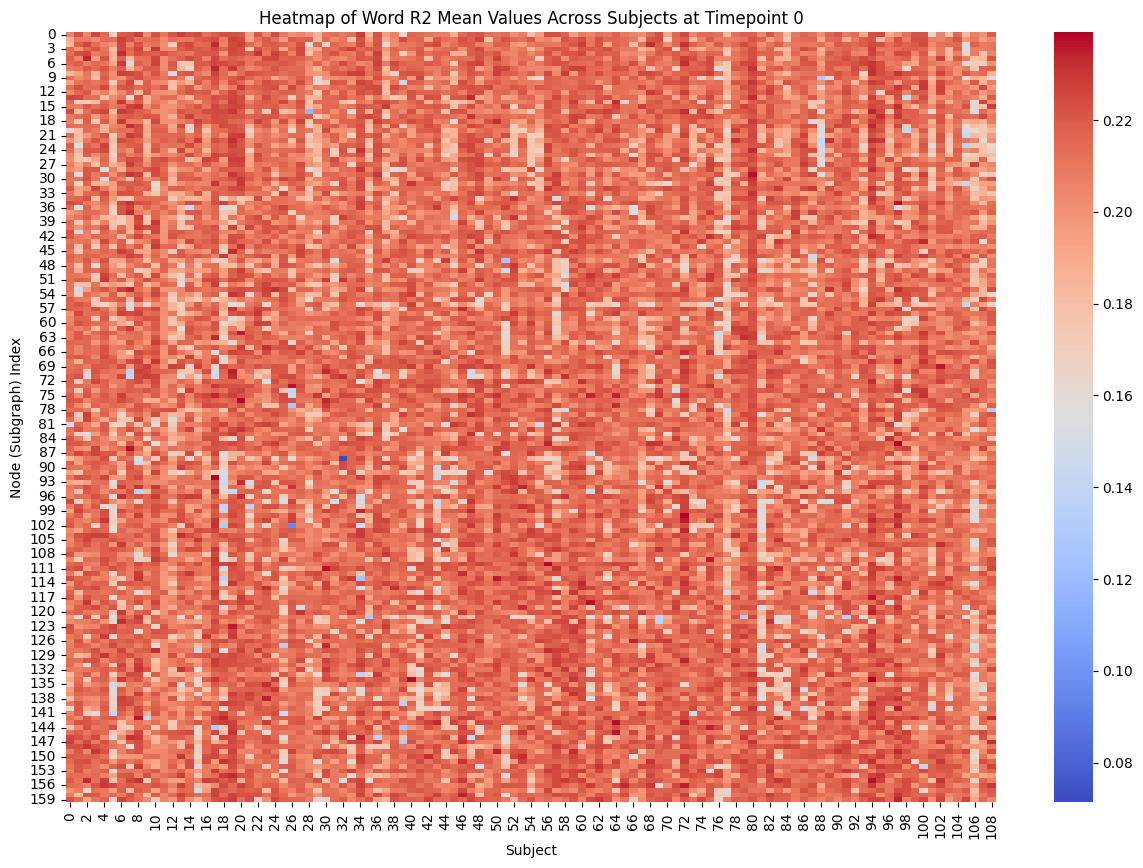

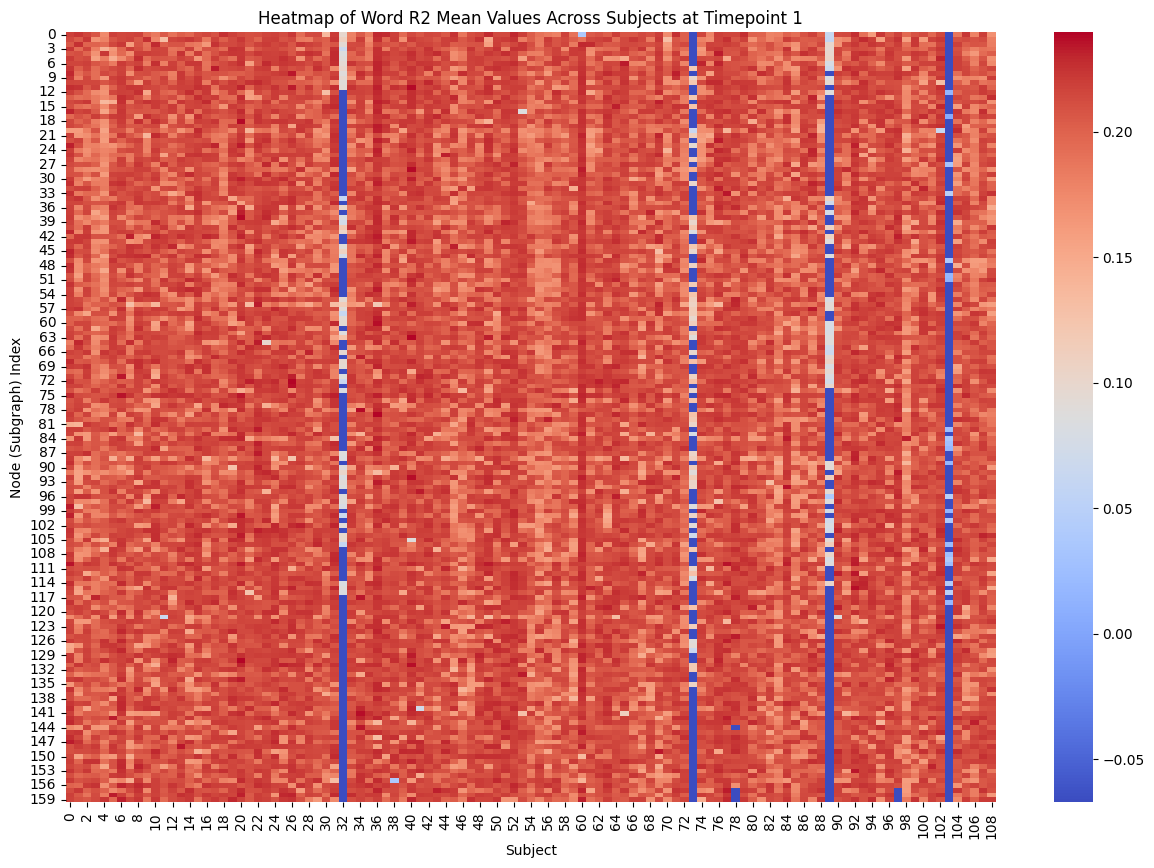

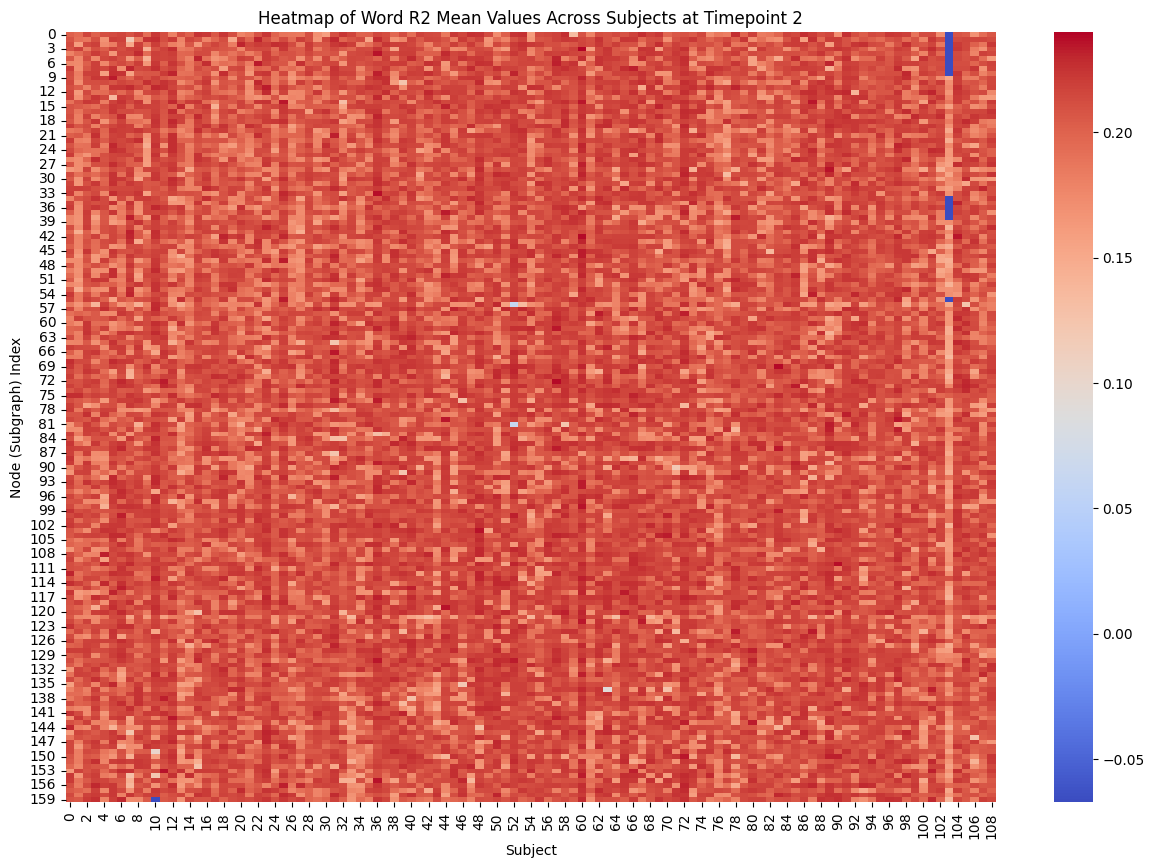

In [28]:
filtered_df = subgraphs_r2_df[subgraphs_r2_df['Timepoint'] == 0]
mean_r2_pivot = filtered_df.pivot_table(index='Subgraph_Index', columns='Subject', values='Word_R2', aggfunc='mean')
plt.figure(figsize=(15, 10))
sns.heatmap(mean_r2_pivot, annot=False, cmap='coolwarm')
plt.title(f'Heatmap of Word R2 Mean Values Across Subjects at Timepoint {0}')
plt.xlabel('Subject')
plt.ylabel('Node (Subgraph) Index')
plt.show()

filtered_df = subgraphs_r2_df[subgraphs_r2_df['Timepoint'] == 1]
mean_r2_pivot = filtered_df.pivot_table(index='Subgraph_Index', columns='Subject', values='Word_R2', aggfunc='mean')
plt.figure(figsize=(15, 10))
sns.heatmap(mean_r2_pivot, annot=False, cmap='coolwarm')
plt.title(f'Heatmap of Word R2 Mean Values Across Subjects at Timepoint {1}')
plt.xlabel('Subject')
plt.ylabel('Node (Subgraph) Index')
plt.show()

filtered_df = subgraphs_r2_df[subgraphs_r2_df['Timepoint'] == 2]
mean_r2_pivot = filtered_df.pivot_table(index='Subgraph_Index', columns='Subject', values='Word_R2', aggfunc='mean')
plt.figure(figsize=(15, 10))
sns.heatmap(mean_r2_pivot, annot=False, cmap='coolwarm')
plt.title(f'Heatmap of Word R2 Mean Values Across Subjects at Timepoint {2}')
plt.xlabel('Subject')
plt.ylabel('Node (Subgraph) Index')
plt.show()

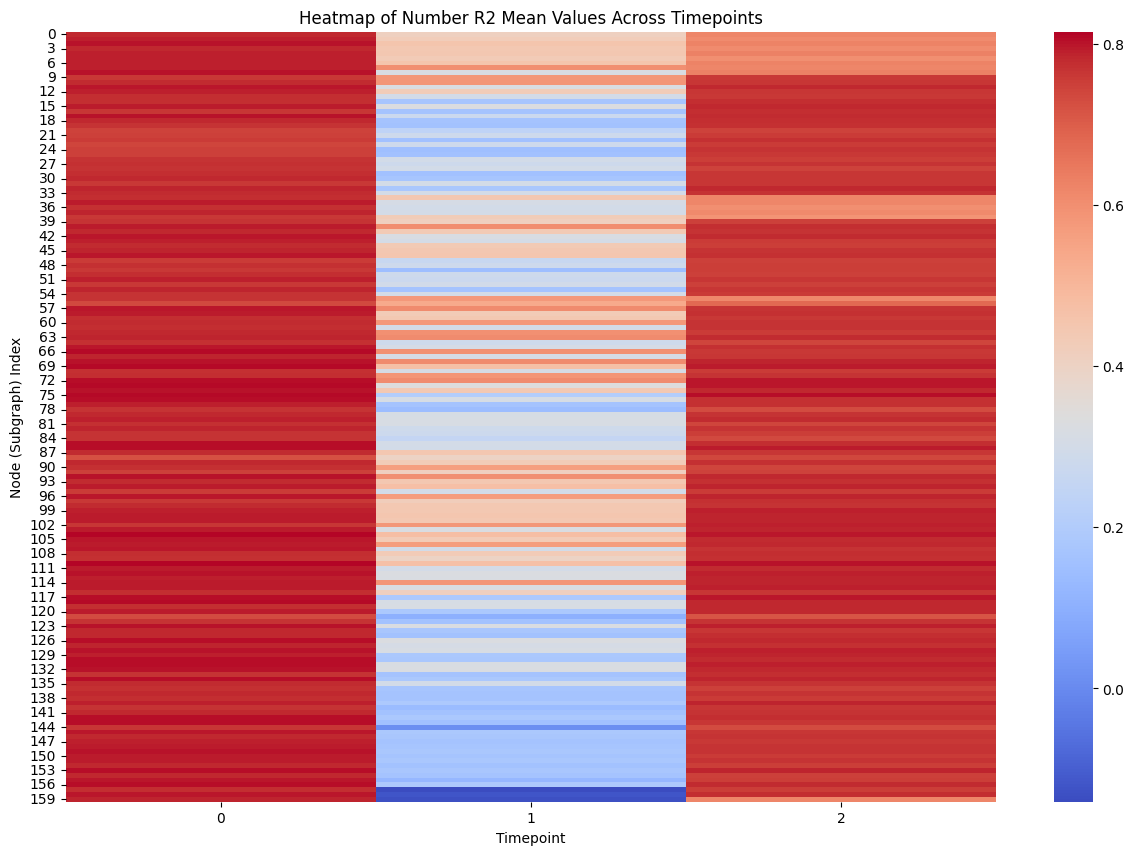

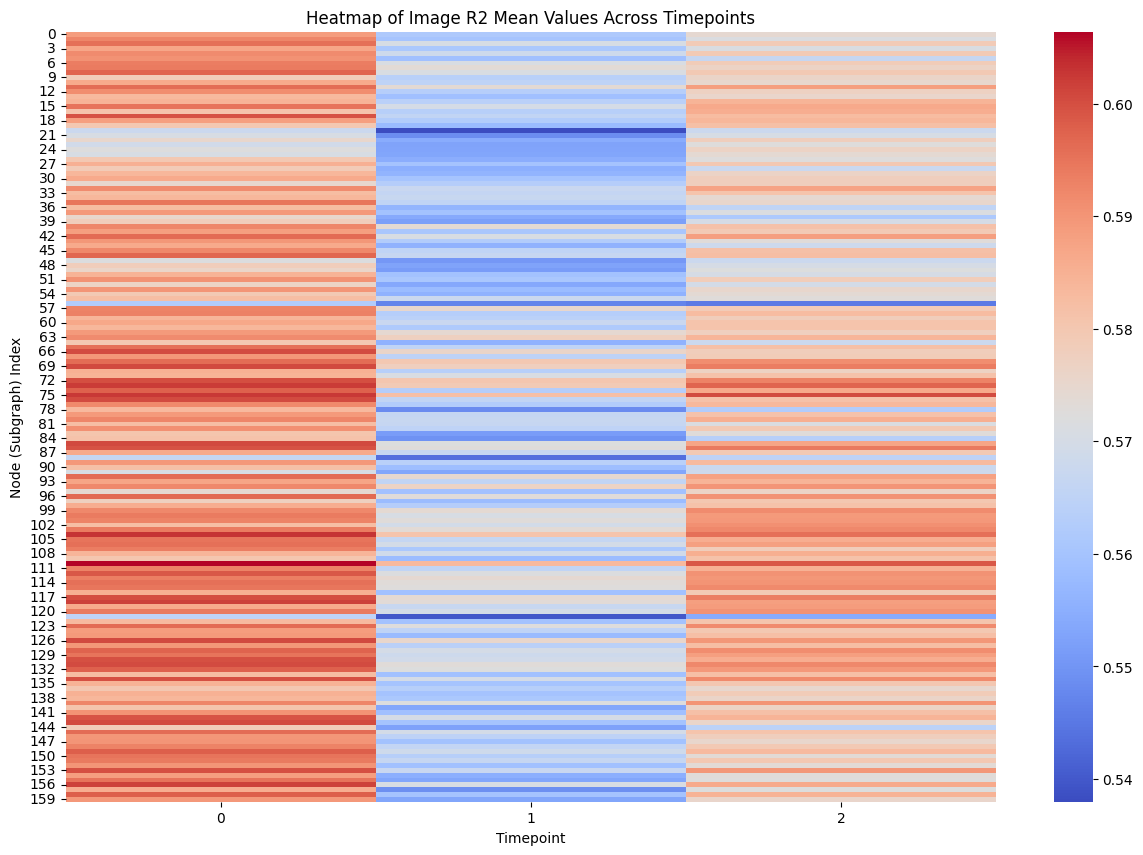

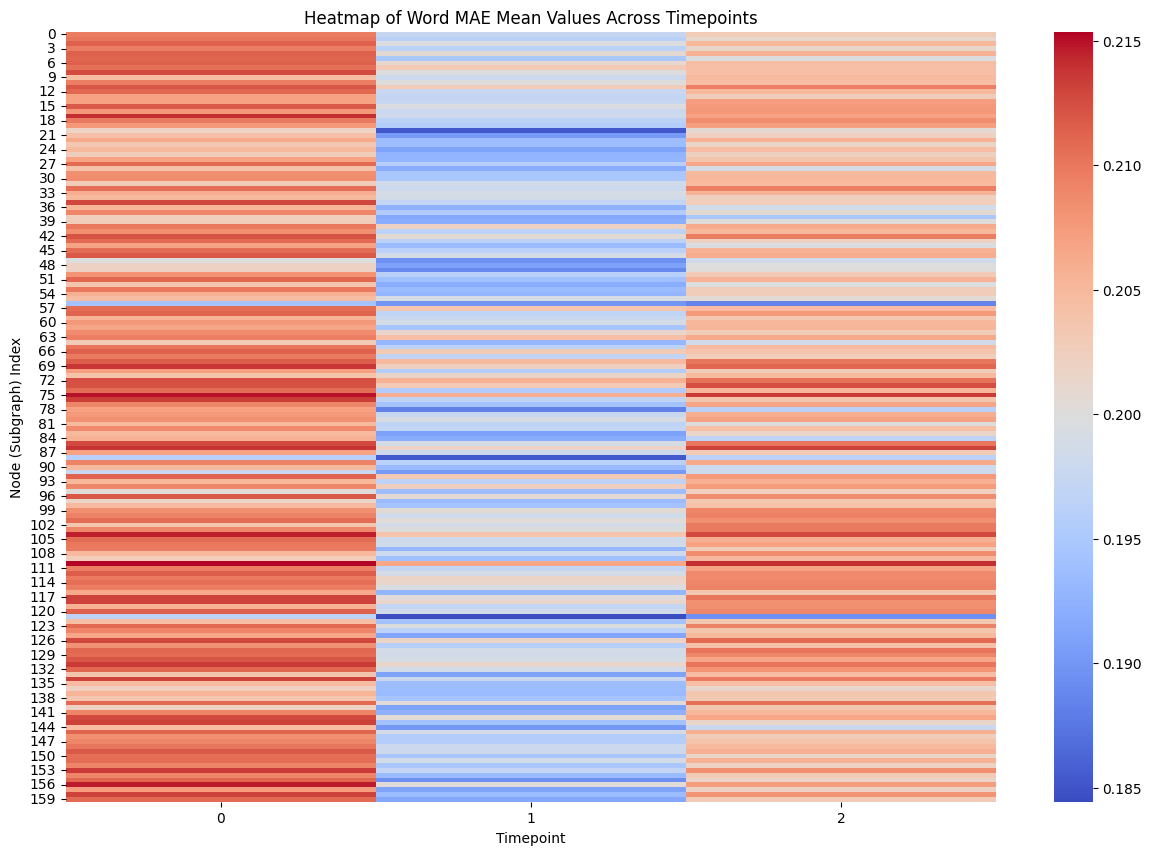

In [32]:
mean_r2_pivot = subgraphs_r2_df.pivot_table(index='Subgraph_Index', columns='Timepoint', values='Number_R2', aggfunc='mean')
plt.figure(figsize=(15, 10))
sns.heatmap(mean_r2_pivot, annot=False, cmap='coolwarm')
plt.title('Heatmap of Number R2 Mean Values Across Timepoints')
plt.xlabel('Timepoint')
plt.ylabel('Node (Subgraph) Index')
plt.show()

mean_r2_pivot = subgraphs_r2_df.pivot_table(index='Subgraph_Index', columns='Timepoint', values='Image_R2', aggfunc='mean')
plt.figure(figsize=(15, 10))
sns.heatmap(mean_r2_pivot, annot=False, cmap='coolwarm')
plt.title('Heatmap of Image R2 Mean Values Across Timepoints')
plt.xlabel('Timepoint')
plt.ylabel('Node (Subgraph) Index')
plt.show()

mean_r2_pivot = subgraphs_r2_df.pivot_table(index='Subgraph_Index', columns='Timepoint', values='Word_R2', aggfunc='mean')
plt.figure(figsize=(15, 10))
sns.heatmap(mean_r2_pivot, annot=False, cmap='coolwarm')
plt.title('Heatmap of Word MAE Mean Values Across Timepoints')
plt.xlabel('Timepoint')
plt.ylabel('Node (Subgraph) Index')
plt.show()

#### MAE

In [17]:
def process_subgraph_mae(subgraph_index, subgraph, generate_tasks_data, initialize_esn, calculate_mae):
    subgraph_size = subgraph.shape[0]
    (number_sequence, number_target), (mnist_input, mnist_target), (word_input, word_target) = generate_tasks_data()
    
    # Calculate MAE for number sequence
    Win, Wres, Wout = initialize_esn(subgraph, input_size=1, reservoir_size=subgraph_size, output_size=1)
    number_mae = calculate_mae(Win, Wres, Wout, number_sequence, number_target)

    # Calculate MAE for MNIST sequence
    Win, Wres, Wout = initialize_esn(subgraph, input_size=28*27, reservoir_size=subgraph_size, output_size=28*27)
    mnist_mae = calculate_mae(Win, Wres, Wout, mnist_input, mnist_target)

    # Calculate MAE for Word2Vec sequence
    Win, Wres, Wout = initialize_esn(subgraph, input_size=10, reservoir_size=subgraph_size, output_size=10)
    word_mae = calculate_mae(Win, Wres, Wout, word_input, word_target)
    
    return subgraph_index, number_mae, mnist_mae, word_mae

def calculate_subgraphs_mae(all_subgraphs):
    mae_results = []
    subject_times = []

    for subject, timepoint, subgraphs in all_subgraphs:
        print(f'Calculating subgraphs MAE of subject {subject+1} at timepoint {timepoint+1} ')
        start_time = time.time()

        subgraph_data = [(i, subgraph, generate_tasks_data, initialize_esn, calculate_mae) for i, subgraph in enumerate(subgraphs)]
        
        results = Parallel(n_jobs=-1)(delayed(process_subgraph_mae)(i, subgraph, generate_tasks_data, initialize_esn, calculate_mae) for i, subgraph in enumerate(subgraphs))

        for subgraph_index, number_mae, mnist_mae, word_mae in results:
            mae_results.append((subject, timepoint, subgraph_index, number_mae, mnist_mae, word_mae))
        
        subject_time = time.time() - start_time
        subject_times.append(subject_time)
        print(f"Time taken for subject {subject+1}: {subject_time:.2f} seconds")
    
    average_time = sum(subject_times) / len(subject_times)
    print(f"Average time taken across subjects: {average_time:.2f} seconds")

    return mae_results

In [121]:
subgraphs_mae_results = calculate_subgraphs_mae(slim160_subgraphs)
subgraphs_mae_df = pd.DataFrame(subgraphs_mae_results, columns=['Subject', 'Timepoint', 'Subgraph_Index', 'Number_MAE', 'Image_MAE', 'Word_MAE'])
subgraphs_mae_df.to_csv('mae_df_subgraphs.csv')

Calculating subgraphs MAE of subject 1 at timepoint 1 
Time taken for subject 0: 14.46 seconds
Calculating subgraphs MAE of subject 1 at timepoint 2 
Time taken for subject 0: 5.31 seconds
Calculating subgraphs MAE of subject 1 at timepoint 3 
Time taken for subject 0: 4.95 seconds
Calculating subgraphs MAE of subject 2 at timepoint 1 
Time taken for subject 1: 4.87 seconds
Calculating subgraphs MAE of subject 2 at timepoint 2 
Time taken for subject 1: 4.91 seconds
Calculating subgraphs MAE of subject 2 at timepoint 3 
Time taken for subject 1: 4.74 seconds
Calculating subgraphs MAE of subject 3 at timepoint 1 
Time taken for subject 2: 4.86 seconds
Calculating subgraphs MAE of subject 3 at timepoint 2 
Time taken for subject 2: 4.74 seconds
Calculating subgraphs MAE of subject 3 at timepoint 3 
Time taken for subject 2: 4.94 seconds
Calculating subgraphs MAE of subject 4 at timepoint 1 
Time taken for subject 3: 5.03 seconds
Calculating subgraphs MAE of subject 4 at timepoint 2 
Time

In [122]:
subgraphs_mae_df

Subject  Timepoint  Subgraph_Index  Number_MAE  Image_MAE  Word_MAE
0            0          0               0    3.575056  35.413761  2.340715
1            0          0               1    0.216814  35.257227  2.710224
2            0          0               2    0.494917  35.210254  1.882576
3            0          0               3    3.128730  35.608482  2.752163
4            0          0               4    1.291309  35.361600  2.997849
...        ...        ...             ...         ...        ...       ...
52315      108          2             155    1.990633  35.479118  2.749103
52316      108          2             156    0.838559  35.639825  2.408620
52317      108          2             157    1.989832  35.479209  2.743482
52318      108          2             158    0.837324  35.637425  2.401599
52319      108          2             159    0.577153  35.563212  2.467874

[52320 rows x 6 columns]

In [20]:
# Calculate the mean and standard deviation of MAE values for each subgraph index in each timepoint across all subjects
mae_stats = subgraphs_mae_df.groupby(['Timepoint', 'Subgraph_Index']).agg(
    Number_MAE_mean=('Number_MAE', 'mean'),
    Number_MAE_std=('Number_MAE', 'std'),
    MNIST_MAE_mean=('MNIST_MAE', 'mean'),
    MNIST_MAE_std=('MNIST_MAE', 'std'),
    Word_MAE_mean=('Word_MAE', 'mean'),
    Word_MAE_std=('Word_MAE', 'std')
).reset_index()

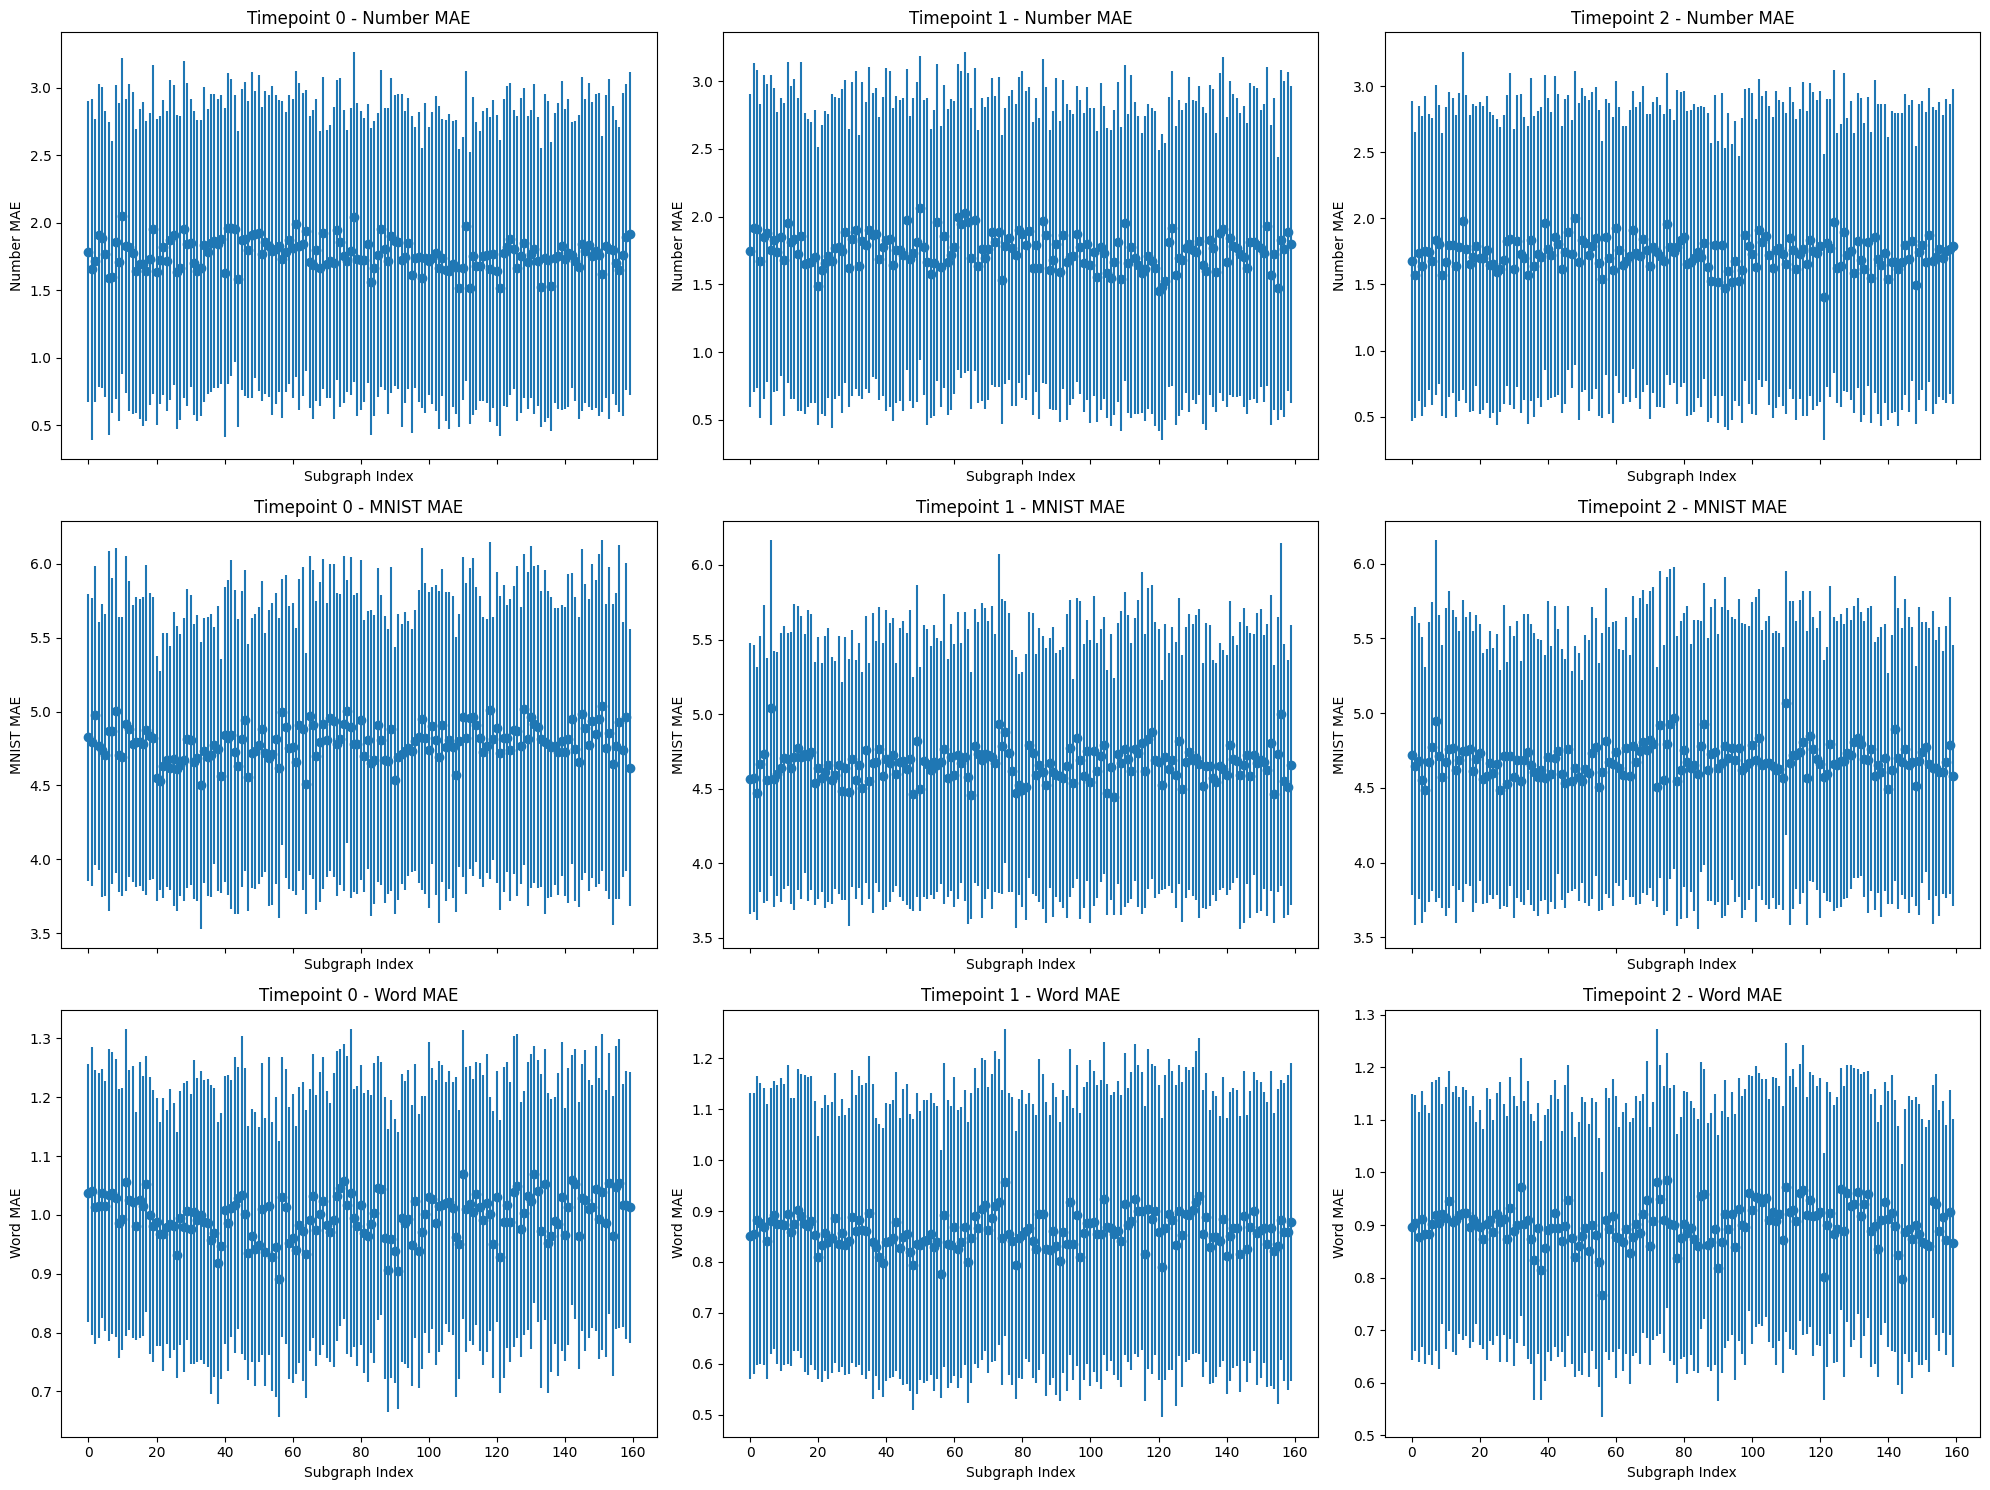

In [52]:
# Create a 3x3 subplot grid
fig, axes = plt.subplots(3, 3, figsize=(20, 15), sharex=True)

timepoints = subgraphs_mae_df['Timepoint'].unique()
tasks = ['Number', 'MNIST', 'Word']
task_columns = ['Number_MAE_mean', 'MNIST_MAE_mean', 'Word_MAE_mean']

for i, (task, task_column) in enumerate(zip(tasks, task_columns)):
    for j,  timepoint in enumerate(timepoints):
        # Plot mean MAE values for the given timepoint and task
        axes[i, j].errorbar(
            mae_stats[mae_stats['Timepoint'] == timepoint]['Subgraph_Index'],
            mae_stats[mae_stats['Timepoint'] == timepoint][task_column],
            yerr=mae_stats[mae_stats['Timepoint'] == timepoint][task_column.replace('_mean', '_std')],
            fmt='o'
        )
        axes[i, j].set_title(f'Timepoint {timepoint} - {task} MAE')
        axes[i, j].set_xlabel('Subgraph Index')
        axes[i, j].set_ylabel(f'{task} MAE')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


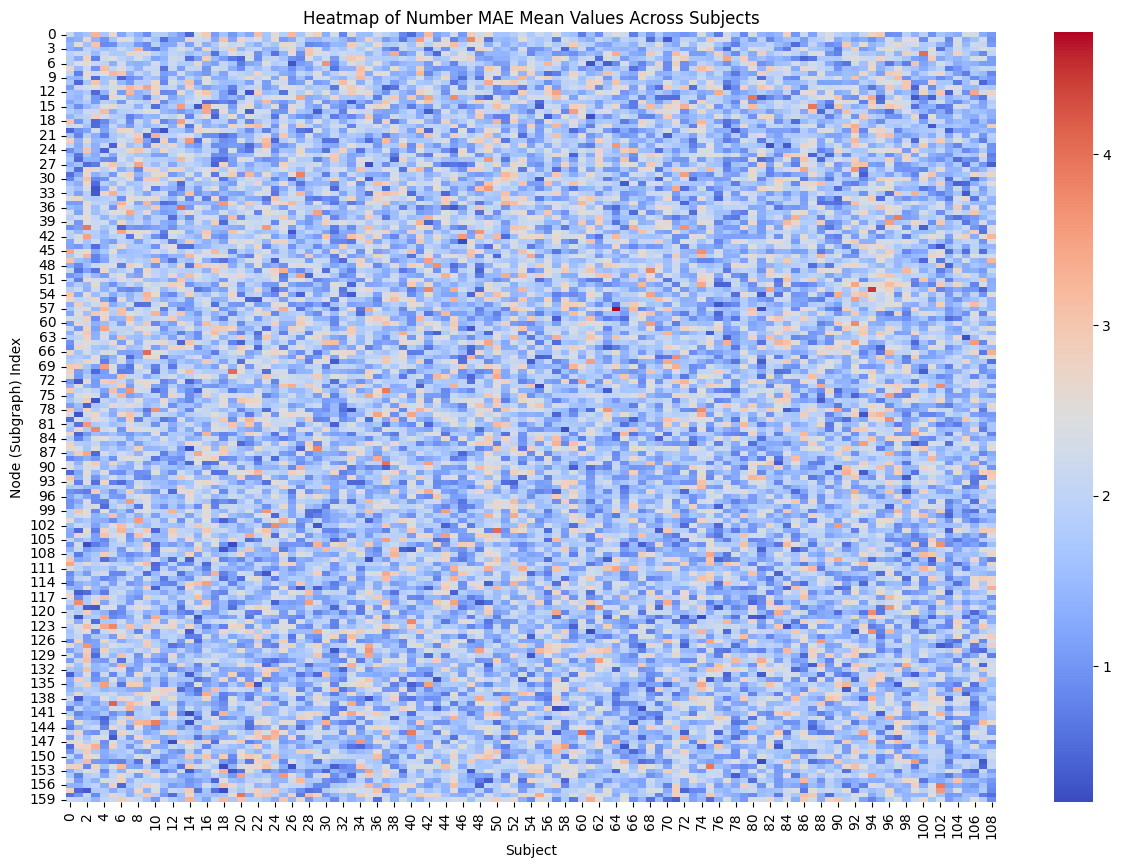

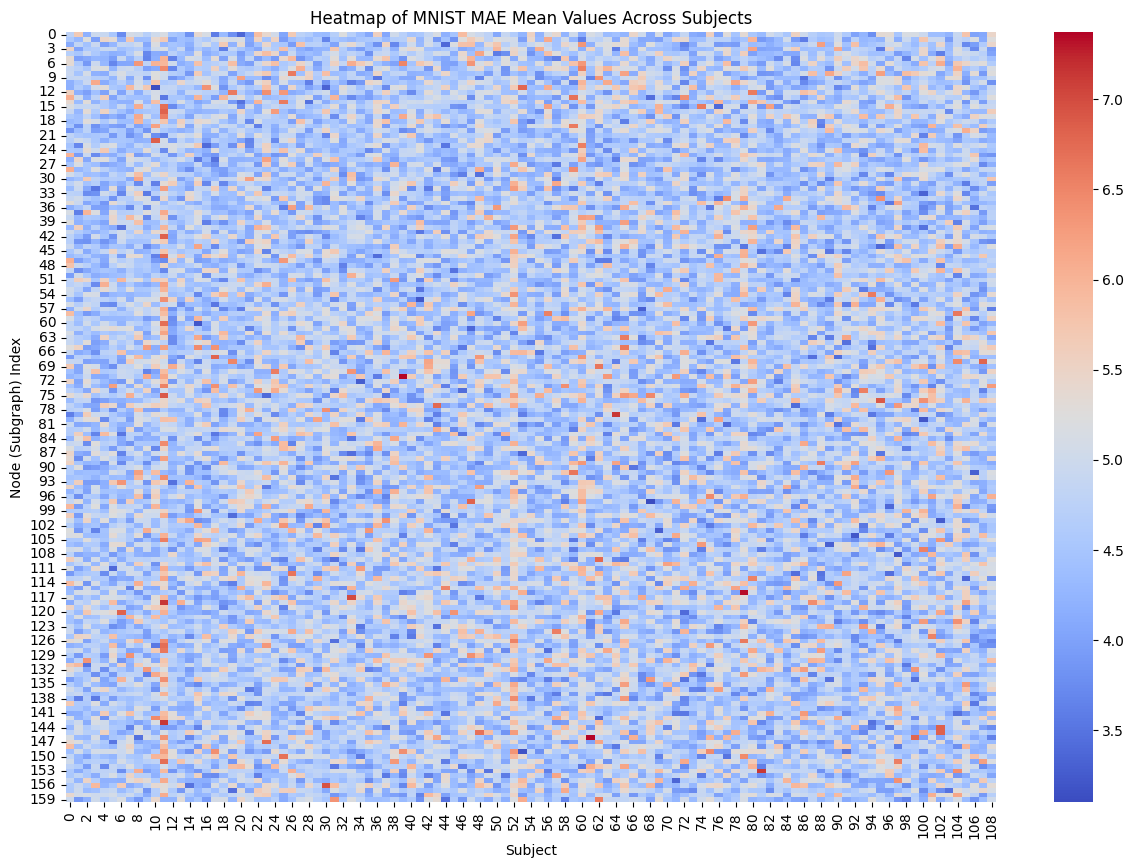

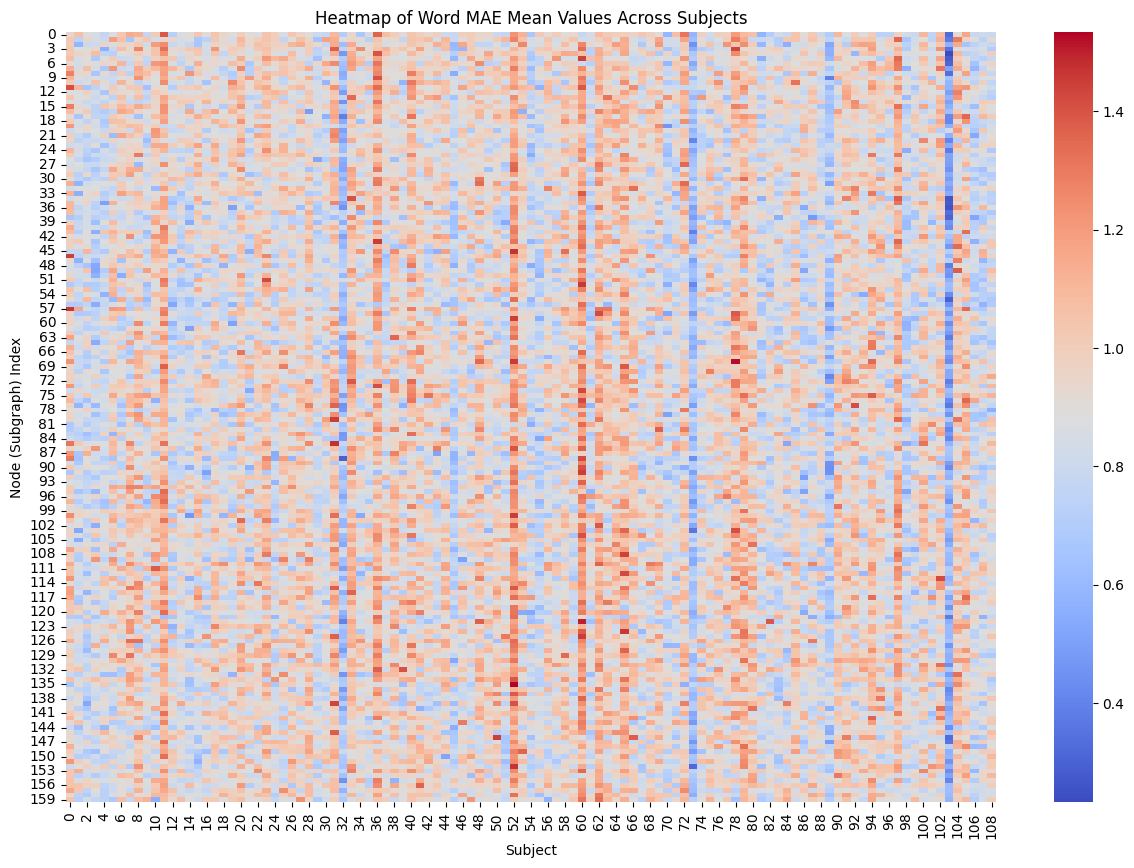

In [33]:
# Create heatmaps to represent the mean MAE values for each subgraph index across different tasks and timepoints
mean_mae_pivot = subgraphs_mae_df.pivot_table(index='Subgraph_Index', columns='Subject', values='Number_MAE', aggfunc='mean')
plt.figure(figsize=(15, 10))
sns.heatmap(mean_mae_pivot, annot=False, cmap='coolwarm')
plt.title('Heatmap of Number MAE Mean Values Across Subjects')
plt.xlabel('Subject')
plt.ylabel('Node (Subgraph) Index')
plt.show()

mean_mae_pivot = subgraphs_mae_df.pivot_table(index='Subgraph_Index', columns='Subject', values='MNIST_MAE', aggfunc='mean')
plt.figure(figsize=(15, 10))
sns.heatmap(mean_mae_pivot, annot=False, cmap='coolwarm')
plt.title('Heatmap of MNIST MAE Mean Values Across Subjects')
plt.xlabel('Subject')
plt.ylabel('Node (Subgraph) Index')
plt.show()

mean_mae_pivot = subgraphs_mae_df.pivot_table(index='Subgraph_Index', columns='Subject', values='Word_MAE', aggfunc='mean')
plt.figure(figsize=(15, 10))
sns.heatmap(mean_mae_pivot, annot=False, cmap='coolwarm')
plt.title('Heatmap of Word MAE Mean Values Across Subjects')
plt.xlabel('Subject')
plt.ylabel('Node (Subgraph) Index')
plt.show()


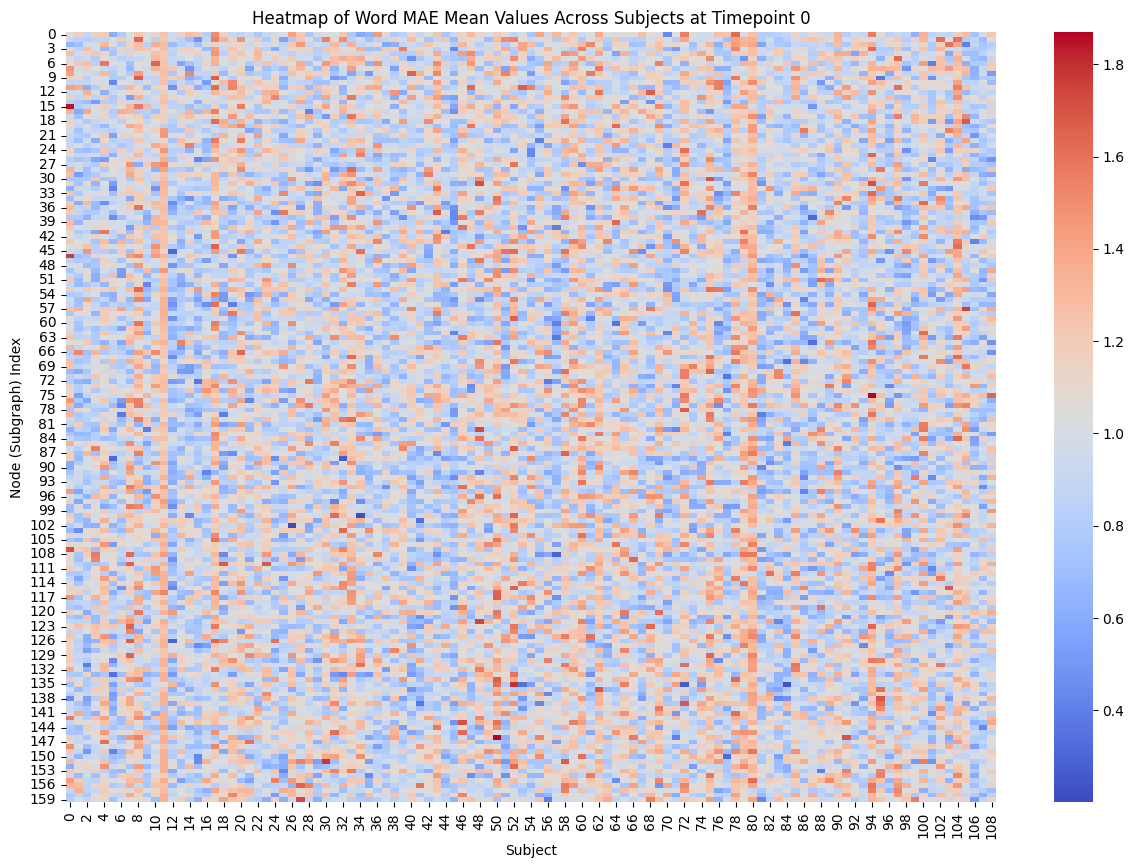

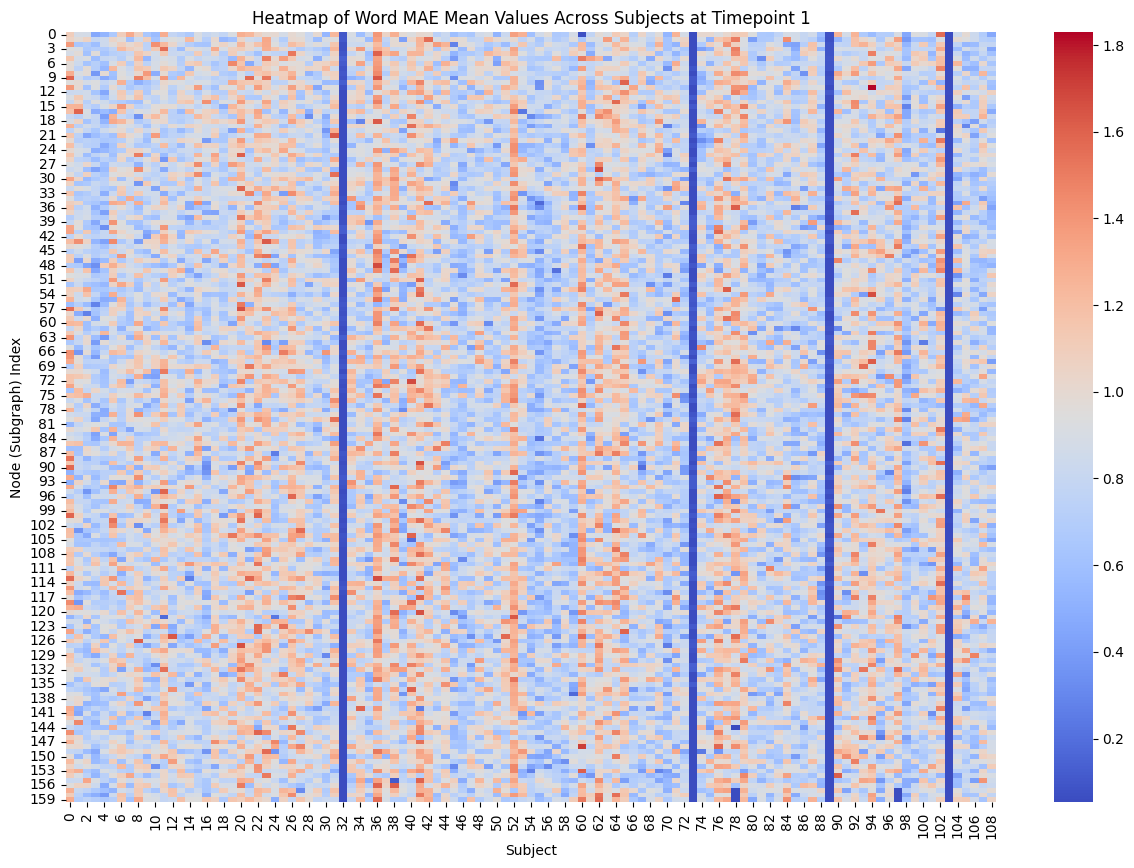

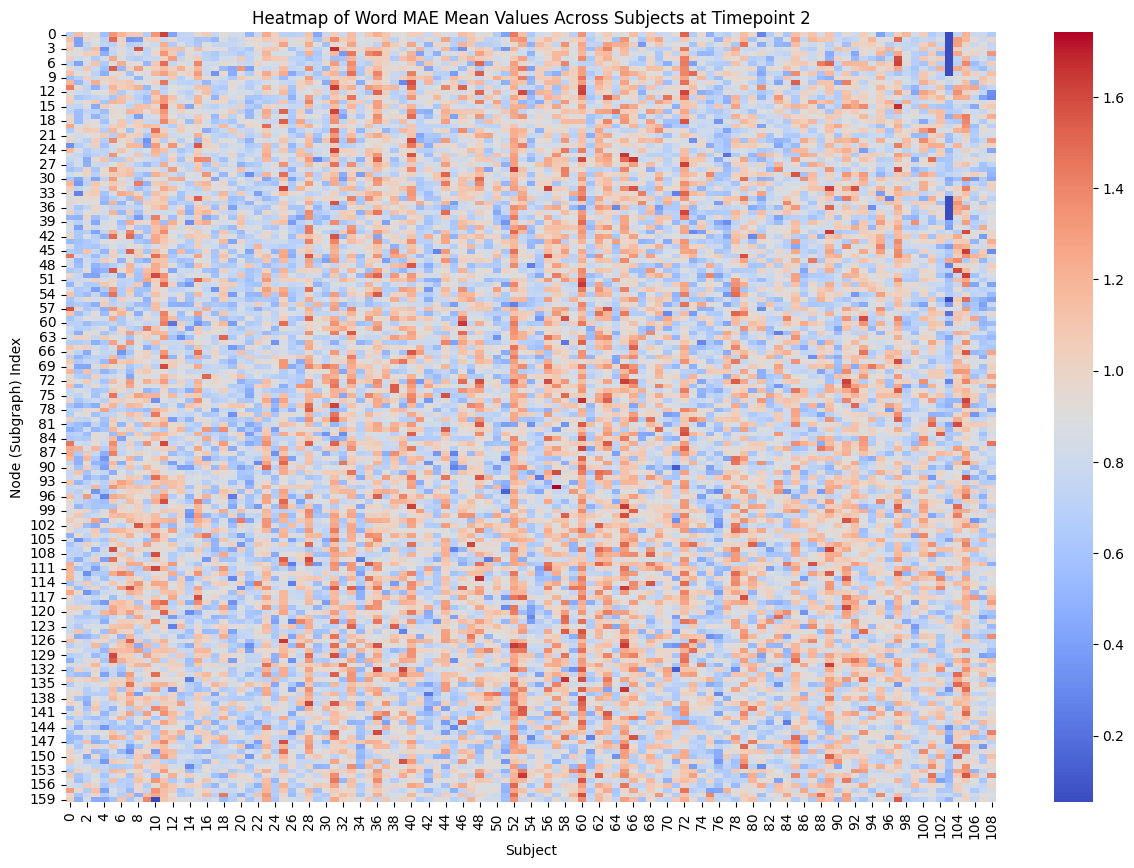

In [36]:
filtered_df = subgraphs_mae_df[subgraphs_mae_df['Timepoint'] == 0]
mean_mae_pivot = filtered_df.pivot_table(index='Subgraph_Index', columns='Subject', values='Word_MAE', aggfunc='mean')
plt.figure(figsize=(15, 10))
sns.heatmap(mean_mae_pivot, annot=False, cmap='coolwarm')
plt.title(f'Heatmap of Word MAE Mean Values Across Subjects at Timepoint {0}')
plt.xlabel('Subject')
plt.ylabel('Node (Subgraph) Index')
plt.show()

filtered_df = subgraphs_mae_df[subgraphs_mae_df['Timepoint'] == 1]
mean_mae_pivot = filtered_df.pivot_table(index='Subgraph_Index', columns='Subject', values='Word_MAE', aggfunc='mean')
plt.figure(figsize=(15, 10))
sns.heatmap(mean_mae_pivot, annot=False, cmap='coolwarm')
plt.title(f'Heatmap of Word MAE Mean Values Across Subjects at Timepoint {1}')
plt.xlabel('Subject')
plt.ylabel('Node (Subgraph) Index')
plt.show()

filtered_df = subgraphs_mae_df[subgraphs_mae_df['Timepoint'] == 2]
mean_mae_pivot = filtered_df.pivot_table(index='Subgraph_Index', columns='Subject', values='Word_MAE', aggfunc='mean')
plt.figure(figsize=(15, 10))
sns.heatmap(mean_mae_pivot, annot=False, cmap='coolwarm')
plt.title(f'Heatmap of Word MAE Mean Values Across Subjects at Timepoint {2}')
plt.xlabel('Subject')
plt.ylabel('Node (Subgraph) Index')
plt.show()


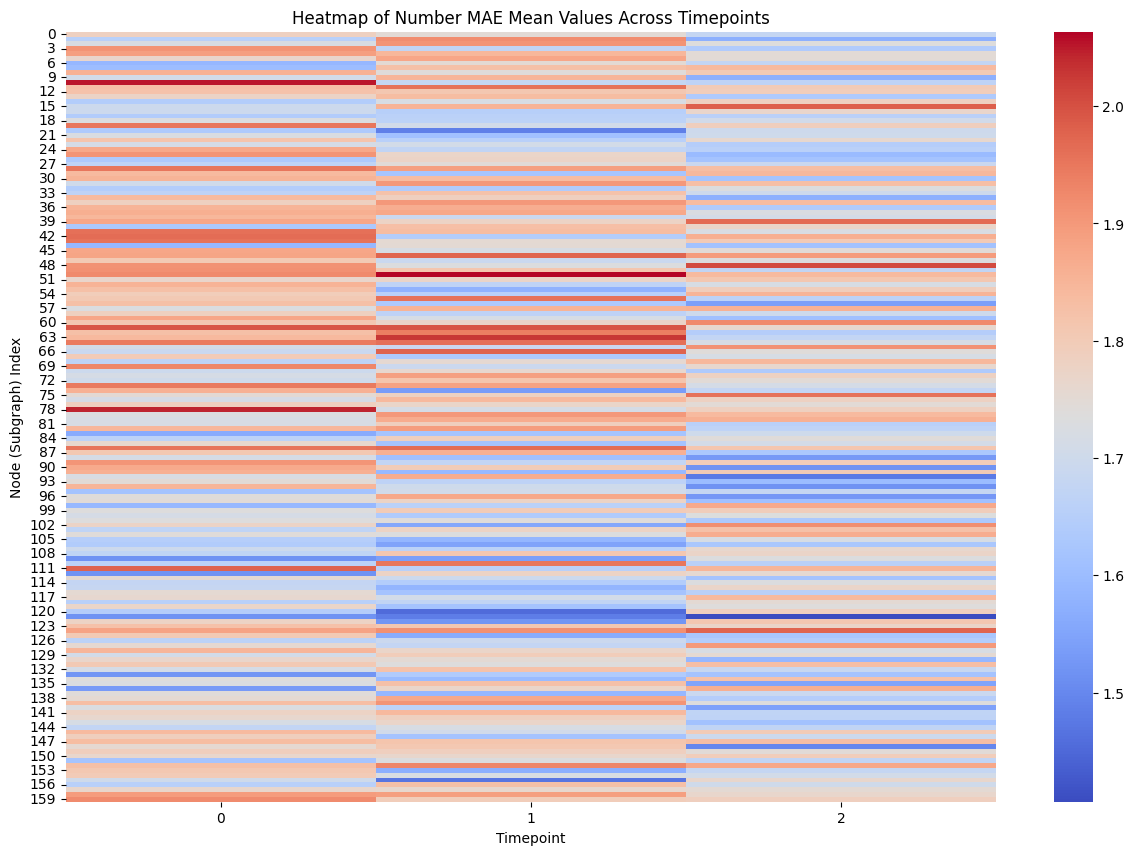

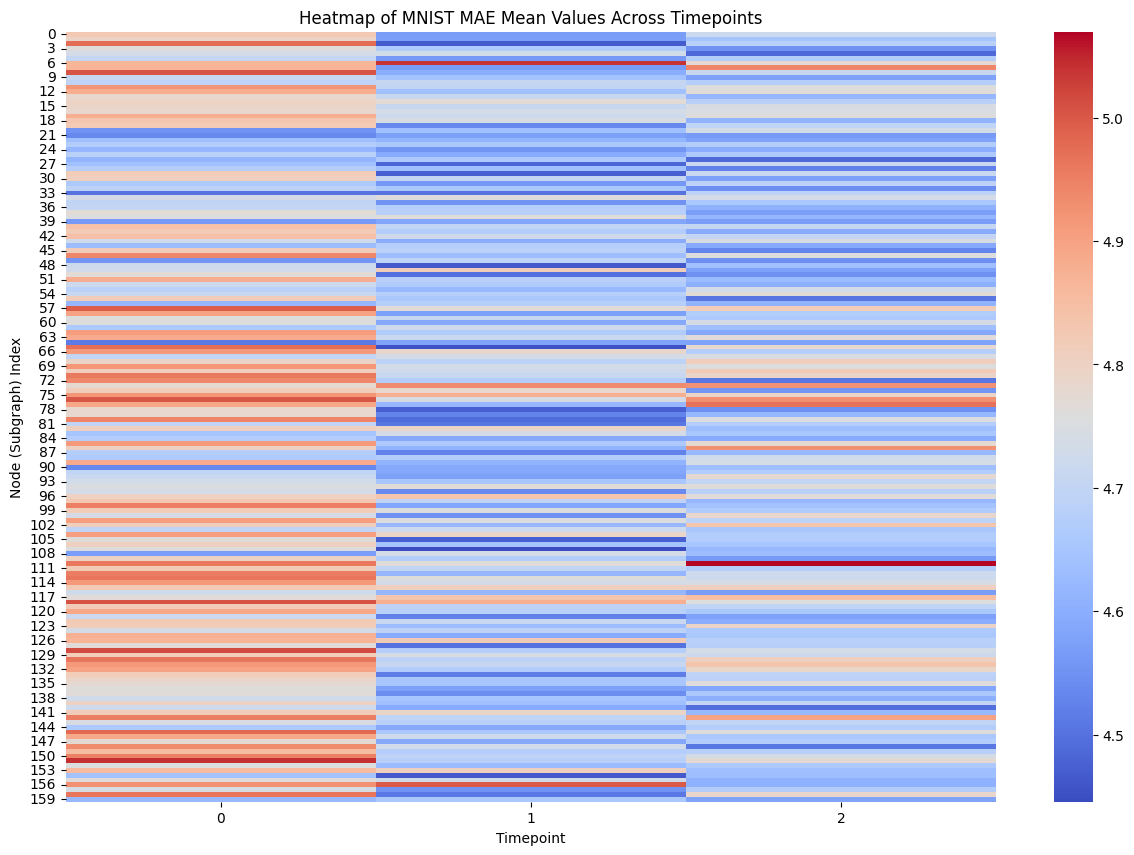

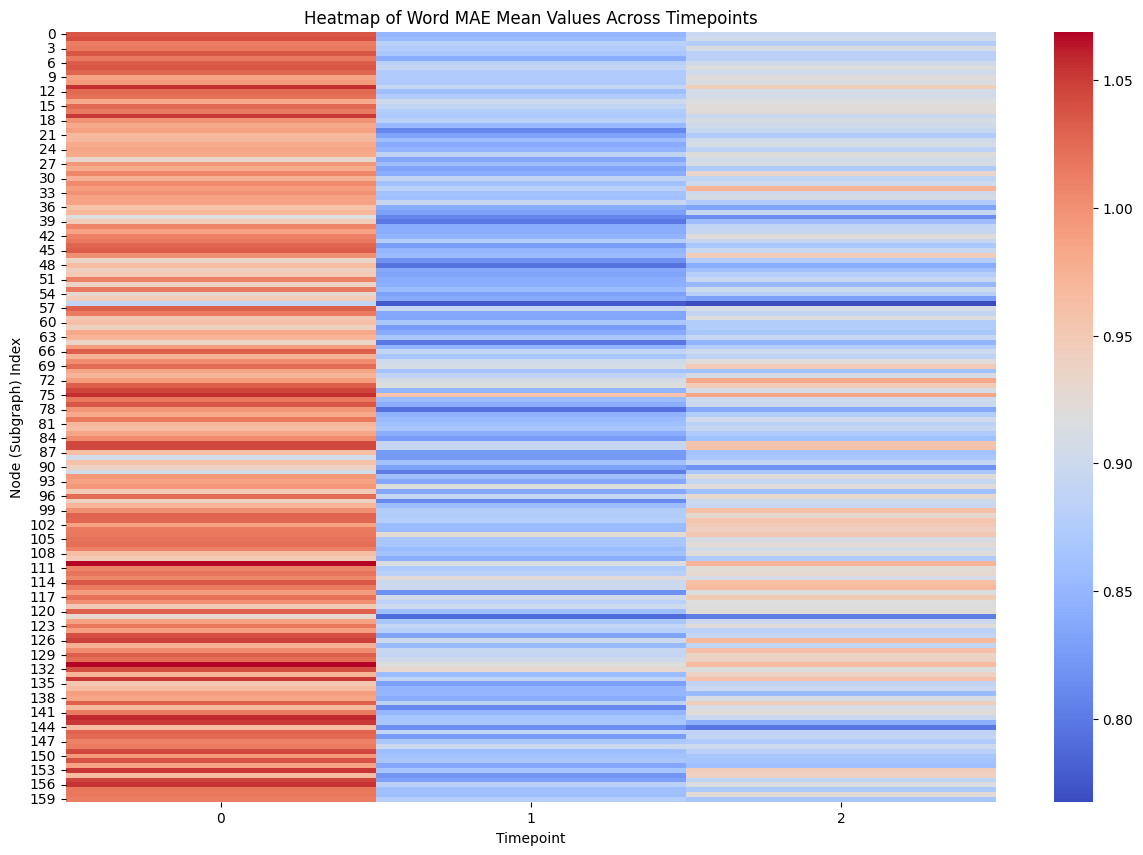

In [37]:
mean_mae_pivot = subgraphs_mae_df.pivot_table(index='Subgraph_Index', columns='Timepoint', values='Number_MAE', aggfunc='mean')
plt.figure(figsize=(15, 10))
sns.heatmap(mean_mae_pivot, annot=False, cmap='coolwarm')
plt.title('Heatmap of Number MAE Mean Values Across Timepoints')
plt.xlabel('Timepoint')
plt.ylabel('Node (Subgraph) Index')
plt.show()

mean_mae_pivot = subgraphs_mae_df.pivot_table(index='Subgraph_Index', columns='Timepoint', values='MNIST_MAE', aggfunc='mean')
plt.figure(figsize=(15, 10))
sns.heatmap(mean_mae_pivot, annot=False, cmap='coolwarm')
plt.title('Heatmap of MNIST MAE Mean Values Across Timepoints')
plt.xlabel('Timepoint')
plt.ylabel('Node (Subgraph) Index')
plt.show()

mean_mae_pivot = subgraphs_mae_df.pivot_table(index='Subgraph_Index', columns='Timepoint', values='Word_MAE', aggfunc='mean')
plt.figure(figsize=(15, 10))
sns.heatmap(mean_mae_pivot, annot=False, cmap='coolwarm')
plt.title('Heatmap of Word MAE Mean Values Across Timepoints')
plt.xlabel('Timepoint')
plt.ylabel('Node (Subgraph) Index')
plt.show()


In [48]:
import numpy as np
import pandas as pd

# Define the specific timepoint (e.g., t = 0)
timepoint = 0

# Extract the adjacency matrices for the specific timepoint
adj_matrices = slim160_cleaned[:, timepoint, :, :]

# Filter the DataFrame for the specific timepoint and task (e.g., Word_MAE)
filtered_df = subgraphs_mae_df[subgraphs_mae_df['Timepoint'] == timepoint][['Subject', 'Subgraph_Index', 'Word_MAE']]

# Initialize lists to store the results
node_means = []
neighbor_means = []
neighbor_stds = []
mae_difference = []

# Calculate the mean and std of MAE values for each node and its neighbors
for subject_idx in range(adj_matrices.shape[0]):
    subject_df = filtered_df[filtered_df['Subject'] == subject_idx]
    adjacency_matrix = adj_matrices[subject_idx]
    
    for node_idx in range(adjacency_matrix.shape[0]):
        node_mae = subject_df[subject_df['Subgraph_Index'] == node_idx]['Word_MAE'].values[0]
        
        # Identify the neighbors
        neighbors = np.where(adjacency_matrix[node_idx] != 0)[0]
        neighbor_maes = subject_df[subject_df['Subgraph_Index'].isin(neighbors)]['Word_MAE'].values
        
        node_means.append(node_mae)
        neighbor_means.append(np.mean(neighbor_maes))
        neighbor_stds.append(np.std(neighbor_maes))
        mae_difference.append(node_mae-np.mean(neighbor_maes))

# Create a DataFrame to store the results
neighbor_analysis_df = pd.DataFrame({
    'Node_MAE': node_means,
    'Neighbor_Mean_MAE': neighbor_means,
    'Neighbor_Std_MAE': neighbor_stds,
    'Node_vs_Neighbour_MAE': mae_difference
})


In [49]:
# Display the first few rows of the DataFrame
neighbor_analysis_df

Node_MAE  Neighbor_Mean_MAE  Neighbor_Std_MAE  Node_vs_Neighbour_MAE
0      1.053054           1.056611          0.256730              -0.003557
1      0.913534           1.055966          0.245479              -0.142432
2      0.649255           1.046742          0.242141              -0.397487
3      1.061533           1.061227          0.245657               0.000306
4      1.280242           1.070522          0.248894               0.209720
...         ...                ...               ...                    ...
17435  1.081694           1.030340          0.199733               0.051354
17436  1.156580           1.002577          0.214978               0.154003
17437  0.707037           0.997362          0.218285              -0.290325
17438  0.842465           1.018312          0.213309              -0.175846
17439  1.131652           0.997350          0.223505               0.134302

[17440 rows x 4 columns]

In [51]:
print('Min Difference: ', neighbor_analysis_df['Node_vs_Neighbour_MAE'].min())
print('Max Difference: ', neighbor_analysis_df['Node_vs_Neighbour_MAE'].max())
print('Mean Difference: ', neighbor_analysis_df['Node_vs_Neighbour_MAE'].mean())
print('std Difference: ', neighbor_analysis_df['Node_vs_Neighbour_MAE'].std())

Min Difference:  -0.795102733421947
Max Difference:  0.7854778344259696
Mean Difference:  -0.013176939333023907
std Difference:  0.2079530486933903


### SLIM Dataset (Phenotype)

In [16]:
# Load the numpy files
connectivity_matrices = np.load(dataset_path + 'slim160_consolidated_connectivity.npy')
depression_index = np.load(dataset_path + 'slim160_consolidated_depression_index.npy')
state_anxiety = np.load(dataset_path + 'slim160_consolidated_state_anxiety.npy')
print(connectivity_matrices.shape)
print(depression_index.shape)
print(state_anxiety.shape)

(109, 3, 160, 160)
(109, 3)
(109, 3)


#### R-Square

In [ ]:
# Calculate the cognitive capacity (R2) for each subject's graph at each time point
r2_df, mean_r2, std_r2, max_r2, min_r2 = calculate_cognitive_capacity_r2(connectivity_matrices, 160)

# Convert depression index and state anxiety to DataFrame
depression_df = pd.DataFrame(depression_index, columns=['Depression_1', 'Depression_2', 'Depression_3'])
anxiety_df = pd.DataFrame(state_anxiety, columns=['Anxiety_1', 'Anxiety_2', 'Anxiety_3'])

# Concatenate the data into a single DataFrame
merged_df = pd.concat([r2_df, depression_df, anxiety_df], axis=1)


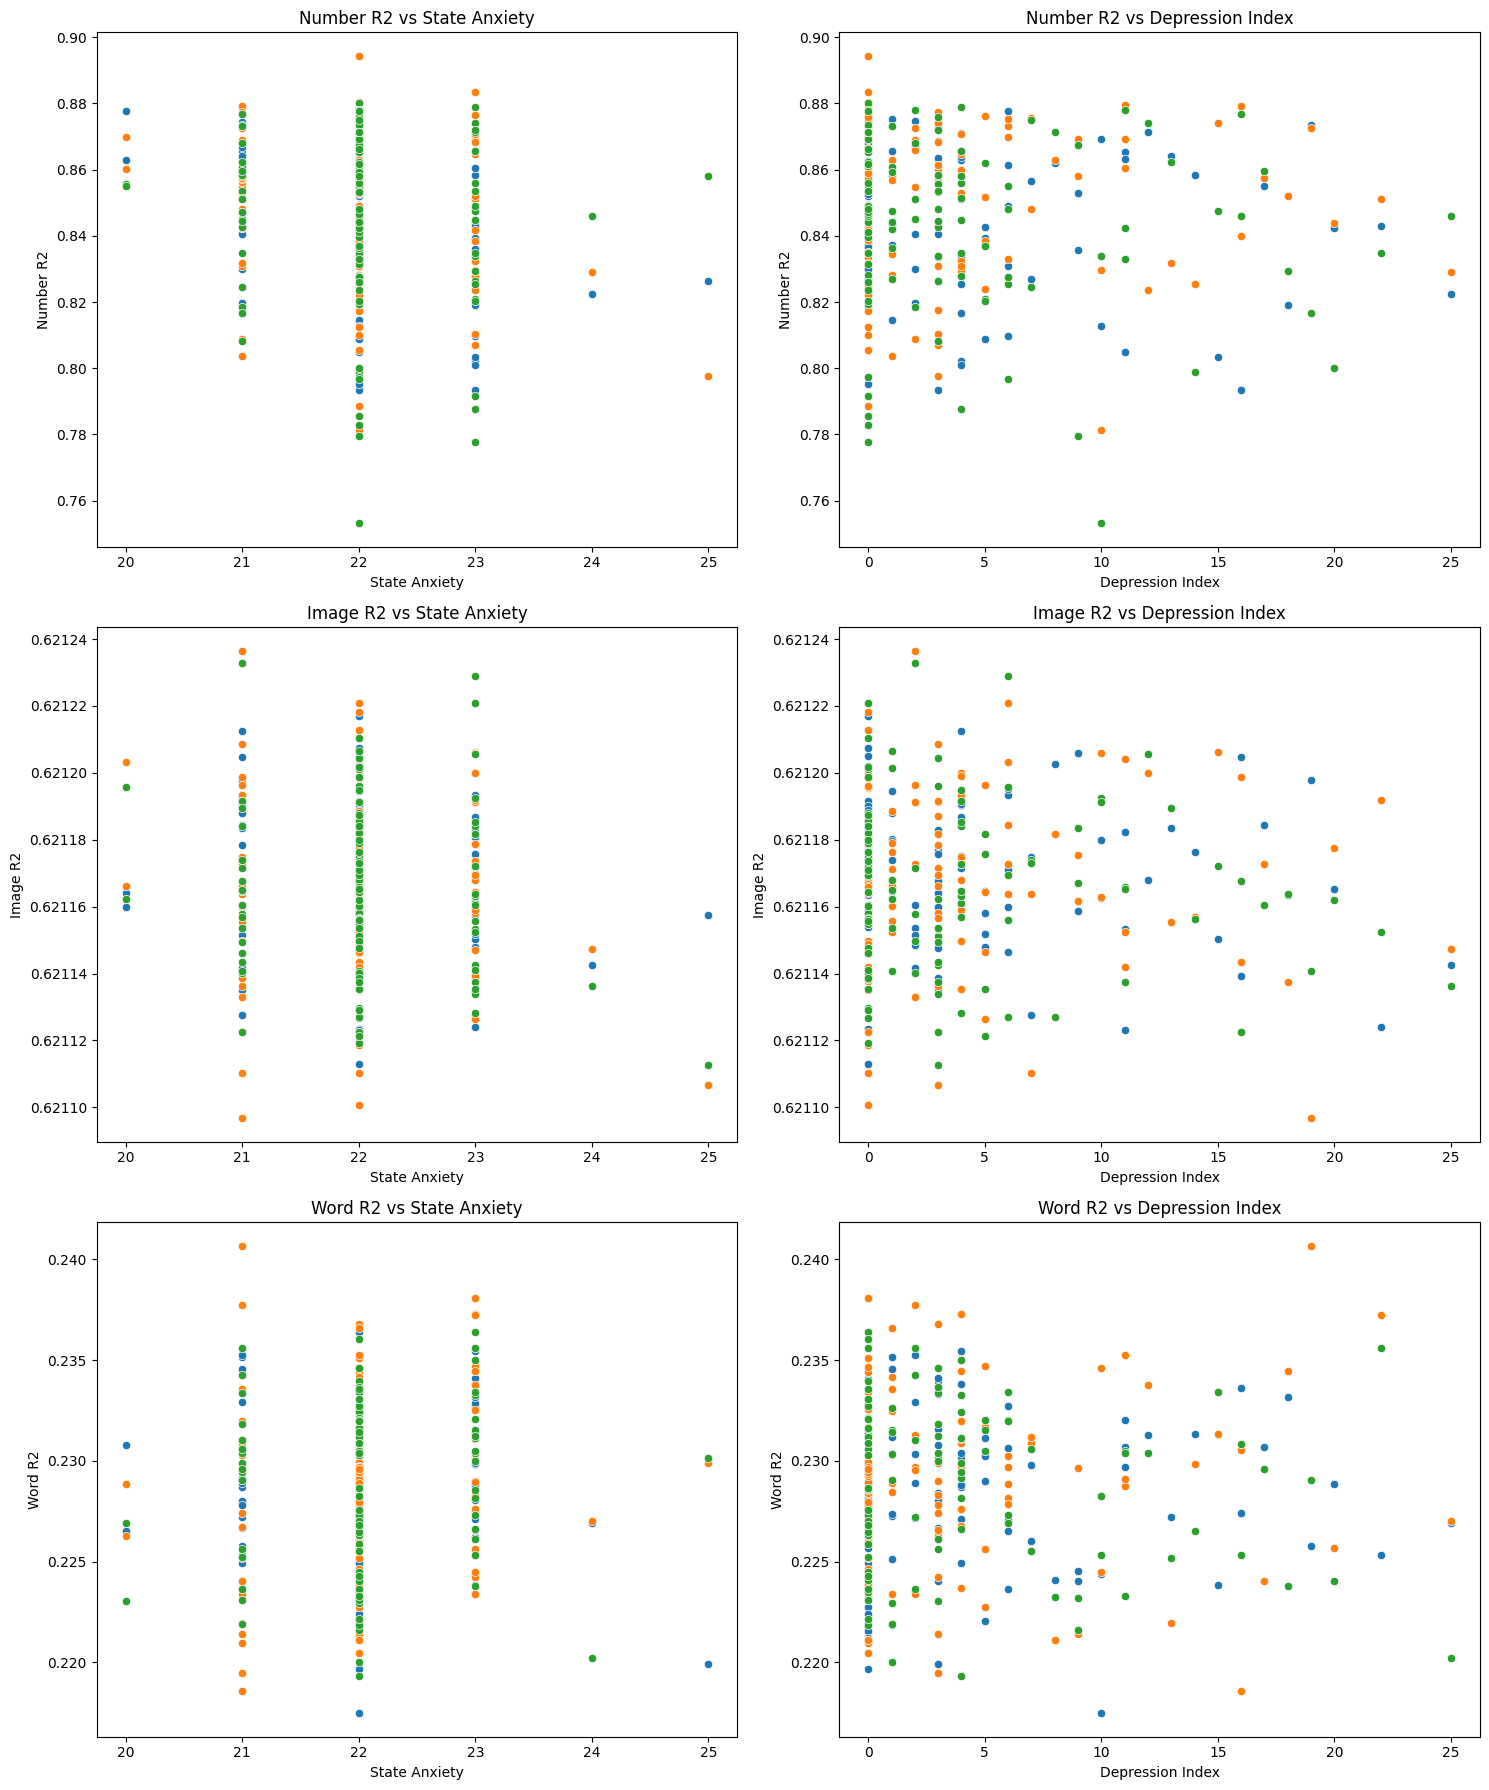

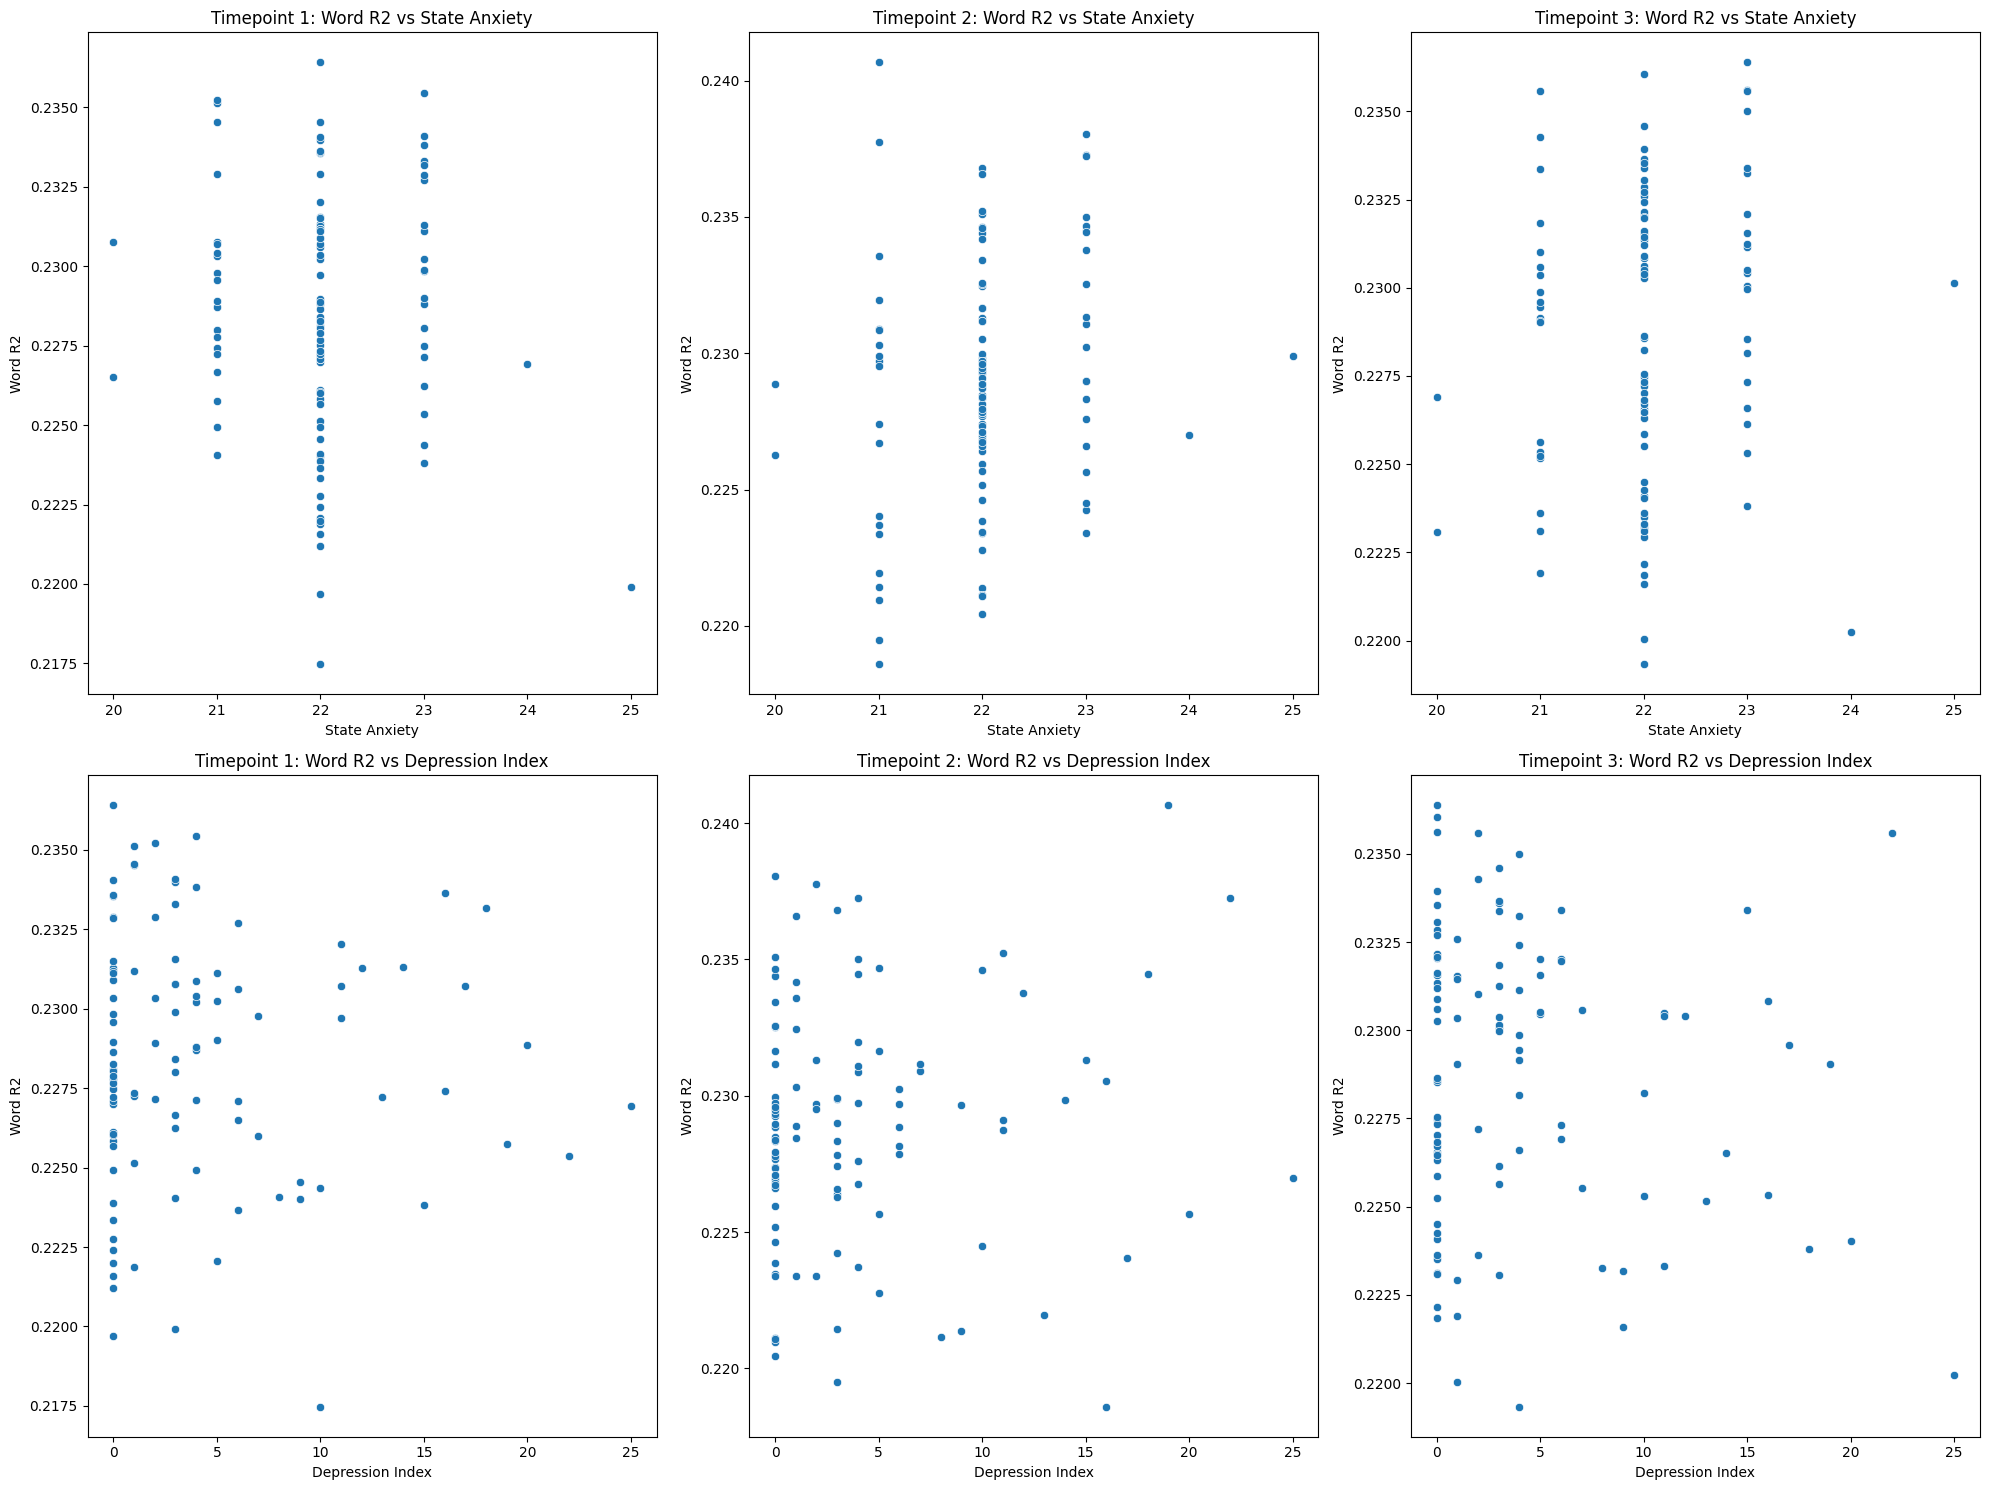

In [20]:
def create_overall_scatter_plots_r2(merged_df):
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    
    tasks = ['Number', 'Image', 'Word']
    task_r2_cols = ['Number_R2', 'Image_R2', 'Word_R2']
    anxiety_cols = ['Anxiety_1', 'Anxiety_2', 'Anxiety_3']
    depression_cols = ['Depression_1', 'Depression_2', 'Depression_3']
    
    for i, (task, task_r2_col) in enumerate(zip(tasks, task_r2_cols)):
        # Plot state anxiety vs task R2
        sns.scatterplot(x='Anxiety_1', y=f'{task_r2_col}_1', data=merged_df, ax=axes[i, 0], legend=True)
        sns.scatterplot(x='Anxiety_2', y=f'{task_r2_col}_2', data=merged_df, ax=axes[i, 0], legend=True)
        sns.scatterplot(x='Anxiety_3', y=f'{task_r2_col}_3', data=merged_df, ax=axes[i, 0], legend=True)
        axes[i, 0].set_title(f'{task} R2 vs State Anxiety')
        axes[i, 0].set_xlabel('State Anxiety')
        axes[i, 0].set_ylabel(f'{task} R2')
        
        # Plot depression index vs task R2
        sns.scatterplot(x='Depression_1', y=f'{task_r2_col}_1', data=merged_df, ax=axes[i, 1], legend=True)
        sns.scatterplot(x='Depression_2', y=f'{task_r2_col}_2', data=merged_df, ax=axes[i, 1], legend=True)
        sns.scatterplot(x='Depression_3', y=f'{task_r2_col}_3', data=merged_df, ax=axes[i, 1], legend=True)
        axes[i, 1].set_title(f'{task} R2 vs Depression Index')
        axes[i, 1].set_xlabel('Depression Index')
        axes[i, 1].set_ylabel(f'{task} R2')
    
    plt.tight_layout()
    plt.show()

# Function to create scatter plots for relationship in each time point
def create_timepoint_scatter_plots_r2(merged_df):
    fig, axes = plt.subplots(2, 3, figsize=(20, 15))
    
    timepoints = [1, 2, 3]
    for i, timepoint in enumerate(timepoints):
        sns.scatterplot(x=f'Anxiety_{timepoint}', y=f'Word_R2_{timepoint}', data=merged_df, ax=axes[0,i], legend=True)
        axes[0, i].set_title(f'Timepoint {timepoint}: Word R2 vs State Anxiety')
        axes[0, i].set_xlabel('State Anxiety')
        axes[0, i].set_ylabel('Word R2')
        
        sns.scatterplot(x=f'Depression_{timepoint}', y=f'Word_R2_{timepoint}', data=merged_df, ax=axes[1,i], legend=True)
        axes[1, i].set_title(f'Timepoint {timepoint}: Word R2 vs Depression Index')
        axes[1, i].set_xlabel('Depression Index')
        axes[1, i].set_ylabel('Word R2')
    
    plt.tight_layout()
    plt.show()


# Create overall scatter plots
create_overall_scatter_plots_r2(merged_df)

# Create scatter plots for each time point
create_timepoint_scatter_plots_r2(merged_df)


#### MAE

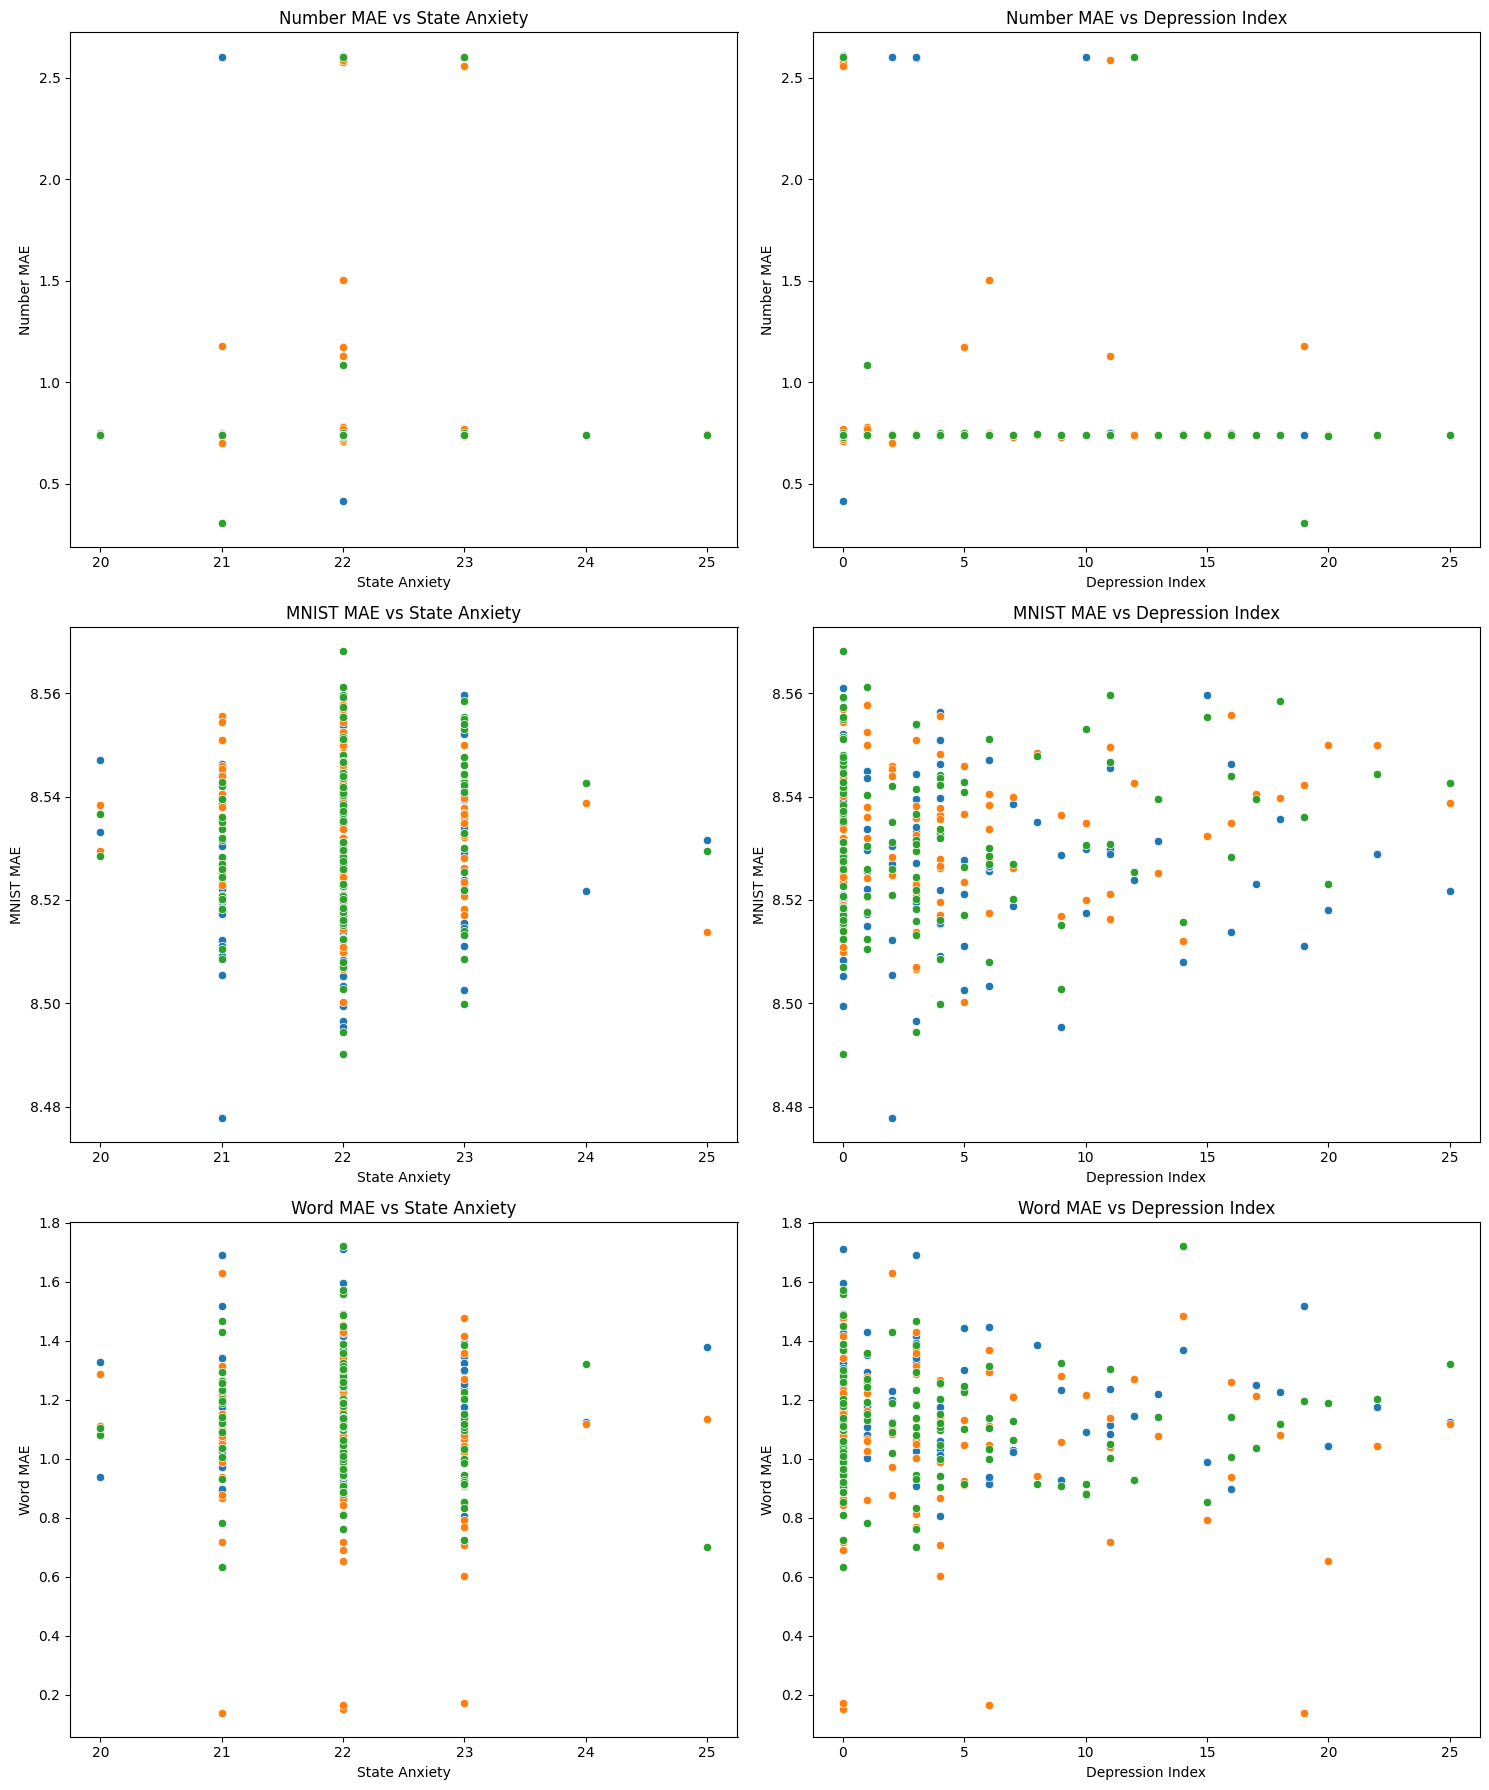

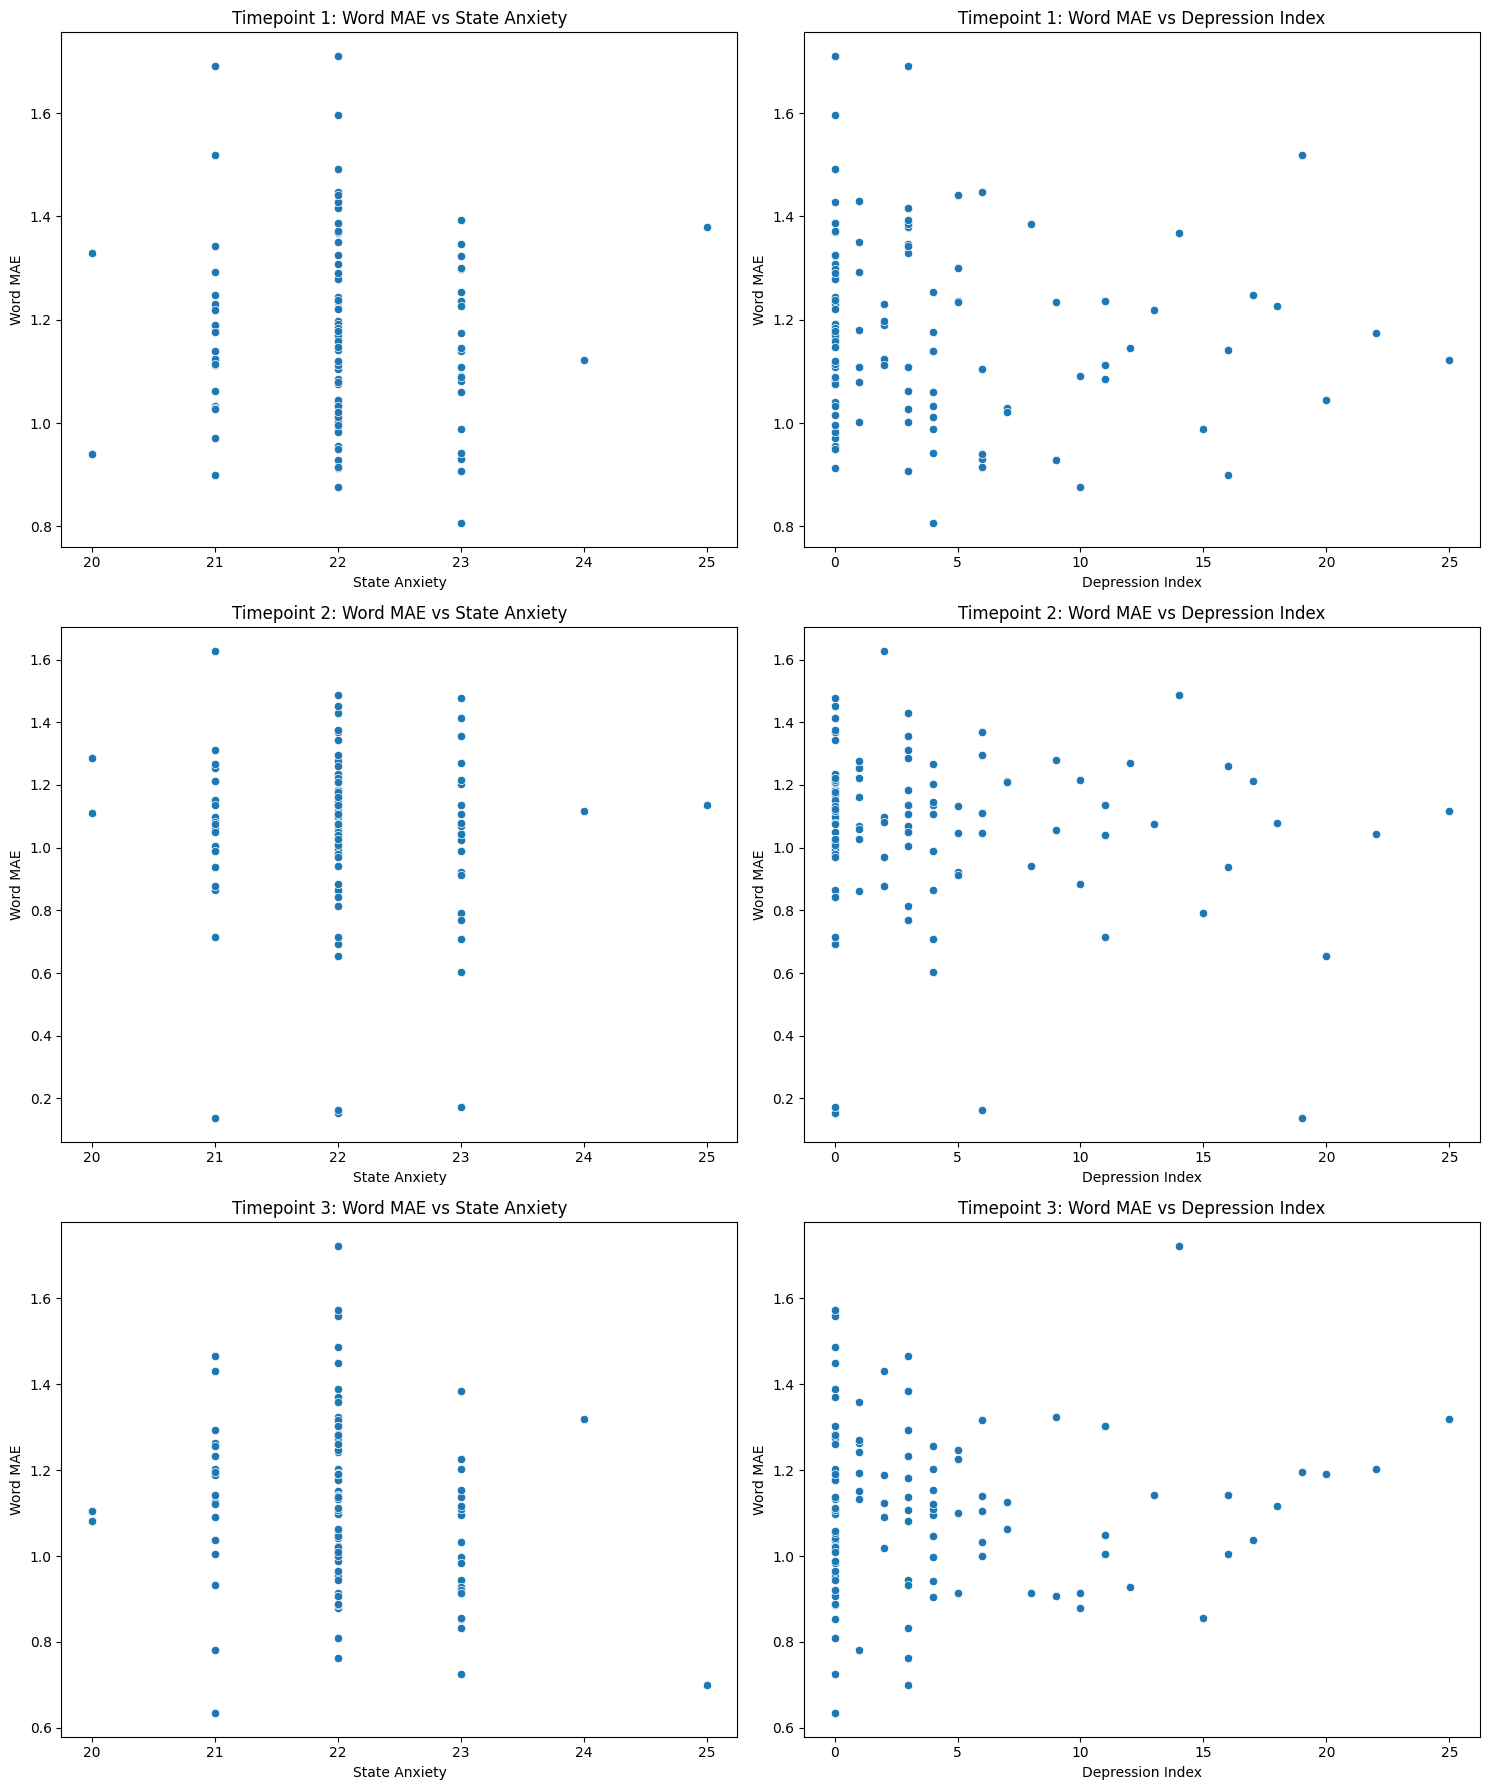

In [26]:
# Calculate the cognitive capacity (MAE) for each subject's graph at each time point
mae_df, mean_mae, std_mae, max_mae, min_mae = calculate_cognitive_capacity(connectivity_matrices, 160)

# Convert depression index and state anxiety to DataFrame
depression_df = pd.DataFrame(depression_index, columns=['Depression_1', 'Depression_2', 'Depression_3'])
anxiety_df = pd.DataFrame(state_anxiety, columns=['Anxiety_1', 'Anxiety_2', 'Anxiety_3'])

# Concatenate the data into a single DataFrame
merged_df = pd.concat([mae_df, depression_df, anxiety_df], axis=1)

def create_overall_scatter_plots(merged_df):
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    
    tasks = ['Number', 'Image', 'Word']
    task_mae_cols = ['Number_MAE', 'MNIST_MAE', 'Word_MAE']
    anxiety_cols = ['Anxiety_1', 'Anxiety_2', 'Anxiety_3']
    depression_cols = ['Depression_1', 'Depression_2', 'Depression_3']
    
    for i, (task, task_mae_col) in enumerate(zip(tasks, task_mae_cols)):
        # Plot state anxiety vs task MAE
        sns.scatterplot(x='Anxiety_1', y=f'{task_mae_col}_1', data=merged_df, ax=axes[i, 0])
        sns.scatterplot(x='Anxiety_2', y=f'{task_mae_col}_2', data=merged_df, ax=axes[i, 0])
        sns.scatterplot(x='Anxiety_3', y=f'{task_mae_col}_3', data=merged_df, ax=axes[i, 0])
        axes[i, 0].set_title(f'{task} MAE vs State Anxiety')
        axes[i, 0].set_xlabel('State Anxiety')
        axes[i, 0].set_ylabel(f'{task} MAE')
        
        # Plot depression index vs task MAE
        sns.scatterplot(x='Depression_1', y=f'{task_mae_col}_1', data=merged_df, ax=axes[i, 1])
        sns.scatterplot(x='Depression_2', y=f'{task_mae_col}_2', data=merged_df, ax=axes[i, 1])
        sns.scatterplot(x='Depression_3', y=f'{task_mae_col}_3', data=merged_df, ax=axes[i, 1])
        axes[i, 1].set_title(f'{task} MAE vs Depression Index')
        axes[i, 1].set_xlabel('Depression Index')
        axes[i, 1].set_ylabel(f'{task} MAE')
    
    plt.tight_layout()
    plt.show()

# Function to create scatter plots for relationship in each time point
def create_timepoint_scatter_plots(merged_df):
    fig, axes = plt.subplots(2, 3, figsize=(20, 15))
    
    timepoints = [1, 2, 3]
    for i, timepoint in enumerate(timepoints):
        sns.scatterplot(x=f'Anxiety_{timepoint}', y=f'Word_MAE_{timepoint}', data=merged_df, ax=axes[0,i])
        axes[0, i].set_title(f'Timepoint {timepoint}: Word MAE vs State Anxiety')
        axes[0, i].set_xlabel('State Anxiety')
        axes[0, i].set_ylabel('Word MAE')
        
        sns.scatterplot(x=f'Depression_{timepoint}', y=f'Word_MAE_{timepoint}', data=merged_df, ax=axes[1,i])
        axes[1, i].set_title(f'Timepoint {timepoint}: Word MAE vs Depression Index')
        axes[1, i].set_xlabel('Depression Index')
        axes[1, i].set_ylabel('Word MAE')
    
    plt.tight_layout()
    plt.show()

# Create overall scatter plots
create_overall_scatter_plots(merged_df)

# Create scatter plots for each time point
create_timepoint_scatter_plots(merged_df)


## Maturation Dataset

#### R-Square

In [48]:
def calculate_cognitive_capacity_new_format_r2(dataset, num_nodes):
    
    # Initialize and test ESNs for each graph in the dataset
    r2_results = []
    reservoir_size = num_nodes

    for subject in range(dataset.shape[0]):
        subject_r2 = []
        adjacency_matrix = dataset[subject, 0]  # Since tl is always 1, we use 0 index
        timelabel_arr = dataset[subject,:,0,0]
        timelabel = int(timelabel_arr[0])
        # print(timelabel)

        # Calculate R2 for number sequence
        Win, Wres, bias = initialize_esn(adjacency_matrix, input_size=1, reservoir_size=reservoir_size, output_size=1)
        number_r2 = calculate_r2(Win, Wres, bias, number_sequence, number_target)
        
        # Calculate R2 for MNIST sequence
        Win, Wres, bias = initialize_esn(adjacency_matrix, input_size=28*27, reservoir_size=reservoir_size, output_size=28*27)
        mnist_r2 = calculate_r2(Win, Wres, bias, mnist_input, mnist_target, alpha=80)
        
        # Calculate R2 for Word2Vec sequence
        Win, Wres, bias = initialize_esn(adjacency_matrix, input_size=50, reservoir_size=reservoir_size, output_size=50)
        word_r2 = calculate_r2(Win, Wres, bias, word_input, word_target, alpha=10)

        subject_r2.append((timelabel, number_r2, mnist_r2, word_r2))
        r2_results.append(subject_r2[0])
        
        print(f"Subject: {subject+1}, number: {number_r2}, image: {mnist_r2}, number: {word_r2}")
    # Convert results to a DataFrame for easier manipulation
    r2_df = pd.DataFrame(r2_results, columns=['Timelabel', 'Number_R2', 'Image_R2', 'Word_R2'])

    # Calculate mean, std, max, min for each timelabel and each task
    mean_r2 = r2_df.groupby('Timelabel').mean()
    std_r2 = r2_df.groupby('Timelabel').std()
    max_r2 = r2_df.groupby('Timelabel').max()
    min_r2 = r2_df.groupby('Timelabel').min()

    return r2_df, mean_r2, std_r2, max_r2, min_r2

mature_r2_df, mature_mean_r2, mature_std_r2, mature_max_r2, mature_min_r2 = calculate_cognitive_capacity_new_format_r2(transformed_and_filtered_data, 300)
mature_mean_r2.mean()

Subject: 1, number: 0.8894755564475724, image: 0.5975062938913995, number: 0.2423008618075999
Subject: 2, number: 0.8757124153710613, image: 0.5975620636111679, number: 0.25093464238061786
Subject: 3, number: 0.9309834175791039, image: 0.5975516211470209, number: 0.2507173231535656
Subject: 4, number: 0.9104596318218305, image: 0.5975795979818622, number: 0.21299116464029055
Subject: 5, number: 0.9291762098229007, image: 0.5976055031689578, number: 0.24602916840947572
Subject: 6, number: 0.9294905500351053, image: 0.597591610109349, number: 0.2237453314285704
Subject: 7, number: 0.9299594818834727, image: 0.5975645302451268, number: 0.24471064968210185
Subject: 8, number: 0.930622894337283, image: 0.5975174767722585, number: 0.24988411980718275
Subject: 9, number: 0.9207608427912723, image: 0.5974948590963212, number: 0.2328316110805941
Subject: 10, number: 0.9303324363775597, image: 0.5975044788231016, number: 0.22447872607846164
Subject: 11, number: 0.927548944383052, image: 0.597525

Number_R2    0.915768
Image_R2     0.597552
Word_R2      0.241019
dtype: float64

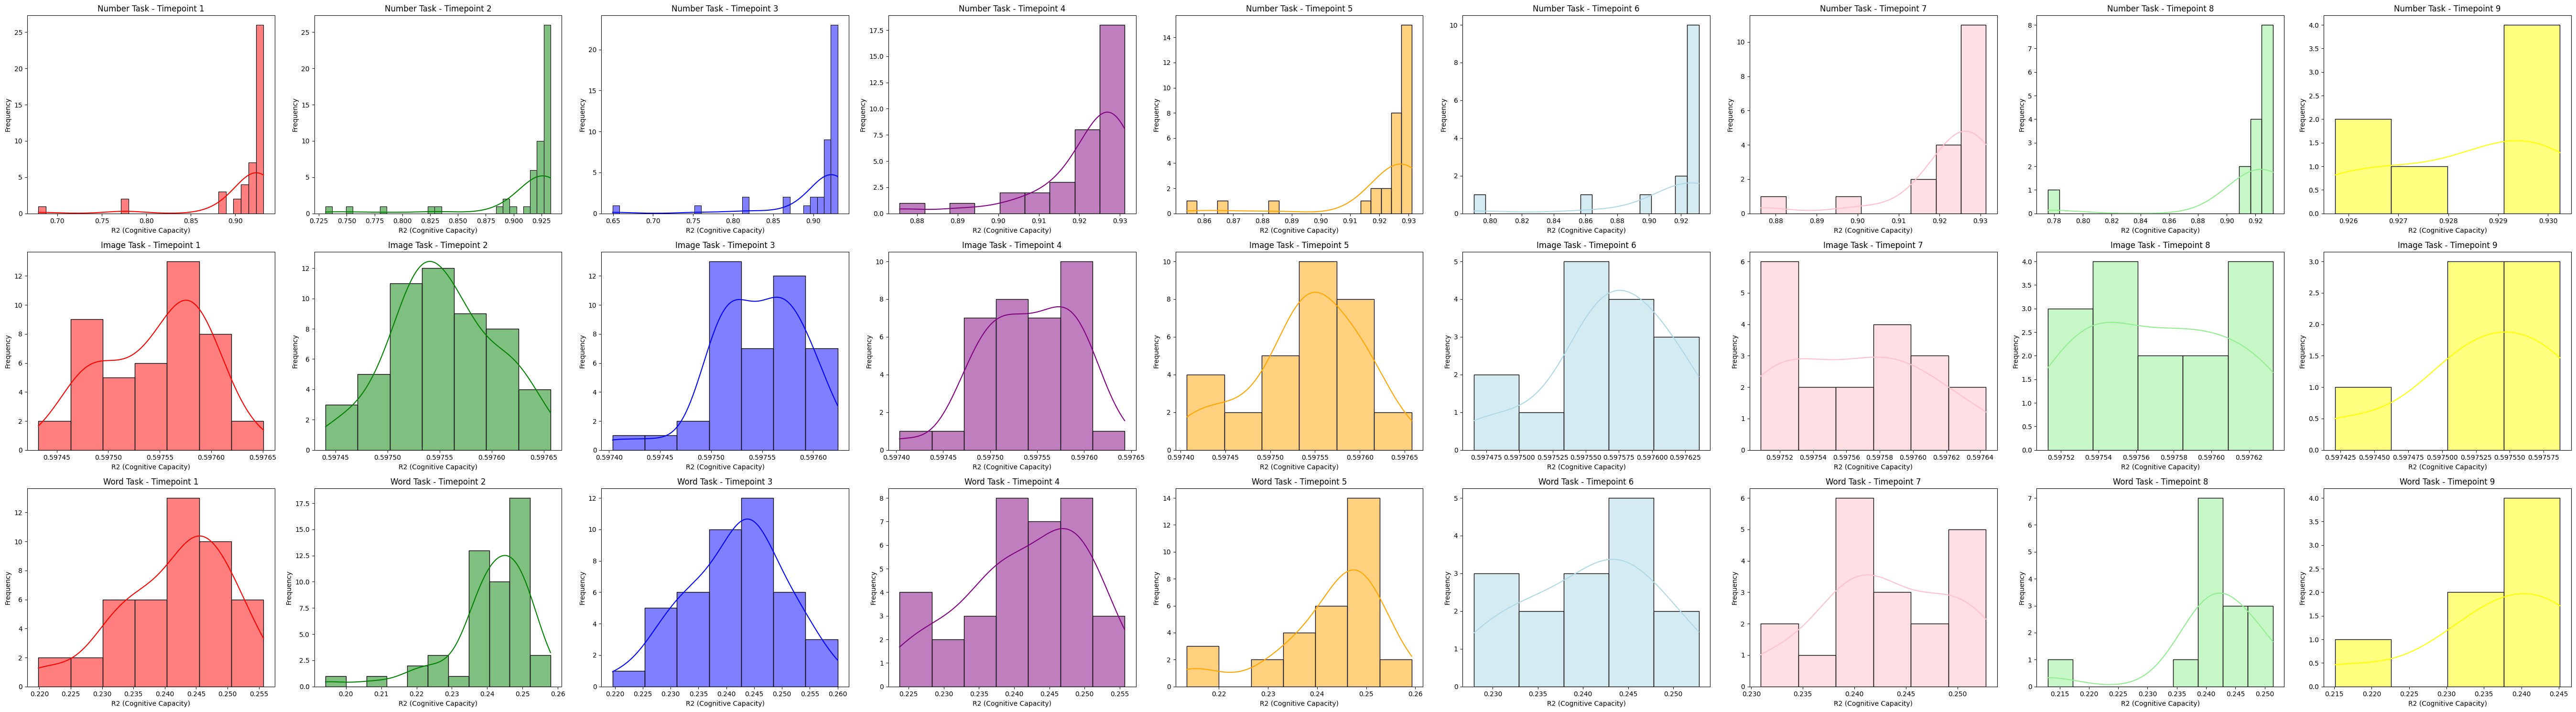

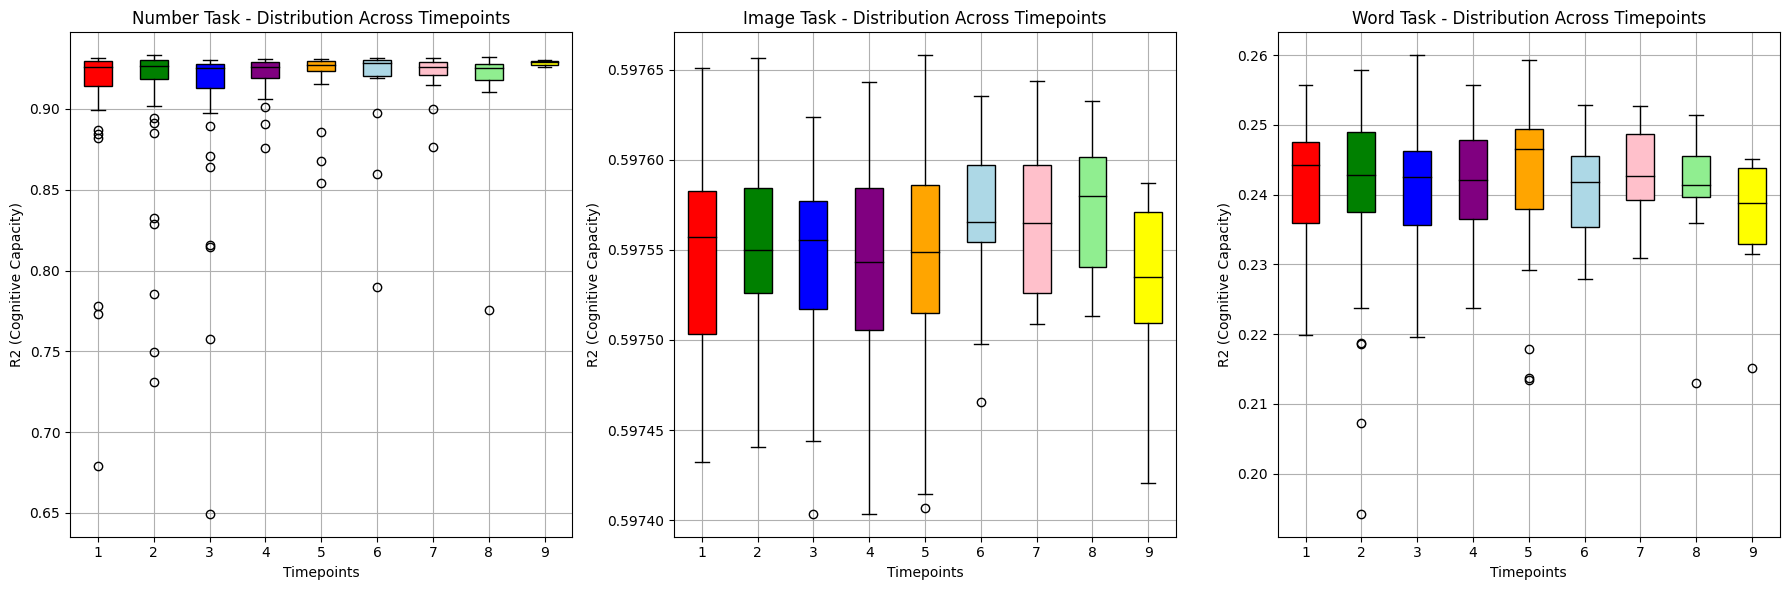

In [49]:
def cognitive_distribution_viz_new_r2(r2_df):
    # Define colors for each timepoint
    colors = ['red', 'green', 'blue', 'purple', 'orange', 'lightblue', 'pink', 'lightgreen', 'yellow']

    # Get unique timelabels and map them to colors
    timelabels = sorted(r2_df['Timelabel'].unique())
    color_map = dict(zip(timelabels, colors[:len(timelabels)]))

    # Plot the cognitive capacity (R2) distribution from each task and each timepoint
    fig, axs = plt.subplots(3, len(timelabels), figsize=(6 * len(timelabels), 15))
    tasks = ['Number', 'Image', 'Word']

    for i, task in enumerate(tasks):
        for j, timelabel in enumerate(timelabels):
            data = r2_df[r2_df['Timelabel'] == timelabel][f'{task}_R2']
            sns.histplot(data, kde=True, ax=axs[i, j], color=color_map[timelabel])
            axs[i, j].set_title(f'{task} Task - Timepoint {timelabel}')
            axs[i, j].set_xlabel('R2 (Cognitive Capacity)')
            axs[i, j].set_ylabel('Frequency')
            axs[i, j].grid(False)

    plt.tight_layout()
    plt.show()

    # Plot the distribution of cognitive property (memory capacity) using box plots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    for i, task in enumerate(tasks):
        data_to_plot = [r2_df[r2_df['Timelabel'] == timelabel][f'{task}_R2'] for timelabel in timelabels]
        box = axs[i].boxplot(data_to_plot, patch_artist=True, medianprops=dict(color='black'))
        
        # Set the face color for each box
        for patch, timelabel in zip(box['boxes'], timelabels):
            patch.set_facecolor(color_map[timelabel])
        
        axs[i].set_title(f'{task} Task - Distribution Across Timepoints')
        axs[i].set_xticks(range(1, len(timelabels) + 1))
        axs[i].set_xticklabels([f'{tl}' for tl in timelabels])
        axs[i].set_xlabel('Timepoints')
        axs[i].set_ylabel('R2 (Cognitive Capacity)')
        axs[i].grid(True)

    plt.tight_layout()
    plt.show()

cognitive_distribution_viz_new_r2(mature_r2_df)

#### MAE

In [55]:
def calculate_cognitive_capacity_new_format(dataset, num_nodes):
    
    # Initialize and test ESNs for each graph in the dataset
    mae_results = []
    reservoir_size = num_nodes

    for subject in range(dataset.shape[0]):
        subject_mae = []
        adjacency_matrix = dataset[subject, 0]  # Since tl is always 1, we use 0 index
        timelabel_arr = dataset[subject,:,0,0]
        timelabel = int(timelabel_arr[0])
        # print(timelabel)

        # Calculate MAE for number sequence
        Win, Wres, bias = initialize_esn(adjacency_matrix, input_size=1, reservoir_size=reservoir_size, output_size=1)
        number_mae = calculate_mae(Win, Wres, bias, number_sequence, number_target)
        
        # Calculate MAE for MNIST sequence
        Win, Wres, bias = initialize_esn(adjacency_matrix, input_size=28*27, reservoir_size=reservoir_size, output_size=28*27)
        mnist_mae = calculate_mae(Win, Wres, bias, mnist_input, mnist_target, alpha=80)
        
        # Calculate MAE for Word2Vec sequence
        Win, Wres, bias = initialize_esn(adjacency_matrix, input_size=50, reservoir_size=reservoir_size, output_size=50)
        word_mae = calculate_mae(Win, Wres, bias, word_input, word_target, alpha=10)

        subject_mae.append((timelabel, number_mae, mnist_mae, word_mae))
        mae_results.append(subject_mae[0])

    # Convert results to a DataFrame for easier manipulation
    mae_df = pd.DataFrame(mae_results, columns=['Timelabel', 'Number_MAE', 'Image_MAE', 'Word_MAE'])

    # Calculate mean, std, max, min for each timelabel and each task
    mean_mae = mae_df.groupby('Timelabel').mean()
    std_mae = mae_df.groupby('Timelabel').std()
    max_mae = mae_df.groupby('Timelabel').max()
    min_mae = mae_df.groupby('Timelabel').min()

    return mae_df, mean_mae, std_mae, max_mae, min_mae

In [56]:
mature_mae_df, mature_mean_mae, mature_std_mae, mature_max_mae, mature_min_mae = calculate_cognitive_capacity_new_format(transformed_and_filtered_data, 300)
mature_mean_mae.mean()

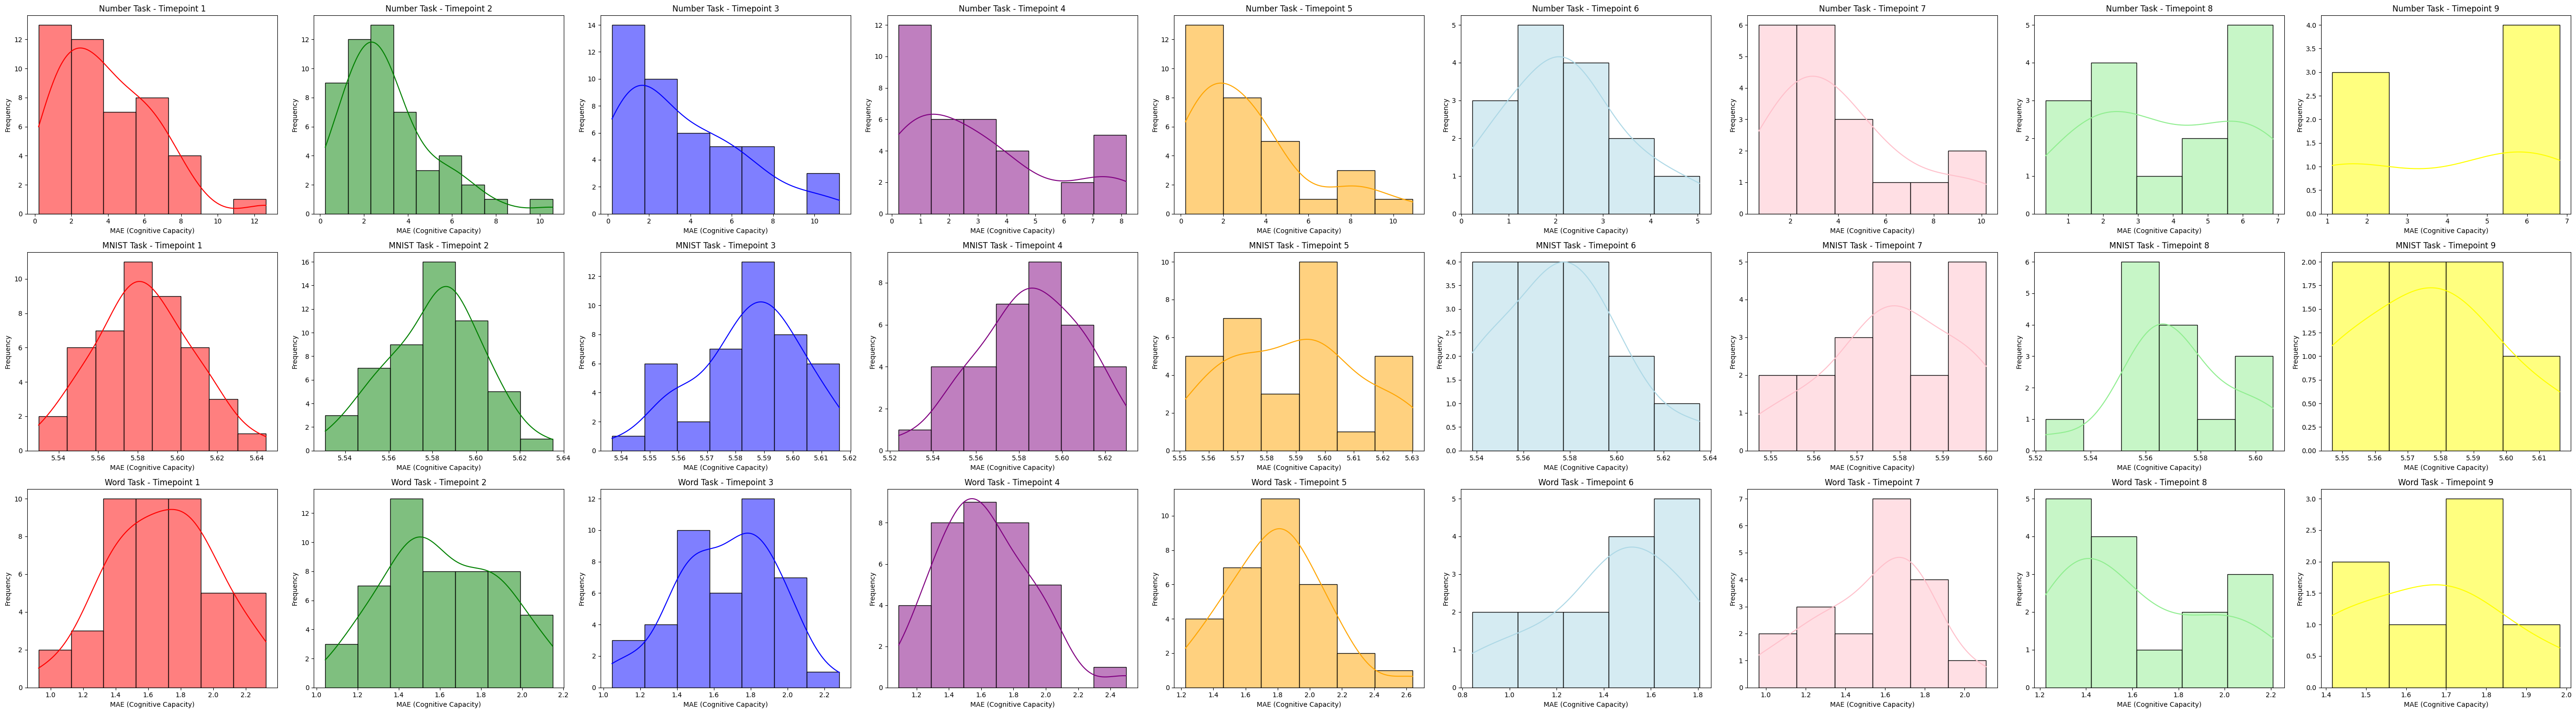

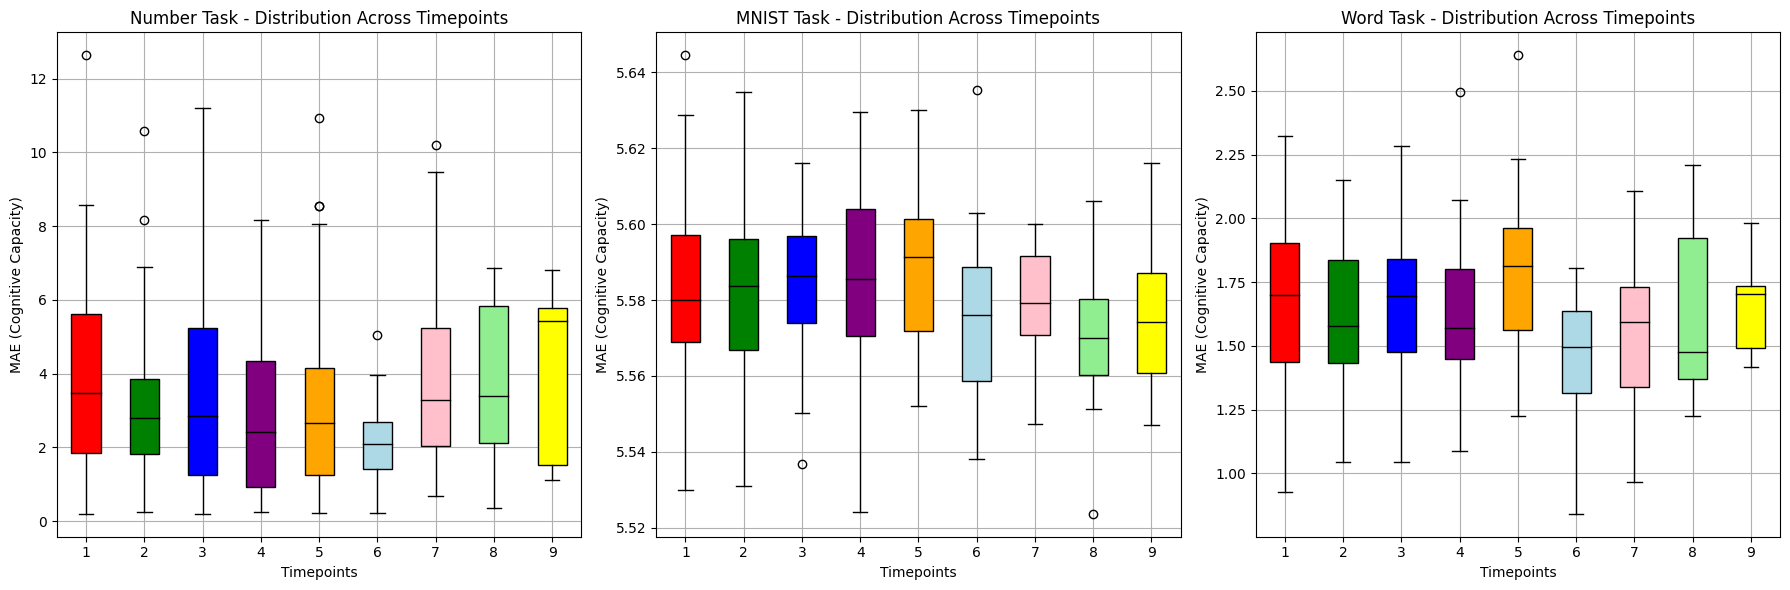

In [64]:
def cognitive_distribution_viz_new(mae_df):
    # Define colors for each timepoint
    colors = ['red', 'green', 'blue', 'purple', 'orange', 'lightblue', 'pink', 'lightgreen', 'yellow']

    # Get unique timelabels and map them to colors
    timelabels = sorted(mae_df['Timelabel'].unique())
    color_map = dict(zip(timelabels, colors[:len(timelabels)]))

    # Plot the cognitive capacity (MAE) distribution from each task and each timepoint
    fig, axs = plt.subplots(3, len(timelabels), figsize=(6 * len(timelabels), 15))
    tasks = ['Number', 'Image', 'Word']

    for i, task in enumerate(tasks):
        for j, timelabel in enumerate(timelabels):
            data = mae_df[mae_df['Timelabel'] == timelabel][f'{task}_MAE']
            sns.histplot(data, kde=True, ax=axs[i, j], color=color_map[timelabel])
            axs[i, j].set_title(f'{task} Task - Timepoint {timelabel}')
            axs[i, j].set_xlabel('MAE (Cognitive Capacity)')
            axs[i, j].set_ylabel('Frequency')
            axs[i, j].grid(False)

    plt.tight_layout()
    plt.show()

    # Plot the distribution of cognitive property (memory capacity) using box plots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    for i, task in enumerate(tasks):
        data_to_plot = [mae_df[mae_df['Timelabel'] == timelabel][f'{task}_MAE'] for timelabel in timelabels]
        box = axs[i].boxplot(data_to_plot, patch_artist=True, medianprops=dict(color='black'))
        
        # Set the face color for each box
        for patch, timelabel in zip(box['boxes'], timelabels):
            patch.set_facecolor(color_map[timelabel])
        
        axs[i].set_title(f'{task} Task - Distribution Across Timepoints')
        axs[i].set_xticks(range(1, len(timelabels) + 1))
        axs[i].set_xticklabels([f'{tl}' for tl in timelabels])
        axs[i].set_xlabel('Timepoints')
        axs[i].set_ylabel('MAE (Cognitive Capacity)')
        axs[i].grid(True)

    plt.tight_layout()
    plt.show()

cognitive_distribution_viz_new(mature_mae_df)